In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr
import os

In [2]:
G = 6.67430e-8
Msun = 1.989e33
Lsun = 3.828e33
Rsun = 6.96e10

secinyear = 3.154e7
secinday = 86400

In [3]:
def index_of_radius(radius,profile):
    return np.argmin(np.abs(10**profile.logR-radius))

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)
def Pterm(Menc,T,rho,kappa,grad_rad,grad_ad):
    return (Menc*T**4/(rho*kappa))*(grad_rad-grad_ad)

# 15 Msun stock model from Evan's code

In [4]:
profMS = mr.MesaData('/home/swu/compressible_stars_CP/compstar/stock_models/zams_15Msol/LOGS/profile47.data')

Text(0.5, 0, 'Radius')

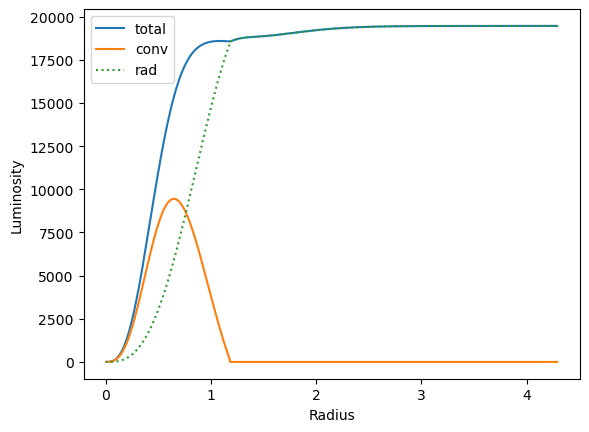

In [5]:
plt.plot(profMS.radius,profMS.luminosity,label='total')
plt.plot(profMS.radius, profMS.lum_conv_div_L*profMS.luminosity,label='conv')
plt.plot(profMS.radius, (1-profMS.lum_conv_div_L)*profMS.luminosity,ls=':',label='rad')
# plt.yscale('log')
plt.legend()
plt.ylabel('Luminosity')
plt.xlabel('Radius')

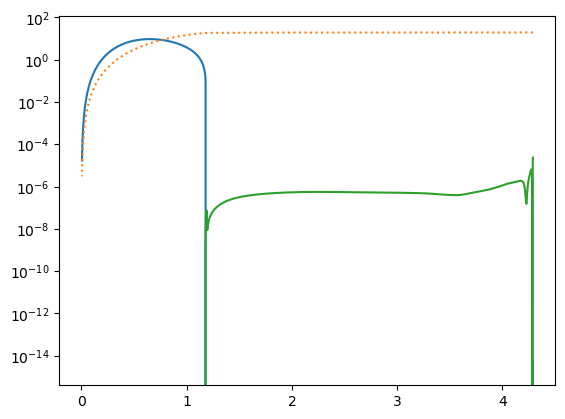

In [6]:
plt.plot(profMS.radius, profMS.lum_conv_div_L*profMS.luminosity/1e3,label='conv')
plt.plot(profMS.radius, (1-profMS.lum_conv_div_L)*profMS.luminosity/1e3,ls=':',label='rad')
plt.plot(profMS.radius, profMS.brunt_N2,label='brunt')
plt.yscale('log')

### test the different chi_rads

In [7]:
import os
from collections import OrderedDict
from pathlib import Path
from types import SimpleNamespace

import numpy as np
import h5py
import matplotlib.pyplot as plt
import dedalus.public as d3

from astropy import units as u
from astropy import constants
from scipy.interpolate import interp1d

import compstar 
from compstar.dedalus.compressible_functions import make_bases
from compstar.dedalus.parser import name_star
from compstar.dedalus.bvp_functions import HSE_solve
from compstar.tools.mesa import DimensionalMesaReader, find_core_cz_radius, adjust_opacity, opacity_func
from compstar.tools.general import one_to_zero, zero_to_one
import compstar.defaults.config as config

In [8]:
# Read in parameters and create output directory
out_dir, out_file = name_star()
ncc_dict = config.nccs

# Find the path to the MESA profile file
package_path = Path(compstar.__file__).resolve().parent
stock_path = package_path.joinpath('stock_models')
mesa_file_path = None
if os.path.exists(config.star['path']):
    mesa_file_path = config.star['path']
else:
    stock_file_path = stock_path.joinpath(config.star['path'])
    if os.path.exists(stock_file_path):
        mesa_file_path = str(stock_file_path)
    else:
        raise ValueError("Cannot find MESA profile file in {} or {}".format(config.star['path'], stock_file_path))

2024-12-02 11:16:07,715 compstar.dedalus.parser 0/1 INFO :: star file: star/star_64+32_bounds0-1.5L_Re1.00e+03_de1.5_cutoff1.0e-08.h5


In [9]:
# Read in the MESA profile
reader = DimensionalMesaReader(mesa_file_path)
dmr = SimpleNamespace(**reader.structure) # Turns the dictionary into a namespace so that fields can be accessed as attributes
#make some commonly-used variables local.
r, mass, rho, T = dmr.r, dmr.mass, dmr.rho, dmr.T
N2, g, cp = dmr.N2, dmr.g, dmr.cp

### CORE CONVECTION LOGIC - lots of stuff here needs to be generalized for other types of stars.
core_cz_radius = find_core_cz_radius(mesa_file_path, dimensionless=False)
opacity_adjusted, gff_out, z_frac_out, x_frac_out,ye_out = adjust_opacity(mesa_file_path, dimensionless=False)
### Recalculate k_rad and rad_diff using adjusted opacity
rad_diff        = (16 * constants.sigma_sb.cgs * T**3 / (3 * rho**2 * cp * opacity_adjusted)).cgs
k_rad    = rad_cond = rad_diff*(rho * cp)


2024-12-02 11:16:07,727 compstar.tools.mesa 0/1 INFO :: Reading MESA file /home/swu/compressible_stars_CP/compstar/stock_models/zams_15Msol/LOGS/profile47.data


In [10]:
r_bounds = list(config.star['r_bounds'])
r_bools = []
for i, rb in enumerate(r_bounds):
    if type(rb) == str:
        if 'R' in rb:
            r_bounds[i] = float(rb.replace('R', ''))*dmr.R_star
        elif 'L' in rb:
            r_bounds[i] = float(rb.replace('L', ''))*core_cz_radius
        else:
            try:
                r_bounds[i] = float(r_bounds[i]) * u.cm
            except:
                raise ValueError("index {} ('{}') of r_bounds is poorly specified".format(i, rb))
        r_bounds[i] = core_cz_radius*np.around(r_bounds[i]/core_cz_radius, decimals=2)
for i, rb in enumerate(r_bounds):
    if i < len(r_bounds) - 1:
        r_bools.append((r > r_bounds[i])*(r <= r_bounds[i+1]))
sim_bool      = (r > r_bounds[0])*(r <= r_bounds[-1])
#Get N2 info
N2max_sim = N2[sim_bool].max()
shell_points = np.sum(sim_bool*(r > core_cz_radius))
N2plateau = np.median(N2[r > core_cz_radius][int(shell_points*0.25):int(shell_points*0.75)])
f_brunt = np.sqrt(N2max_sim)/(2*np.pi)
#Nondimensionalization
L_CZ    = core_cz_radius
m_core  = rho[0] * L_CZ**3
T_core  = T[0]
H0      = (rho*dmr.eps_nuc)[0]
tau_heat  = ((H0*L_CZ/m_core)**(-1/3)).cgs #heating timescale
L_nd    = L_CZ
m_nd    = rho[r==L_nd][0] * L_nd**3 #mass at core cz boundary
T_nd    = T[r==L_nd][0] #temp at core cz boundary
tau_nd  = (1/f_brunt).cgs #timescale of max N^2
rho_nd  = m_nd/L_nd**3
u_nd    = L_nd/tau_nd
s_nd    = L_nd**2 / tau_nd**2 / T_nd
H_nd    = (m_nd / L_nd) * tau_nd**-3
s_motions    = L_nd**2 / tau_heat**2 / T[0]
lum_nd  = L_nd**2 * m_nd / (tau_nd**2) / tau_nd
nondim_R_gas = (dmr.R_gas / s_nd).cgs.value
nondim_gamma1 = (dmr.gamma1[0]).value
nondim_cp = nondim_R_gas * nondim_gamma1 / (nondim_gamma1 - 1)
nondim_G = (constants.G.cgs / (L_nd**3 / m_nd / tau_nd**2)).cgs
u_heat_nd = (L_nd/tau_heat) / u_nd
Ma2_r0 = ((u_nd*(tau_nd/tau_heat))**2 / ((dmr.gamma1[0]-1)*cp[0]*T[0])).cgs
print('Nondimensionalization: L_nd = {:.2e}, T_nd = {:.2e}, m_nd = {:.2e}, tau_nd = {:.2e}'.format(L_nd, T_nd, m_nd, tau_nd))
print('Thermo: Cp/s_nd: {:.2e}, R_gas/s_nd: {:.2e}, gamma1: {:.4f}'.format(nondim_cp, nondim_R_gas, nondim_gamma1))
print('m_nd/M_\odot: {:.3f}'.format((m_nd/constants.M_sun).cgs))
print('estimated mach number: {:.3e} / t_heat: {:.3e}'.format(np.sqrt(Ma2_r0), tau_heat))

Nondimensionalization: L_nd = 8.21e+10 cm, T_nd = 2.35e+07 K, m_nd = 1.89e+33 g, tau_nd = 9.19e+03 s
Thermo: Cp/s_nd: 1.14e+02, R_gas/s_nd: 4.10e+01, gamma1: 1.5603
m_nd/M_\odot: 0.950
estimated mach number: 1.490e-03 / t_heat: 4.663e+05 s


In [11]:
#Gravitational potential, set to -1 at r = R_star
g_phi = np.cumsum(g*np.gradient(r))  #gvec = -grad phi; 
g_phi -= g_phi[-1] - u_nd**2 #set g_phi = -1 at r = dmr.R_star

#construct diffusivity profiles which will be used in simulation.
rad_diff_nd = rad_diff * (tau_nd / L_nd**2)
# rad_diff_nd = dmr.rad_diff * (tau_nd / L_nd**2)
rad_diff_cutoff = (1/(config.numerics['prandtl']*config.numerics['reynolds_target'])) * ((L_CZ**2/tau_heat) / (L_nd**2/tau_nd))
sim_rad_diff = np.copy(rad_diff_nd) + rad_diff_cutoff
sim_nu_diff = config.numerics['prandtl']*rad_diff_cutoff*np.ones_like(sim_rad_diff)
Re_shift = ((L_nd**2/tau_nd) / (L_CZ**2/tau_heat))

print('u_heat_nd: {:.3e}'.format(u_heat_nd))
print('rad_diff cutoff: {:.3e}'.format(rad_diff_cutoff))
print('rad_diff cutoff: {:.3e}'.format(rad_diff_cutoff * (L_nd**2/tau_nd)))

#MESA radial values at simulation joints & across full star in simulation units
r_bound_nd = [(rb/L_nd).value for rb in r_bounds]
r_nd = (r/L_nd).cgs

interp_kwargs = {'fill_value' : 'extrapolate', 'bounds_error' : False}
#Create interpolations of the various fields that may be used in the problem
interpolations = OrderedDict()
interpolations['chi_rad'] = interp1d(r_nd, sim_rad_diff, **interp_kwargs)
interpolations['grad_chi_rad'] = interp1d(r_nd, np.gradient(rad_diff_nd, r_nd), **interp_kwargs)


u_heat_nd: 1.971e-02
rad_diff cutoff: 1.971e-05
rad_diff cutoff: 1.444e+13 cm2 / s


In [12]:
L_nd

<Quantity 8.20558951e+10 cm>

In [13]:
r_nd

<Quantity [0.00401291, 0.00505596, 0.00637013, ..., 3.63652126, 3.63665895,
           3.63676717]>

(0.003, 1.5)

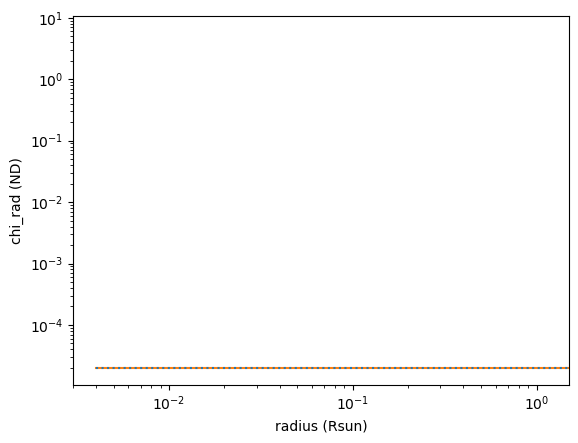

In [14]:
plt.plot(r_nd,interpolations['chi_rad'](r_nd),label='interpolated',ls=':',zorder=4)
plt.plot(r_nd,sim_rad_diff,label='direct from adjusted opacity')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (Rsun)')
plt.ylabel('chi_rad (ND)')
plt.xlim(3e-3,1.5)

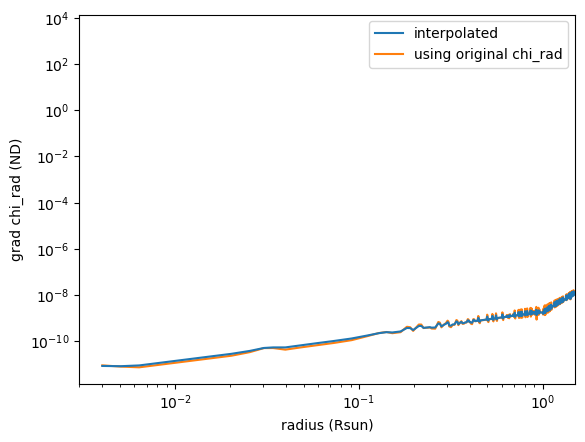

In [15]:
plt.plot(r_nd,interpolations['grad_chi_rad'](r_nd),label='interpolated',ls='-',zorder=4)
plt.plot(r_nd,np.gradient(dmr.rad_diff*(tau_nd / L_nd**2)+rad_diff_cutoff,r_nd),label='using original chi_rad')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (Rsun)')
plt.ylabel('grad chi_rad (ND)')
plt.xlim(3e-3,1.5)
plt.legend()
#looks the same

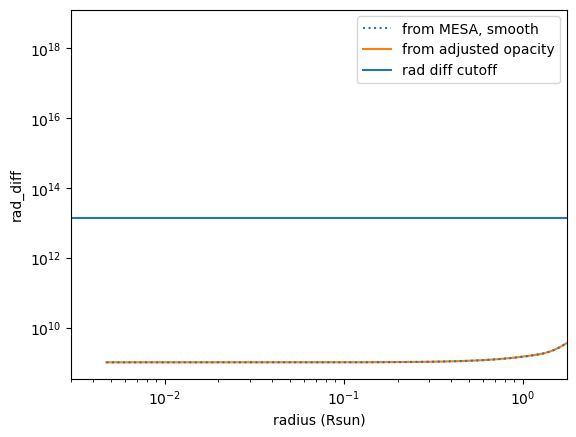

In [16]:
plt.plot(r/Rsun,dmr.rad_diff,label='from MESA, smooth',ls=':',zorder=4)
plt.plot(r/Rsun,rad_diff,label='from adjusted opacity')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (Rsun)')
plt.ylabel('rad_diff')
plt.xlim(3e-3,core_cz_radius.value/Rsun*1.5)
plt.axhline(1.44e13,label='rad diff cutoff')
plt.legend()

(0.003, 1.1789640095242324)

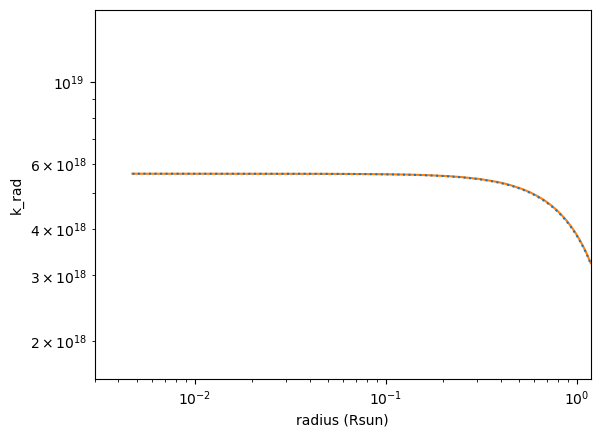

In [17]:
plt.plot(r/Rsun,dmr.k_rad,label='from MESA, smooth',ls=':',zorder=4)
plt.plot(r/Rsun,k_rad,label='from adjusted opacity')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius (Rsun)')
plt.ylabel('k_rad')
plt.xlim(3e-3,core_cz_radius.value/Rsun)

continue to testing HSE solver

In [18]:
grad_s_transition_default=0.03 #from input to function build_nccs

In [19]:

### Make dedalus domain and bases
resolutions = [(1, 1, nr) for nr in config.star['nr']]
stitch_radii = r_bound_nd[1:-1]
dtype=np.float64
mesh=None
dealias = config.numerics['N_dealias']
c, d, bases, bases_keys = make_bases(resolutions, stitch_radii, r_bound_nd[-1], dealias=(1,1,dealias), dtype=dtype, mesh=mesh)
dedalus_r = OrderedDict()
for bn in bases.keys():
    phi, theta, r_vals = bases[bn].global_grids(d,scales=(1, 1, dealias))
    dedalus_r[bn] = r_vals

# Construct convective flux function which determines how convection is driven
if config.star['smooth_h']:
    #smooth CZ-RZ transition
    #keep this even when using RZ solver because otherwise it's not smooth at the transition.
    #will just use L_rad = L - L_conv_sim
    L_conv_sim = np.copy(dmr.L_conv)
    L_conv_sim *= one_to_zero(r, 0.9*core_cz_radius, width=0.05*core_cz_radius)
    L_conv_sim *= one_to_zero(r, 0.95*core_cz_radius, width=0.05*core_cz_radius)
    L_conv_sim /= (r/L_nd)**2 * (4*np.pi)
    F_conv_func = interp1d(r/L_nd, L_conv_sim/lum_nd, **interp_kwargs)
else:
    raise NotImplementedError("must use smooth_h")

# Get some timestepping & wave frequency info
f_nyq = 2*tau_nd*np.sqrt(N2max_sim)/(2*np.pi)
nyq_dt   = (1/f_nyq) 
kepler_tau     = 30*60*u.s
max_dt_kepler  = kepler_tau/tau_nd
max_dt = max_dt_kepler
print('needed nyq_dt is {} s / {} % of a nondimensional time (Kepler 30 min is {} %) '.format(nyq_dt*tau_nd, nyq_dt*100, max_dt_kepler*100))

#Create interpolations of the various fields that may be used in the problem
interpolations = OrderedDict()
interpolations['ln_rho0'] = interp1d(r_nd, np.log(rho/rho_nd), **interp_kwargs)
interpolations['ln_T0'] = interp1d(r_nd, np.log(T/T_nd), **interp_kwargs)
interpolations['grad_ln_rho0'] = interp1d(r_nd, dmr.dlogrhodr*L_nd, **interp_kwargs)
interpolations['grad_ln_T0'] = interp1d(r_nd, dmr.dlogTdr*L_nd, **interp_kwargs)
interpolations['T0'] = interp1d(r_nd, T/T_nd, **interp_kwargs)
interpolations['nu_diff'] = interp1d(r_nd, sim_nu_diff, **interp_kwargs)
interpolations['chi_rad'] = interp1d(r_nd, sim_rad_diff, **interp_kwargs)
interpolations['grad_chi_rad'] = interp1d(r_nd, np.gradient(rad_diff_nd, r_nd), **interp_kwargs)
interpolations['g'] = interp1d(r_nd, -g * (tau_nd**2/L_nd), **interp_kwargs)
interpolations['g_phi'] = interp1d(r_nd, g_phi * (tau_nd**2 / L_nd**2), **interp_kwargs)

# construct N2 function 
# TODO: I think some of this logic is happening inside the BVP; make sure it's all together.
### More core convection zone logic here
grad_s_width = grad_s_transition_default
grad_s_width *= (L_CZ/L_nd).value
grad_s_transition_point = r_bound_nd[1] - grad_s_width
print('using default grad s transition point = {}'.format(grad_s_transition_point))
print('using default grad s width = {}'.format(grad_s_width))

#Build a nice function for our basis in the ball
#have N^2 = A*r^2 + B; grad_N2 = 2 * A * r, so A = (grad_N2) / (2 * r_stitch) & B = stitch_value - A*r_stitch^2
stitch_point = 1
stitch_point = bases['B'].radius
stitch_value = np.interp(stitch_point, r/L_nd, N2)
grad_N2_stitch = np.gradient(N2, r)[r/L_nd < stitch_point][-1]
A = grad_N2_stitch / (2*bases['B'].radius * L_nd)
B = stitch_value - A* (bases['B'].radius * L_nd)**2
smooth_N2 = np.copy(N2)
smooth_N2[r/L_nd < stitch_point] = A*(r[r/L_nd < stitch_point])**2 + B
smooth_N2 *= zero_to_one(r/L_nd, grad_s_transition_point, width=grad_s_width)

# Solve for hydrostatic equilibrium for background
N2_func = interp1d(r_nd, tau_nd**2 * smooth_N2, **interp_kwargs)
grad_ln_rho_func = interpolations['grad_ln_rho0']

needed nyq_dt is 4595.004527080169 s s / 50.000000000000014 % of a nondimensional time (Kepler 30 min is 19.586487775930276 %) 
using default grad s transition point = 1.07
using default grad s width = 0.03


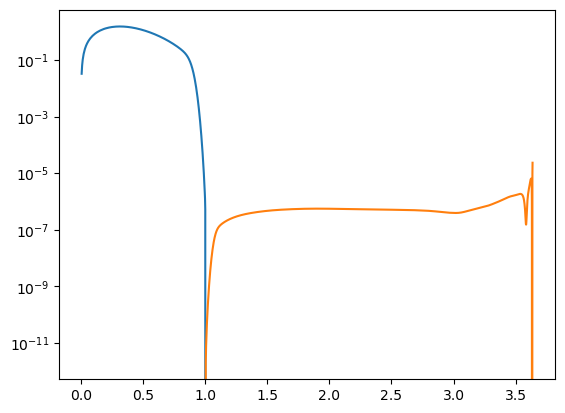

In [20]:
plt.plot(r/L_nd,L_conv_sim/1e37)
plt.plot(r/L_nd,smooth_N2)
plt.yscale('log')

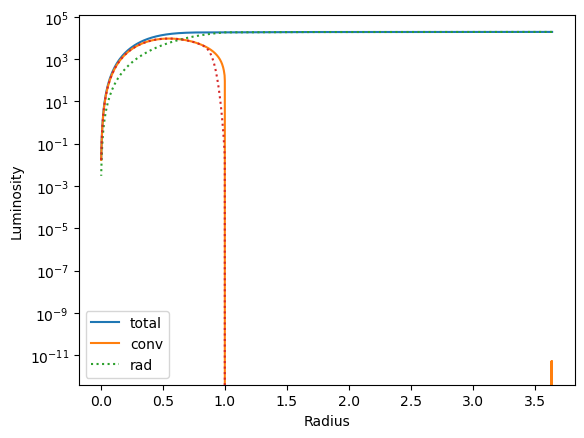

In [21]:
plt.plot(profMS.radius*Rsun/L_nd,profMS.luminosity,label='total')
plt.plot(profMS.radius*Rsun/L_nd, profMS.lum_conv_div_L*profMS.luminosity,label='conv')
plt.plot(profMS.radius*Rsun/L_nd, (1-profMS.lum_conv_div_L)*profMS.luminosity,ls=':',label='rad')
plt.plot(r/L_nd,L_conv_sim*(r/L_nd)**2 * (4*np.pi)/Lsun,ls=':')
# plt.yscale('log')
plt.legend()
plt.ylabel('Luminosity')
plt.xlabel('Radius')
plt.yscale('log')

In [22]:
r_bound_nd

[0.0, 1.1, 1.5]

(-0.1, 1.5)

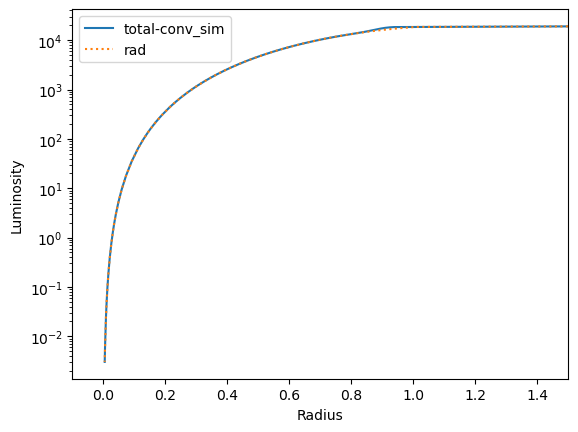

In [23]:
# plt.plot(profMS.radius*Rsun/L_nd,profMS.luminosity-(L_conv_sim*(r/L_nd)**2).cgs.value * (4*np.pi)/Lsun,label='total-Lconv_sim')
plt.plot(profMS.radius*Rsun/L_nd,profMS.luminosity -np.flip(L_conv_sim*(r/L_nd)**2).cgs.value * (4*np.pi)/Lsun
         ,label='total-conv_sim')
plt.plot(profMS.radius*Rsun/L_nd, (1-profMS.lum_conv_div_L)*profMS.luminosity,ls=':',label='rad')
# plt.plot(r/L_nd,L_conv_sim*(r/L_nd)**2 * (4*np.pi)/Lsun)
# plt.yscale('log') 
plt.legend()
plt.ylabel('Luminosity')
plt.xlabel('Radius') #only goes out to like 1.5 in real sim
plt.yscale('log')
plt.xlim(-0.1,1.5)

In [24]:

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

from scipy.interpolate import interp1d
from compstar.tools.general import one_to_zero
import logging
logger = logging.getLogger(__name__)

interp_kwargs = {'fill_value' : 'extrapolate', 'bounds_error' : False}

def HSE_solve(coords, dist, bases, grad_ln_rho_func, N2_func, Fconv_func, r_stitch=[], r_outer=1, low_nr=16, \
              R=1, gamma=5/3, nondim_radius=1, ncc_cutoff=1e-9, tolerance=1e-9, HSE_tolerance = 1e-4):
    """
    Solves for hydrostatic equilibrium in a calorically perfect ideal gas.
    The solution for density, entropy, and gravity is found given a specified function of N^2 and grad ln rho.
    The heating term associated with a convective luminosity is also found given a specified function of the convective flux, Fconv.

    Arguments
    ---------
    coords : Dedalus CoordinateSystem object
        The coordinate system in which the solution is found.
    dist : Dedalus Distributor object
        The distributor object associated with the bases; should NOT be in parallel.
    bases : dict
        A dictionary of Dedalus bases, with keys 'B', 'S1', 'S2', etc. for the Ball basis, first Shell basis, second Shell basis, etc.
    grad_ln_rho_func : function
        A function of radius that returns the gradient of the log of density. Input r should be nondimensionalized.
    N2_func : function
        A function of radius that returns the nondimensionalized Brunt-Vaisala frequency squared. Input r should be nondimensionalized.
    Fconv_func : function
        A function of radius that returns the nondimensionalized convective flux. Input r should be nondimensionalized.
    r_stitch : list
        A list of radii at which to stitch together the solutions from different bases. 
        The first element should be the radius of the outer boundary of the BallBasis.
        If there is only one basis, r_stitch should be an empty list.
    r_outer : float
        The radius of the outer boundary of the simulation domain.
    low_nr : int
        The number of radial points in the low resolution domain; used to set up background fields for solve. #TODO: make this by-basis.
    R : float
        The nondimensional value of the gas constant divided by the mean molecular weight.
    gamma : float
        The adiabatic index of the gas.
    nondim_radius : float
        The radius where thermodynamics are nondimensionalized.
    ncc_cutoff : float
        The NCC floor for the solver. See Dedalus.core.solvers.SolverBase
    tolerance : float
        The tolerance for perturbation norm of the newton iteration.
    HSE_tolerance : float
        The tolerance for hydrostatic equilibrium of the BVP solve.
    
    Returns
    -------
    atmosphere : dict
        A dictionary of interpolated functions which return atmospheric quantities as a function of nondimensional radius.
    """
    # Parameters
    namespace = dict()
    namespace['R'] = R
    namespace['Cp'] = Cp = R*gamma/(gamma-1)
    namespace['gamma'] = gamma
    namespace['log'] = np.log

    #Loop over bases, set up fields and operators.
    for k, basis in bases.items():
        namespace['basis_{}'.format(k)] = basis
        namespace['S2_basis_{}'.format(k)] = S2_basis = basis.S2_basis()

        # Make problem variables and taus.
        namespace['g_phi_{}'.format(k)] = Q = dist.Field(name='g_phi', bases=basis)
        namespace['Q_{}'.format(k)] = Q = dist.Field(name='Q', bases=basis)
        namespace['s_{}'.format(k)] = s = dist.Field(name='s', bases=basis)
        namespace['g_{}'.format(k)] = g = dist.VectorField(coords, name='g', bases=basis)
        namespace['ln_rho_{}'.format(k)] = ln_rho = dist.Field(name='ln_rho', bases=basis)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = dist.VectorField(coords, name='grad_ln_rho', bases=basis)
        namespace['tau_s_{}'.format(k)] = tau_s = dist.Field(name='tau_s', bases=S2_basis)
        namespace['tau_rho_{}'.format(k)] = tau_rho = dist.Field(name='tau_rho', bases=S2_basis)
        namespace['tau_g_phi_{}'.format(k)] = tau_g_phi = dist.Field(name='tau_g_phi', bases=S2_basis)

        # Set up some fundamental grid data
        low_scales = low_nr/basis.radial_basis.radial_size 
        phi, theta, r = dist.local_grids(basis)
        phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
        phi_low, theta_low, r_low = dist.local_grids(basis, scales=(1,1,low_scales))
        namespace['r_de_{}'.format(k)] = r_de
        namespace['r_vec_{}'.format(k)] = r_vec = dist.VectorField(coords, bases=basis.radial_basis)
        r_vec['g'][2] = r
        namespace['r_squared_{}'.format(k)] = r_squared = dist.Field(bases=basis.radial_basis)
        r_squared['g'] = r**2       

        # Make lift operators for BCs
        if k == 'B':
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis, -1)
        else:
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis.derivative_basis(2), -1)

        # Make a field of ones for converting NCCs to full fields.
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1

        #Make a field that smooths at the edge of the ball basis.
        namespace['edge_smoothing_{}'.format(k)] = edge_smooth = dist.Field(bases=basis, name='edge_smooth')
        edge_smooth['g'] = one_to_zero(r, 0.95*bases['B'].radius, width=0.03*bases['B'].radius)

        # Get a high-resolution N^2 in the ball; low-resolution elsewhere where it transitions more gradually.
        namespace['N2_{}'.format(k)] = N2 = dist.Field(bases=basis, name='N2')
        if k == 'B':
            N2['g'] = N2_func(r)
        else:
            N2.change_scales(low_scales)
            N2['g'] = N2_func(r_low)

        #Set grad ln rho.
        grad_ln_rho.change_scales(low_scales)
        grad_ln_rho['g'][2] = grad_ln_rho_func(r_low)

        # Set the convective flux.
        namespace['Fconv_{}'.format(k)] = Fconv   = dist.VectorField(coords, name='Fconv', bases=basis)
        Fconv['g'][2] = Fconv_func(r)

        # Create important operations from the fields.
        namespace['ln_pomega_LHS_{}'.format(k)] = ln_pomega_LHS = gamma*(s/Cp + ((gamma-1)/gamma)*ln_rho*ones)
        namespace['ln_pomega_{}'.format(k)] = ln_pomega = ln_pomega_LHS + np.log(R)
        namespace['pomega_{}'.format(k)] = pomega = np.exp(ln_pomega)
        namespace['P_{}'.format(k)] = P = pomega*np.exp(ln_rho)
        namespace['HSE_{}'.format(k)] = HSE = gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) - g*ones
        namespace['N2_op_{}'.format(k)] = N2_op = -g@d3.grad(s)/Cp
        namespace['rho_{}'.format(k)] = rho = np.exp(ln_rho*ones)
        namespace['T_{}'.format(k)] = T = pomega/R
        namespace['ln_T_{}'.format(k)] = ln_T = ln_pomega - np.log(R)
        namespace['grad_pomega_{}'.format(k)] = d3.grad(pomega)
        namespace['grad_ln_pomega_{}'.format(k)] = d3.grad(ln_pomega)
        namespace['grad_s_{}'.format(k)] = grad_s = d3.grad(s)
        namespace['r_vec_g_{}'.format(k)] = r_vec@g
        namespace['g_op_{}'.format(k)] = gamma * pomega * (grad_s/Cp + grad_ln_rho)
        namespace['s0_{}'.format(k)] = Cp * ((1/gamma)*(ln_pomega + ln_rho) - ln_rho) #s with an offset so s0 = cp * (1/gamma * lnP - ln_rho)

    namespace['pi'] = np.pi
    locals().update(namespace)

    #Solve for ln_rho.
    variables, taus = [], []
    for k, basis in bases.items():
        variables += [namespace['ln_rho_{}'.format(k)],]
        taus      += [namespace['tau_rho_{}'.format(k)],]

    problem = d3.NLBVP(variables + taus, namespace=locals())
    for k, basis in bases.items():
        #Equation is just definitional.
        problem.add_equation("grad(ln_rho_{0}) - grad_ln_rho_{0} + r_vec_{0}*lift_{0}(tau_rho_{0}) = 0".format(k))
    
    #Set boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            problem.add_equation("ln_rho_{0}(r={2}) - ln_rho_{1}(r={2}) = 0".format(k, k_old, r_s))
        iter += 1
    problem.add_equation("ln_rho_B(r=nondim_radius) = 0")

    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance:
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
    logger.info('ln_rho found')

    #Solve for everything else given ln_rho.
    variables, taus = [], []
    for k, basis in bases.items():
        variables += [namespace['s_{}'.format(k)], namespace['g_{}'.format(k)], namespace['Q_{}'.format(k)], namespace['g_phi_{}'.format(k)]]
        taus += [namespace['tau_s_{}'.format(k)], namespace['tau_g_phi_{}'.format(k)]]

    problem = d3.NLBVP(variables + taus, namespace=locals())
    for k, basis in bases.items():
        #Set a decent initial guess for s.
        namespace['s_{}'.format(k)].change_scales(basis.dealias)
        namespace['s_{}'.format(k)]['g'] = -(R*namespace['ln_rho_{}'.format(k)]).evaluate()['g']

        #Set the equations: hydrostatic equilibrium, gravity, Q.
        problem.add_equation("grad(ln_rho_{0})@(grad(s_{0})/Cp) + lift_{0}(tau_s_{0}) = -N2_{0}/(gamma*pomega_{0}) - grad(s_{0})@grad(s_{0}) / Cp**2".format(k))
        problem.add_equation("g_{0} = g_op_{0} ".format(k))
        problem.add_equation("Q_{0} = edge_smoothing_{0}*div(Fconv_{0})".format(k))
        problem.add_equation("grad(g_phi_{0}) + g_{0} + r_vec_{0}*lift_{0}(tau_g_phi_{0}) = 0".format(k))
    
    #Set the boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            problem.add_equation("s_{0}(r={2}) - s_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("g_phi_{0}(r={2}) - g_phi_{1}(r={2}) = 0".format(k, k_old, r_s))
        iter += 1
        if iter == len(bases.items()):
            problem.add_equation("g_phi_{0}(r=r_outer) = 0".format(k))
    problem.add_equation("ln_pomega_LHS_B(r=nondim_radius) = 0")

    #Solve with tolerances on pert_norm and hydrostatic equilibrium.
    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance or HSE_err > HSE_tolerance:
        HSE_err = 0
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
        for k, basis in bases.items():
            this_HSE = np.max(np.abs(namespace['HSE_{}'.format(k)].evaluate()['g']))
            logger.info('HSE in {}:{:.3e}'.format(k, this_HSE))
            if this_HSE > HSE_err:
                HSE_err = this_HSE

    # Stitch together the fields for creation of interpolators that span the full simulation domain.
    #Need: grad_pom0, grad_ln_pom0, grad_ln_rho0, grad_s0, g, pom0, rho0, ln_rho0, g_phi
    stitch_fields = OrderedDict()
    fields = ['grad_pomega', 'grad_ln_pomega', 'grad_ln_rho', 'grad_s', 'g', 'pomega', 'rho', 'ln_rho', 'g_phi', 'r_vec', 'HSE', 'N2_op', 'Q', 's0']
    for f in fields:
        stitch_fields[f] = []
    
    for k, basis in bases.items():
        for f in fields:
            stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'])]

    if len(stitch_fields['r_vec']) == 1:
        for f in fields:
            stitch_fields[f] = stitch_fields[f][0]
    else:
        for f in fields:
            stitch_fields[f] = np.concatenate(stitch_fields[f], axis=-1)

    grad_pom = stitch_fields['grad_pomega'][2,:].ravel()
    grad_ln_pom = stitch_fields['grad_ln_pomega'][2,:].ravel()
    grad_ln_rho = stitch_fields['grad_ln_rho'][2,:].ravel()
    grad_s = stitch_fields['grad_s'][2,:].ravel()
    g = stitch_fields['g'][2,:].ravel()
    HSE = stitch_fields['HSE'][2,:].ravel()
    r = stitch_fields['r_vec'][2,:].ravel()

    pom = stitch_fields['pomega'].ravel()
    rho = stitch_fields['rho'].ravel()
    ln_rho = stitch_fields['ln_rho'].ravel()
    g_phi = stitch_fields['g_phi'].ravel()
    N2 = stitch_fields['N2_op'].ravel()
    Q = stitch_fields['Q'].ravel()
    s0 = stitch_fields['s0'].ravel()


    #Plot the results.
    fig = plt.figure()
    ax1 = fig.add_subplot(4,2,1)
    ax2 = fig.add_subplot(4,2,2)
    ax3 = fig.add_subplot(4,2,3)
    ax4 = fig.add_subplot(4,2,4)
    ax5 = fig.add_subplot(4,2,5)
    ax6 = fig.add_subplot(4,2,6)
    ax7 = fig.add_subplot(4,2,7)
    ax8 = fig.add_subplot(4,2,8)
    ax1.plot(r, grad_pom, label='grad pomega')
    ax1.legend()
    ax2.plot(r, grad_ln_rho, label='grad ln rho')
    ax2.legend()
    ax3.plot(r, pom/R, label='pomega/R')
    ax3.plot(r, rho, label='rho')
    ax3.legend()
    ax4.plot(r, HSE, label='HSE')
    ax4.legend()
    ax5.plot(r, g, label='g')
    ax5.legend()
    ax6.plot(r, g_phi, label='g_phi')
    ax6.legend()
    ax7.plot(r, N2, label=r'$N^2$')
    ax7.plot(r, -N2, label=r'$-N^2$')
    ax7.plot(r, (N2_func(r)), label=r'$N^2$ goal', ls='--')
    ax7.set_yscale('log')
    yticks = (np.max(np.abs(N2.ravel()[r.ravel() < 0.5])), np.max(N2_func(r).ravel()))
    ax7.set_yticks(yticks)
    ax7.set_yticklabels(['{:.1e}'.format(n) for n in yticks])
    ax7.legend()
    ax8.plot(r, grad_s, label='grad s')
    ax8.set_yscale('log')
    ax8.legend()
    fig.savefig('stratification.png', bbox_inches='tight', dpi=300)

    #Create interpolators for the atmosphere.
    atmosphere = dict()
    atmosphere['grad_pomega'] = interp1d(r, grad_pom, **interp_kwargs)
    atmosphere['grad_ln_pomega'] = interp1d(r, grad_ln_pom, **interp_kwargs)
    atmosphere['grad_ln_rho'] = interp1d(r, grad_ln_rho, **interp_kwargs)
    atmosphere['grad_s'] = interp1d(r, grad_s, **interp_kwargs)
    atmosphere['g'] = interp1d(r, g, **interp_kwargs)
    atmosphere['pomega'] = interp1d(r, pom, **interp_kwargs)
    atmosphere['rho'] = interp1d(r, rho, **interp_kwargs)
    atmosphere['ln_rho'] = interp1d(r, ln_rho, **interp_kwargs)
    atmosphere['g_phi'] = interp1d(r, g_phi, **interp_kwargs)
    atmosphere['N2'] = interp1d(r, N2, **interp_kwargs)
    atmosphere['Q'] = interp1d(r, Q, **interp_kwargs)
    atmosphere['s0'] = interp1d(r, s0, **interp_kwargs)
    return atmosphere

2024-12-02 11:16:11,380 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+00/s
2024-12-02 11:16:11,382 __main__ 0/1 INFO :: Perturbation norm: 2.080e+00
2024-12-02 11:16:11,500 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.8e+00/s
2024-12-02 11:16:11,501 __main__ 0/1 INFO :: Perturbation norm: 3.305e-15
2024-12-02 11:16:11,501 __main__ 0/1 INFO :: ln_rho found
2024-12-02 11:16:13,055 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.0e-01/s
2024-12-02 11:16:13,063 __main__ 0/1 INFO :: Perturbation norm: 6.502e+02
2024-12-02 11:16:13,066 __main__ 0/1 INFO :: HSE in B:6.581e+01
2024-12-02 11:16:13,079 __main__ 0/1 INFO :: HSE in S1:1.580e+01
2024-12-02 11:16:14,337 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.1e-01/s
2024-12-02 11:16:14,340 __main__ 0/1 INFO :: Perturbation norm:

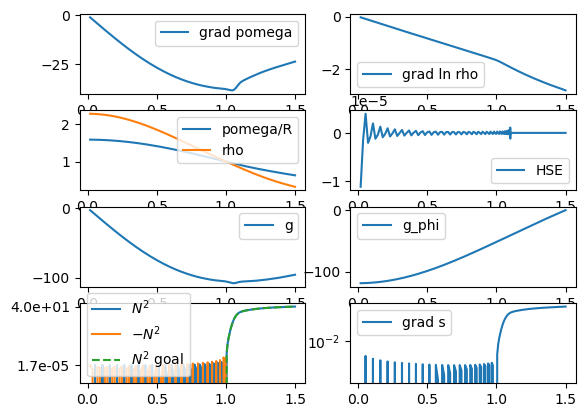

In [25]:
# print(nondim_G)
# g_phi_func = interpolations['g_phi']
atmo = HSE_solve(c, d, bases, grad_ln_rho_func, N2_func, F_conv_func,
              r_outer=r_bound_nd[-1], r_stitch=stitch_radii, \
              R=nondim_R_gas, gamma=nondim_gamma1, nondim_radius=1)

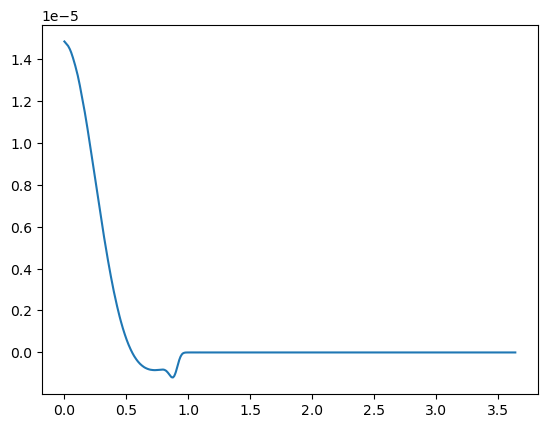

In [26]:
plt.plot(r_nd,atmo['Q'](r_nd))

### can skip this usually

In [27]:


def HSE_solve_test(coords, dist, bases, g_phi_func, grad_ln_rho_func, N2_func, Fconv_func, r_stitch=[], r_outer=1, low_nr=16, \
              R=1, gamma=5/3, G=1, nondim_radius=1, ncc_cutoff=1e-9, tolerance=1e-9, HSE_tolerance = 1e-4):
    """
    Solves for hydrostatic equilibrium in a calorically perfect ideal gas.
    The solution for density, entropy, and gravity is found given a specified function of N^2 and grad ln rho.
    The heating term associated with a convective luminosity is also found given a specified function of the convective flux, Fconv.

    Arguments
    ---------
    coords : Dedalus CoordinateSystem object
        The coordinate system in which the solution is found.
    dist : Dedalus Distributor object
        The distributor object associated with the bases; should NOT be in parallel.
    bases : dict
        A dictionary of Dedalus bases, with keys 'B', 'S1', 'S2', etc. for the Ball basis, first Shell basis, second Shell basis, etc.
    grad_ln_rho_func : function
        A function of radius that returns the gradient of the log of density. Input r should be nondimensionalized.
    N2_func : function
        A function of radius that returns the nondimensionalized Brunt-Vaisala frequency squared. Input r should be nondimensionalized.
    Fconv_func : function
        A function of radius that returns the nondimensionalized convective flux. Input r should be nondimensionalized.
    r_stitch : list
        A list of radii at which to stitch together the solutions from different bases. 
        The first element should be the radius of the outer boundary of the BallBasis.
        If there is only one basis, r_stitch should be an empty list.
    r_outer : float
        The radius of the outer boundary of the simulation domain.
    low_nr : int
        The number of radial points in the low resolution domain; used to set up background fields for solve. #TODO: make this by-basis.
    R : float
        The nondimensional value of the gas constant divided by the mean molecular weight.
    gamma : float
        The adiabatic index of the gas.
    nondim_radius : float
        The radius where thermodynamics are nondimensionalized.
    ncc_cutoff : float
        The NCC floor for the solver. See Dedalus.core.solvers.SolverBase
    tolerance : float
        The tolerance for perturbation norm of the newton iteration.
    HSE_tolerance : float
        The tolerance for hydrostatic equilibrium of the BVP solve.
    
    Returns
    -------
    atmosphere : dict
        A dictionary of interpolated functions which return atmospheric quantities as a function of nondimensional radius.
    """
    # Parameters
    namespace = dict()
    namespace['G'] = G
    namespace['R'] = R
    namespace['Cp'] = Cp = R*gamma/(gamma-1)
    namespace['gamma'] = gamma
    namespace['log'] = np.log
    namespace['exp'] = np.exp

    #Loop over bases, set up fields and operators.
    for k, basis in bases.items():
        namespace['basis_{}'.format(k)] = basis
        namespace['S2_basis_{}'.format(k)] = S2_basis = basis.S2_basis()

        # Make problem variables and taus.
        namespace['g_phi_{}'.format(k)] = g_phi = dist.Field(name='g_phi', bases=basis)
        namespace['Q_{}'.format(k)] = Q = dist.Field(name='Q', bases=basis)
        namespace['s_{}'.format(k)] = s = dist.Field(name='s', bases=basis)
        namespace['g_{}'.format(k)] = g = dist.VectorField(coords, name='g', bases=basis)
        namespace['ln_rho_{}'.format(k)] = ln_rho = dist.Field(name='ln_rho', bases=basis)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = dist.VectorField(coords, name='grad_ln_rho', bases=basis)
        namespace['tau_s_{}'.format(k)] = tau_s = dist.Field(name='tau_s', bases=S2_basis)
        namespace['tau_rho_{}'.format(k)] = tau_rho = dist.Field(name='tau_rho', bases=S2_basis)
        namespace['tau_g_phi_{}'.format(k)] = tau_g_phi = dist.Field(name='tau_g_phi', bases=S2_basis)
        namespace['tau_g_phi_1_{}'.format(k)] = tau_g_phi_1 = dist.Field(name='tau_g_phi_1', bases=S2_basis)
        namespace['tau_g_phi_2_{}'.format(k)] = tau_g_phi_2 = dist.Field(name='tau_g_phi_2', bases=S2_basis)

        # Set up some fundamental grid data
        low_scales = low_nr/basis.radial_basis.radial_size 
        phi, theta, r = dist.local_grids(basis)
        phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
        phi_low, theta_low, r_low = dist.local_grids(basis, scales=(1,1,low_scales))
        namespace['r_de_{}'.format(k)] = r_de
        namespace['r_vec_{}'.format(k)] = r_vec = dist.VectorField(coords, bases=basis.radial_basis)
        r_vec['g'][2] = r
        namespace['r_squared_{}'.format(k)] = r_squared = dist.Field(bases=basis.radial_basis)
        r_squared['g'] = r**2       

        # Make lift operators for BCs
        if k == 'B':
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis, -1)
        else:
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis.derivative_basis(2), -1)
            namespace['lift2_{}'.format(k)] = lift2 = lambda A: d3.Lift(A, basis.derivative_basis(2), -2)

        # Make a field of ones for converting NCCs to full fields.
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1

        #make a field of 4piG*ones
        namespace['four_pi_G_{}'.format(k)] = four_pi_G = dist.Field(bases=basis, name='four_pi_G')
        four_pi_G['g'] = 4*np.pi*G*ones['g']

        #Make a field that smooths at the edge of the ball basis.
        namespace['edge_smoothing_{}'.format(k)] = edge_smooth = dist.Field(bases=basis, name='edge_smooth')
        edge_smooth['g'] = one_to_zero(r, 0.95*bases['B'].radius, width=0.03*bases['B'].radius)

        # Get a high-resolution N^2 in the ball; low-resolution elsewhere where it transitions more gradually.
        namespace['N2_{}'.format(k)] = N2 = dist.Field(bases=basis, name='N2')
        if k == 'B':
            N2['g'] = N2_func(r)
        else:
            N2.change_scales(low_scales)
            N2['g'] = N2_func(r_low)

        #Set grad ln rho.
        grad_ln_rho.change_scales(low_scales)
        grad_ln_rho['g'][2] = grad_ln_rho_func(r_low)

        # Set the convective flux.
        namespace['Fconv_{}'.format(k)] = Fconv   = dist.VectorField(coords, name='Fconv', bases=basis)
        Fconv['g'][2] = Fconv_func(r)

        # set initial guess for g_phi
        namespace['g_phi_in_{}'.format(k)] = g_phi_in = dist.Field(bases=basis, name='g_phi_in')
        g_phi_in['g'] = g_phi_func(r)

        namespace['grad_s_in_{}'.format(k)] = grad_s_in = dist.VectorField(coords, name='grad_s_in', bases=basis)
        grad_s_in.change_scales(dealias)
        N2.change_scales(dealias)
        grad_s_in['g'][2] = Cp*N2['g']/d3.grad(g_phi_in)['g'][2]

        # Create important operations from the fields.
        namespace['ln_pomega_LHS_{}'.format(k)] = ln_pomega_LHS = gamma*(s/Cp + ((gamma-1)/gamma)*ln_rho*ones)
        namespace['ln_pomega_{}'.format(k)] = ln_pomega = ln_pomega_LHS + np.log(R)
        namespace['pomega_{}'.format(k)] = pomega = np.exp(ln_pomega)
        namespace['P_{}'.format(k)] = P = pomega*np.exp(ln_rho)
        namespace['HSE_{}'.format(k)] = HSE = gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) + d3.grad(g_phi)*ones
        namespace['N2_op_{}'.format(k)] = N2_op = d3.grad(g_phi)@d3.grad(s)/Cp
        namespace['rho_{}'.format(k)] = rho = np.exp(ln_rho*ones)
        namespace['T_{}'.format(k)] = T = pomega/R
        namespace['ln_T_{}'.format(k)] = ln_T = ln_pomega - np.log(R)
        namespace['grad_pomega_{}'.format(k)] = d3.grad(pomega)
        namespace['grad_ln_pomega_{}'.format(k)] = d3.grad(ln_pomega)
        namespace['grad_s_{}'.format(k)] = grad_s = d3.grad(s)
        namespace['r_vec_g_{}'.format(k)] = r_vec@g
        namespace['g_op_{}'.format(k)] = gamma * pomega * (grad_s/Cp + grad_ln_rho)
        namespace['s0_{}'.format(k)] = s0 = Cp * ((1/gamma)*(ln_pomega + ln_rho) - ln_rho) #s with an offset so s0 = cp * (1/gamma * lnP - ln_rho)
        # namespace['HSE_{}'.format(k)] = HSE = gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s0)/Cp) + d3.grad(g_phi)*ones
    namespace['pi'] = np.pi
    locals().update(namespace)

    #Solve for ln_rho.
    variables, taus = [], []
    for k, basis in bases.items():
        variables += [namespace['ln_rho_{}'.format(k)],namespace['s_{}'.format(k)],]
        taus      += [namespace['tau_rho_{}'.format(k)],namespace['tau_s_{}'.format(k)],]

    problem = d3.NLBVP(variables + taus, namespace=locals())
    for k, basis in bases.items():
        #Equation is just definitional.
        problem.add_equation("grad(ln_rho_{0}) - grad_ln_rho_{0} + r_vec_{0}*lift_{0}(tau_rho_{0}) = 0".format(k))
        problem.add_equation("grad(s_{0}) - grad_s_in_{0} + r_vec_{0}*lift_{0}(tau_s_{0}) = 0".format(k))
    
    #Set boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            problem.add_equation("ln_rho_{0}(r={2}) - ln_rho_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("s_{0}(r={2}) - s_{1}(r={2}) = 0".format(k, k_old, r_s))
        iter += 1
    problem.add_equation("ln_rho_B(r=nondim_radius) = 0")
    problem.add_equation("ln_pomega_LHS_B(r=nondim_radius) = 0")

    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance:
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
    logger.info('ln_rho and s found')

    # Solve for poisson equation given ln_rho.
    variables, taus = [], []
    for k, basis in bases.items():
        # variables += [namespace['s_{}'.format(k)], namespace['g_{}'.format(k)], namespace['Q_{}'.format(k)], namespace['g_phi_{}'.format(k)]]
        # taus += [namespace['tau_s_{}'.format(k)], namespace['tau_g_phi_{}'.format(k)]]
        # variables += [namespace['ln_rho_{}'.format(k)],namespace['s_{}'.format(k)], namespace['g_{}'.format(k)], namespace['Q_{}'.format(k)],]
                      # namespace['g_phi_{}'.format(k)]]
        variables += [namespace['g_phi_{}'.format(k)],]
        # taus += [namespace['tau_s_{}'.format(k)], namespace['tau_g_phi_1_{}'.format(k)],]
                #   namespace['tau_g_phi_{}'.format(k)]]
        taus += [namespace['tau_g_phi_1_{}'.format(k)],]
        if k != 'B':
            taus += [namespace['tau_g_phi_2_{}'.format(k)],]
    print('variables',len(variables),'taus',len(taus))
    problem = d3.NLBVP(variables + taus, namespace=locals())
    count_eqn = 0
    for k, basis in bases.items():
       
        # # set initial guess for g_phi
        # namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        # namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        # namespace['g_phi_{}'.format(k)]['g'] = (namespace['g_phi_in_{}'.format(k)]).evaluate()['g']
        #Set the equations: poisson
        # problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0}) + lift_{0}(tau_g_phi_1_{0}) = 0".format(k))
        if k != 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0}) + lift_{0}(tau_g_phi_1_{0}) + lift2_{0}(tau_g_phi_2_{0}) = 0".format(k))
            count_eqn+=1
        elif k == 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0})  + lift_{0}(tau_g_phi_1_{0}) = 0".format(k))
            count_eqn+=1
    
    #Set the boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            # problem.add_equation("ln_rho_{0}(r={2}) - ln_rho_{1}(r={2}) = 0".format(k, k_old, r_s))
            # problem.add_equation("s_{0}(r={2}) - s_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("g_phi_{0}(r={2}) - g_phi_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("grad(g_phi_{0})(r={2}) - grad(g_phi_{1})(r={2}) = 0".format(k, k_old, r_s))
            count_eqn+=2
            # problem.add_equation("g_{0}(r={2}) - g_{1}(r={2}) = 0".format(k, k_old, r_s))
        iter += 1
        if iter == len(bases.items()):
            problem.add_equation("g_phi_{0}(r=r_outer) = g_phi_in_{0}(r=r_outer)".format(k))
            count_eqn+=1
    
    # problem.add_equation("ln_pomega_LHS_B(r=nondim_radius) = 0")
    # problem.add_equation("ln_rho_B(r=nondim_radius) = 0")
    # problem.add_equation("g_phi_B(r=nondim_radius) = four_pi_G_B(r=nondim_radius)/3")
    # count_eqn+=1
    print('number of eqns',count_eqn)

    #Solve with tolerances on pert_norm and hydrostatic equilibrium.
    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance:
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
    logger.info('g_phi found')
    logger.info(f'Perturbation norm: {pert_norm:.3e}')
    for k, basis in bases.items():
        namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_{}'.format(k)]['g'][0,0,:],label='g_phi',c='blue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_in_{}'.format(k)]['g'][0,0,:],label='g_phi in',c='salmon',ls=':')

        namespace['g_{}'.format(k)] = -d3.grad(namespace['g_phi_{}'.format(k)])
        namespace['grad_s_{}'.format(k)] = grad_s = d3.grad(namespace['s0_{}'.format(k)])
    
    plt.figure()
    for k, basis in bases.items():
        plt.ylabel(r'HSE')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['HSE_{}'.format(k)]['g'][2,0,0,:],label='HSE',c='cornflowerblue')
    plt.legend()
    plt.show()
    # Stitch together the fields for creation of interpolators that span the full simulation domain.
    #Need: grad_pom0, grad_ln_pom0, grad_ln_rho0, grad_s0, g, pom0, rho0, ln_rho0, g_phi
    stitch_fields = OrderedDict()
    fields = ['grad_pomega', 'grad_ln_pomega', 'grad_ln_rho', 'grad_s', 'g', 'pomega', 'rho', 'ln_rho', 'g_phi', 'r_vec', 'HSE', 'N2_op', 'Q', 's0']
    for f in fields:
        stitch_fields[f] = []
    
    for k, basis in bases.items():
        for f in fields:
            stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'])]

    if len(stitch_fields['r_vec']) == 1:
        for f in fields:
            stitch_fields[f] = stitch_fields[f][0]
    else:
        for f in fields:
            stitch_fields[f] = np.concatenate(stitch_fields[f], axis=-1)

    grad_pom = stitch_fields['grad_pomega'][2,:].ravel()
    grad_ln_pom = stitch_fields['grad_ln_pomega'][2,:].ravel()
    grad_ln_rho = stitch_fields['grad_ln_rho'][2,:].ravel()
    grad_s = stitch_fields['grad_s'][2,:].ravel()
    g = stitch_fields['g'][2,:].ravel()
    HSE = stitch_fields['HSE'][2,:].ravel()
    r = stitch_fields['r_vec'][2,:].ravel()

    pom = stitch_fields['pomega'].ravel()
    rho = stitch_fields['rho'].ravel()
    ln_rho = stitch_fields['ln_rho'].ravel()
    g_phi = stitch_fields['g_phi'].ravel()
    N2 = stitch_fields['N2_op'].ravel()
    Q = stitch_fields['Q'].ravel()
    s0 = stitch_fields['s0'].ravel()


    #Plot the results.
    fig = plt.figure()
    ax1 = fig.add_subplot(4,2,1)
    ax2 = fig.add_subplot(4,2,2)
    ax3 = fig.add_subplot(4,2,3)
    ax4 = fig.add_subplot(4,2,4)
    ax5 = fig.add_subplot(4,2,5)
    ax6 = fig.add_subplot(4,2,6)
    ax7 = fig.add_subplot(4,2,7)
    ax8 = fig.add_subplot(4,2,8)
    ax1.plot(r, grad_pom, label='grad pomega')
    ax1.legend()
    ax2.plot(r, grad_ln_rho, label='grad ln rho')
    ax2.legend()
    ax3.plot(r, pom/R, label='pomega/R')
    ax3.plot(r, rho, label='rho')
    ax3.legend()
    ax4.plot(r, HSE, label='HSE')
    ax4.legend()
    ax5.plot(r, g, label='g')
    ax5.legend()
    ax6.plot(r, g_phi, label='g_phi')
    ax6.legend()
    ax7.plot(r, N2, label=r'$N^2$')
    ax7.plot(r, -N2, label=r'$-N^2$')
    ax7.plot(r, (N2_func(r)), label=r'$N^2$ goal', ls='--')
    ax7.set_yscale('log')
    yticks = (np.max(np.abs(N2.ravel()[r.ravel() < 0.5])), np.max(N2_func(r).ravel()))
    ax7.set_yticks(yticks)
    ax7.set_yticklabels(['{:.1e}'.format(n) for n in yticks])
    ax7.legend()
    ax8.plot(r, grad_s, label='grad s')
    ax8.set_yscale('log')
    ax8.legend()
    # fig.savefig('stratification.png', bbox_inches='tight', dpi=300)

    #Create interpolators for the atmosphere.
    atmosphere = dict()
    atmosphere['grad_pomega'] = interp1d(r, grad_pom, **interp_kwargs)
    atmosphere['grad_ln_pomega'] = interp1d(r, grad_ln_pom, **interp_kwargs)
    atmosphere['grad_ln_rho'] = interp1d(r, grad_ln_rho, **interp_kwargs)
    atmosphere['grad_s'] = interp1d(r, grad_s, **interp_kwargs)
    atmosphere['g'] = interp1d(r, g, **interp_kwargs)
    atmosphere['pomega'] = interp1d(r, pom, **interp_kwargs)
    atmosphere['rho'] = interp1d(r, rho, **interp_kwargs)
    atmosphere['ln_rho'] = interp1d(r, ln_rho, **interp_kwargs)
    atmosphere['g_phi'] = interp1d(r, g_phi, **interp_kwargs)
    atmosphere['N2'] = interp1d(r, N2, **interp_kwargs)
    # atmosphere['Q'] = interp1d(r, Q, **interp_kwargs)
    atmosphere['s0'] = interp1d(r, s0, **interp_kwargs)
    return g_phi


2024-12-02 11:16:22,413 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s
2024-12-02 11:16:22,415 __main__ 0/1 INFO :: Perturbation norm: 1.991e+01
2024-12-02 11:16:22,704 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2024-12-02 11:16:22,706 __main__ 0/1 INFO :: Perturbation norm: 2.892e-02
2024-12-02 11:16:22,995 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2024-12-02 11:16:22,996 __main__ 0/1 INFO :: Perturbation norm: 6.718e-04
2024-12-02 11:16:23,291 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2024-12-02 11:16:23,292 __main__ 0/1 INFO :: Perturbation norm: 1.561e-05
2024-12-02 11:16:23,587 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s
2024-12-02 11:16:23,588 __main__ 0/1 INFO ::

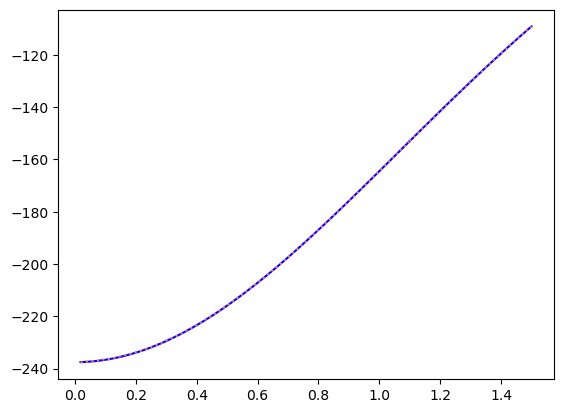

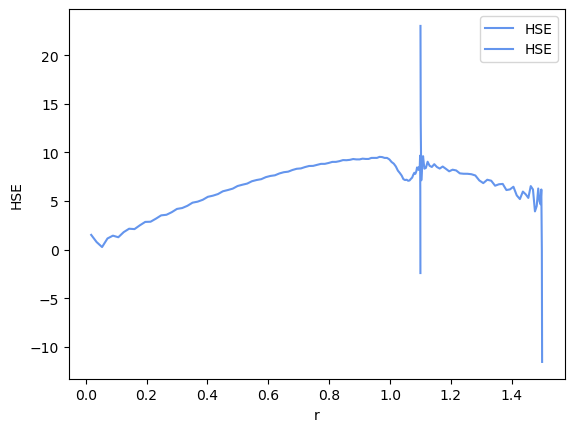

[]

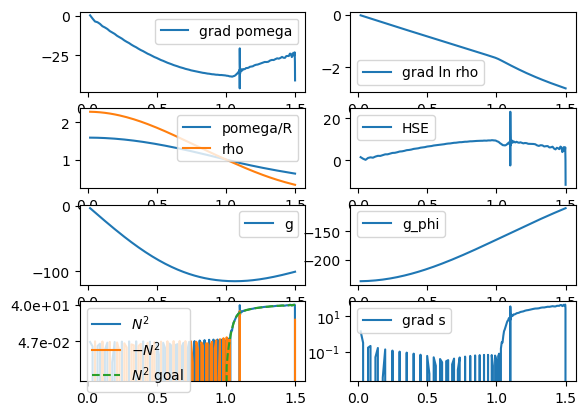

In [28]:
# print(nondim_G)
# Solve for hydrostatic equilibrium for background
N2_func = interp1d(r_nd, tau_nd**2 * smooth_N2, **interp_kwargs)
grad_ln_rho_func = interpolations['grad_ln_rho0']
g_phi_func = interpolations['g_phi']
g_phi = HSE_solve_test(c, d, bases, g_phi_func, grad_ln_rho_func, N2_func, F_conv_func,
              r_outer=r_bound_nd[-1], r_stitch=stitch_radii, \
              R=nondim_R_gas, gamma=nondim_gamma1, G=nondim_G, nondim_radius=1)
plt.plot()

In [29]:
r_bound_nd[-1]

1.5

### new HSE solve that works for CZ

In [30]:


def HSE_solve_test2(coords, dist, bases, g_phi_func, grad_ln_rho_func, ln_rho_func, N2_func, Fconv_func, r_stitch=[], r_outer=1, low_nr=16, \
              R=1, gamma=5/3, G=1, nondim_radius=1, ncc_cutoff=1e-9, tolerance=1e-9, HSE_tolerance = 1e-4):
    """
    Solves for hydrostatic equilibrium in a calorically perfect ideal gas.
    The solution for density, entropy, and gravity is found given a specified function of N^2 and grad ln rho.
    The heating term associated with a convective luminosity is also found given a specified function of the convective flux, Fconv.

    Arguments
    ---------
    coords : Dedalus CoordinateSystem object
        The coordinate system in which the solution is found.
    dist : Dedalus Distributor object
        The distributor object associated with the bases; should NOT be in parallel.
    bases : dict
        A dictionary of Dedalus bases, with keys 'B', 'S1', 'S2', etc. for the Ball basis, first Shell basis, second Shell basis, etc.
    grad_ln_rho_func : function
        A function of radius that returns the gradient of the log of density. Input r should be nondimensionalized.
    N2_func : function
        A function of radius that returns the nondimensionalized Brunt-Vaisala frequency squared. Input r should be nondimensionalized.
    Fconv_func : function
        A function of radius that returns the nondimensionalized convective flux. Input r should be nondimensionalized.
    r_stitch : list
        A list of radii at which to stitch together the solutions from different bases. 
        The first element should be the radius of the outer boundary of the BallBasis.
        If there is only one basis, r_stitch should be an empty list.
    r_outer : float
        The radius of the outer boundary of the simulation domain.
    low_nr : int
        The number of radial points in the low resolution domain; used to set up background fields for solve. #TODO: make this by-basis.
    R : float
        The nondimensional value of the gas constant divided by the mean molecular weight.
    gamma : float
        The adiabatic index of the gas.
    nondim_radius : float
        The radius where thermodynamics are nondimensionalized.
    ncc_cutoff : float
        The NCC floor for the solver. See Dedalus.core.solvers.SolverBase
    tolerance : float
        The tolerance for perturbation norm of the newton iteration.
    HSE_tolerance : float
        The tolerance for hydrostatic equilibrium of the BVP solve.
    
    Returns
    -------
    atmosphere : dict
        A dictionary of interpolated functions which return atmospheric quantities as a function of nondimensional radius.
    """
    # Parameters
    namespace = dict()
    namespace['G'] = G
    namespace['R'] = R
    namespace['Cp'] = Cp = R*gamma/(gamma-1)
    namespace['gamma'] = gamma
    namespace['log'] = np.log
    namespace['exp'] = np.exp

    #Loop over bases, set up fields and operators.
    for k, basis in bases.items():
        namespace['basis_{}'.format(k)] = basis
        namespace['S2_basis_{}'.format(k)] = S2_basis = basis.S2_basis()

        # Make problem variables and taus.
        namespace['g_phi_{}'.format(k)] = g_phi = dist.Field(name='g_phi', bases=basis)
        namespace['Q_{}'.format(k)] = Q = dist.Field(name='Q', bases=basis)
        namespace['s_{}'.format(k)] = s = dist.Field(name='s', bases=basis)
        namespace['g_{}'.format(k)] = g = dist.VectorField(coords, name='g', bases=basis)
        namespace['ln_rho_{}'.format(k)] = ln_rho = dist.Field(name='ln_rho', bases=basis)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = dist.VectorField(coords, name='grad_ln_rho', bases=basis)
        namespace['tau_s_{}'.format(k)] = tau_s = dist.Field(name='tau_s', bases=S2_basis)
        namespace['tau_rho_{}'.format(k)] = tau_rho = dist.Field(name='tau_rho', bases=S2_basis)
        namespace['tau_g_phi_{}'.format(k)] = tau_g_phi = dist.Field(name='tau_g_phi', bases=S2_basis)
        namespace['tau_g_phi_1_{}'.format(k)] = tau_g_phi_1 = dist.Field(name='tau_g_phi_1', bases=S2_basis)
        namespace['tau_g_phi_2_{}'.format(k)] = tau_g_phi_2 = dist.Field(name='tau_g_phi_2', bases=S2_basis)

        # Set up some fundamental grid data
        low_scales = low_nr/basis.radial_basis.radial_size 
        phi, theta, r = dist.local_grids(basis)
        phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
        phi_low, theta_low, r_low = dist.local_grids(basis, scales=(1,1,low_scales))
        namespace['r_de_{}'.format(k)] = r_de
        namespace['r_vec_{}'.format(k)] = r_vec = dist.VectorField(coords, bases=basis.radial_basis)
        r_vec['g'][2] = r
        namespace['r_squared_{}'.format(k)] = r_squared = dist.Field(bases=basis.radial_basis)
        r_squared['g'] = r**2       

        # Make lift operators for BCs
        if k == 'B':
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis, -1)
        else:
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis.derivative_basis(2), -1)
            namespace['lift2_{}'.format(k)] = lift2 = lambda A: d3.Lift(A, basis.derivative_basis(2), -2)

        # Make a field of ones for converting NCCs to full fields.
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1

        #make a field of 4piG*ones
        namespace['four_pi_G_{}'.format(k)] = four_pi_G = dist.Field(bases=basis, name='four_pi_G')
        four_pi_G['g'] = 4*np.pi*G*ones['g']

        #Make a field that smooths at the edge of the ball basis.
        namespace['edge_smoothing_{}'.format(k)] = edge_smooth = dist.Field(bases=basis, name='edge_smooth')
        edge_smooth['g'] = one_to_zero(r, 0.95*bases['B'].radius, width=0.03*bases['B'].radius)

        # Get a high-resolution N^2 in the ball; low-resolution elsewhere where it transitions more gradually.
        namespace['N2_{}'.format(k)] = N2 = dist.Field(bases=basis, name='N2')
        if k == 'B':
            N2['g'] = N2_func(r)
        else:
            N2.change_scales(low_scales)
            N2['g'] = N2_func(r_low)
        # print(N2['g'])
        #Set grad ln rho.
        # grad_ln_rho.change_scales(low_scales)
        # grad_ln_rho['g'][2] = grad_ln_rho_func(r_low)
        # grad_ln_rho['g'][2] = grad_ln_rho_func(r)
            
            
        # Set ln rho initial guess.
        namespace['ln_rho_in_{}'.format(k)] = ln_rho_in = dist.Field(bases=basis, name='ln_rho_in')
        ln_rho_in['g'] = ln_rho_func(r)

        # Set the convective flux.
        namespace['Fconv_{}'.format(k)] = Fconv   = dist.VectorField(coords, name='Fconv', bases=basis)
        Fconv['g'][2] = Fconv_func(r)

        # set initial guess for g_phi
        namespace['g_phi_in_{}'.format(k)] = g_phi_in = dist.Field(bases=basis, name='g_phi_in')
        g_phi_in['g'] = g_phi_func(r)


        # Create important operations from the fields.
        namespace['ln_pomega_LHS_{}'.format(k)] = ln_pomega_LHS = gamma*(s/Cp + ((gamma-1)/gamma)*ln_rho*ones)
        namespace['ln_pomega_{}'.format(k)] = ln_pomega = ln_pomega_LHS + np.log(R)
        namespace['pomega_{}'.format(k)] = pomega = np.exp(ln_pomega)
        namespace['P_{}'.format(k)] = P = pomega*np.exp(ln_rho)
        namespace['HSE_{}'.format(k)] = HSE = gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) + d3.grad(g_phi)*ones
        #gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) - g*ones
        namespace['N2_op_{}'.format(k)] = N2_op = d3.grad(g_phi)@d3.grad(s)/Cp
        namespace['rho_{}'.format(k)] = rho = np.exp(ln_rho*ones)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = d3.grad(ln_rho)
        namespace['T_{}'.format(k)] = T = pomega/R
        namespace['ln_T_{}'.format(k)] = ln_T = ln_pomega - np.log(R)
        namespace['grad_pomega_{}'.format(k)] = d3.grad(pomega)
        namespace['grad_ln_pomega_{}'.format(k)] = d3.grad(ln_pomega)
        namespace['grad_s_{}'.format(k)] = grad_s = d3.grad(s)
        namespace['r_vec_g_{}'.format(k)] = r_vec@g
        namespace['g_op_{}'.format(k)] = gamma * pomega * (grad_s/Cp + grad_ln_rho)
        namespace['s0_{}'.format(k)] = Cp * ((1/gamma)*(ln_pomega + ln_rho) - ln_rho) #s with an offset so s0 = cp * (1/gamma * lnP - ln_rho)

    namespace['pi'] = np.pi
    locals().update(namespace)
    


    # Solve for poisson equation given ln_rho.
    variables, taus = [], []
    for k, basis in bases.items():
        variables += [namespace['g_phi_{}'.format(k)],namespace['s_{}'.format(k)],namespace['ln_rho_{}'.format(k)],namespace['Q_{}'.format(k)], ]#,namespace['ln_rho_{}'.format(k)],]
        
        taus += [ namespace['tau_g_phi_1_{}'.format(k)],namespace['tau_s_{}'.format(k)], namespace['tau_g_phi_{}'.format(k)]] #namespace['tau_g_phi_{}'.format(k)],namespace['tau_s_{}'.format(k)],
        if k != 'B':
            taus += [namespace['tau_g_phi_2_{}'.format(k)],]
        # variables += [namespace['s_{}'.format(k)],]
        
        # taus += [namespace['tau_s_{}'.format(k)], ]

    print('variables',len(variables),'taus',len(taus))
    problem = d3.NLBVP(variables + taus, namespace=locals())
    count_eqn = 0
    for k, basis in bases.items():
    
        # Set a decent initial guess for s.
        # namespace['s_{}'.format(k)].change_scales(basis.dealias)
        # namespace['s_{}'.format(k)]['g'] = -(R*namespace['ln_rho_in_{}'.format(k)]).evaluate()['g']
        # Set a decent initial guess for ln_rho.
        namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_{}'.format(k)]['g'] = np.copy(namespace['ln_rho_in_{}'.format(k)]['g'])
       
        # set initial guess for g_phi
        namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_{}'.format(k)]['g'] = (namespace['g_phi_in_{}'.format(k)]).evaluate()['g']
        #Set the equations: poisson
        if k != 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0}) + lift_{0}(tau_g_phi_1_{0}) + lift2_{0}(tau_g_phi_2_{0}) = 0".format(k))
            count_eqn+=1
        elif k == 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0})  + lift_{0}(tau_g_phi_1_{0}) = 0".format(k))
            count_eqn+=1
        
        #Set the equations: hydrostatic equilibrium
        problem.add_equation("-grad(g_phi_{0}) + r_vec_{0}*lift_{0}(tau_g_phi_{0}) = g_op_{0} ".format(k))
        # problem.add_equation("grad(ln_rho_{0})@(grad(s_{0})/Cp) + lift_{0}(tau_s_{0}) = -N2_{0}/(gamma*pomega_{0}) - grad(s_{0})@grad(s_{0}) / Cp**2".format(k))
        problem.add_equation("grad(g_phi_{0})@grad(s_{0}) / Cp + lift_{0}(tau_s_{0}) = N2_{0}".format(k))
        count_eqn+=2
        #Set equation for heating
        problem.add_equation("Q_{0} = edge_smoothing_{0}*div(Fconv_{0})".format(k))
        count_eqn+=1
    
    #Set the boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            problem.add_equation("ln_rho_{0}(r={2}) - ln_rho_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("s_{0}(r={2}) - s_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("g_phi_{0}(r={2}) - g_phi_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("grad(g_phi_{0})(r={2}) - grad(g_phi_{1})(r={2}) = 0".format(k, k_old, r_s))
            count_eqn+=4
        iter += 1
        if iter == len(bases.items()):
            # problem.add_equation("g_phi_{0}(r=r_outer) = g_phi_in_{0}(r=r_outer)".format(k))
            problem.add_equation("g_phi_{0}(r=r_outer) = 0".format(k))
            count_eqn+=1
    
    problem.add_equation("ln_pomega_LHS_B(r=nondim_radius) = 0")
    problem.add_equation("ln_rho_B(r=nondim_radius) = 0")
    count_eqn+=2
    print('number of eqns',count_eqn)

    #Solve with tolerances on pert_norm and hydrostatic equilibrium.
    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance or HSE_err > HSE_tolerance:

        plt.figure()
        for k, basis in bases.items():
            plt.ylabel(r'HSE')
            plt.xlabel(r'r')
            plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['HSE_{}'.format(k)]['g'][2,0,0,:],label='HSE',c='cornflowerblue')
        plt.legend()
        plt.show()
        HSE_err = 0
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
        for k, basis in bases.items():
            this_HSE = np.max(np.abs(namespace['HSE_{}'.format(k)].evaluate()['g']))
            logger.info('HSE in {}:{:.3e}'.format(k, this_HSE))
            if this_HSE > HSE_err:
                HSE_err = this_HSE

    plt.figure()
    for k, basis in bases.items():
        namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_{}'.format(k)] = -d3.grad(namespace['g_phi_{}'.format(k)])
        plt.ylabel(r'$\Phi_g$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_{}'.format(k)]['g'][0,0,:],label='g_phi',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_in_{}'.format(k)]['g'][0,0,:],label='g_phi in',c='salmon',ls=':')
        plt.legend()
    plt.figure()
    for k, basis in bases.items():
        namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
        
        plt.ylabel(r'$\ln \rho$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_{}'.format(k)]['g'][0,0,:],label='ln_rho',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_in_{}'.format(k)]['g'][0,0,:],label='ln_rho in',c='salmon',ls=':')
        plt.legend()
    plt.figure()
    for k, basis in bases.items():
        plt.ylabel(r'$s$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['s_{}'.format(k)]['g'][0,0,:],label='s',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], -(R*namespace['ln_rho_{}'.format(k)]).evaluate()['g'][0,0,:],label='s in',c='salmon',ls=':')
    plt.legend()

    # Stitch together the fields for creation of interpolators that span the full simulation domain.
    #Need: grad_pom0, grad_ln_pom0, grad_ln_rho0, grad_s0, g, pom0, rho0, ln_rho0, g_phi
    stitch_fields = OrderedDict()
    fields = ['grad_pomega', 'grad_ln_pomega', 'grad_ln_rho', 'grad_s', 'g', 'pomega', 'rho', 'ln_rho', 'g_phi', 'r_vec', 'HSE', 'N2_op', 'Q', 's0']
    for f in fields:
        stitch_fields[f] = []
    
    for k, basis in bases.items():
        for f in fields:
            stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'])]

    if len(stitch_fields['r_vec']) == 1:
        for f in fields:
            stitch_fields[f] = stitch_fields[f][0]
    else:
        for f in fields:
            stitch_fields[f] = np.concatenate(stitch_fields[f], axis=-1)

    grad_pom = stitch_fields['grad_pomega'][2,:].ravel()
    grad_ln_pom = stitch_fields['grad_ln_pomega'][2,:].ravel()
    grad_ln_rho = stitch_fields['grad_ln_rho'][2,:].ravel()
    grad_s = stitch_fields['grad_s'][2,:].ravel()
    g = stitch_fields['g'][2,:].ravel()
    HSE = stitch_fields['HSE'][2,:].ravel()
    r = stitch_fields['r_vec'][2,:].ravel()

    pom = stitch_fields['pomega'].ravel()
    rho = stitch_fields['rho'].ravel()
    ln_rho = stitch_fields['ln_rho'].ravel()
    g_phi = stitch_fields['g_phi'].ravel()
    N2 = stitch_fields['N2_op'].ravel()
    Q = stitch_fields['Q'].ravel()
    s0 = stitch_fields['s0'].ravel()


    #Plot the results.
    fig = plt.figure()
    ax1 = fig.add_subplot(4,2,1)
    ax2 = fig.add_subplot(4,2,2)
    ax3 = fig.add_subplot(4,2,3)
    ax4 = fig.add_subplot(4,2,4)
    ax5 = fig.add_subplot(4,2,5)
    ax6 = fig.add_subplot(4,2,6)
    ax7 = fig.add_subplot(4,2,7)
    ax8 = fig.add_subplot(4,2,8)
    ax1.plot(r, grad_pom, label='grad pomega')
    ax1.legend()
    ax2.plot(r, grad_ln_rho, label='grad ln rho')
    ax2.legend()
    ax3.plot(r, pom/R, label='pomega/R')
    ax3.plot(r, rho, label='rho')
    ax3.legend()
    ax4.plot(r, HSE, label='HSE')
    ax4.legend()
    ax5.plot(r, g, label='g')
    ax5.legend()
    ax6.plot(r, g_phi, label='g_phi')
    ax6.legend()
    ax7.plot(r, N2, label=r'$N^2$')
    ax7.plot(r, -N2, label=r'$-N^2$')
    ax7.plot(r, (N2_func(r)), label=r'$N^2$ goal', ls='--')
    ax7.set_yscale('log')
    yticks = (np.max(np.abs(N2.ravel()[r.ravel() < 0.5])), np.max(N2_func(r).ravel()))
    ax7.set_yticks(yticks)
    ax7.set_yticklabels(['{:.1e}'.format(n) for n in yticks])
    ax7.legend()
    ax8.plot(r, grad_s, label='grad s')
    ax8.set_yscale('log')
    ax8.legend()
    # fig.savefig('stratification.png', bbox_inches='tight', dpi=300)

    #Create interpolators for the atmosphere.
    atmosphere = dict()
    atmosphere['grad_pomega'] = interp1d(r, grad_pom, **interp_kwargs)
    atmosphere['grad_ln_pomega'] = interp1d(r, grad_ln_pom, **interp_kwargs)
    atmosphere['grad_ln_rho'] = interp1d(r, grad_ln_rho, **interp_kwargs)
    atmosphere['grad_s'] = interp1d(r, grad_s, **interp_kwargs)
    atmosphere['g'] = interp1d(r, g, **interp_kwargs)
    atmosphere['pomega'] = interp1d(r, pom, **interp_kwargs)
    atmosphere['rho'] = interp1d(r, rho, **interp_kwargs)
    atmosphere['ln_rho'] = interp1d(r, ln_rho, **interp_kwargs)
    atmosphere['g_phi'] = interp1d(r, g_phi, **interp_kwargs)
    atmosphere['N2'] = interp1d(r, N2, **interp_kwargs)
    atmosphere['Q'] = interp1d(r, Q, **interp_kwargs)
    atmosphere['s0'] = interp1d(r, s0, **interp_kwargs)
    return atmosphere

variables 8 taus 7
number of eqns 15


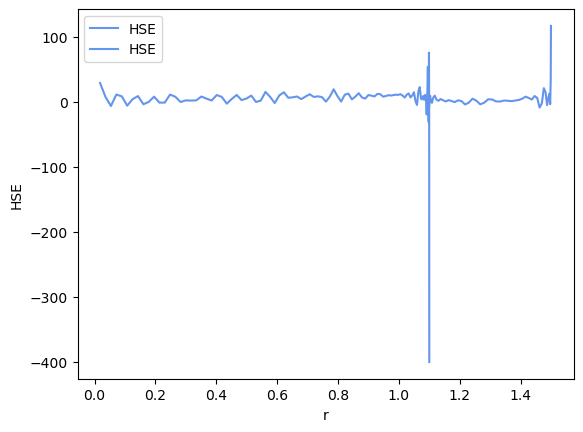

2024-12-02 11:16:27,106 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.0e-01/s
2024-12-02 11:16:27,110 __main__ 0/1 INFO :: Perturbation norm: 3.771e+02
2024-12-02 11:16:27,112 __main__ 0/1 INFO :: HSE in B:2.572e+00
2024-12-02 11:16:27,124 __main__ 0/1 INFO :: HSE in S1:1.382e+00


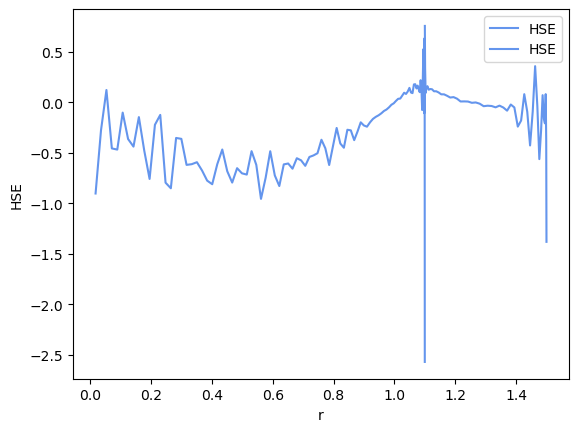

2024-12-02 11:16:28,550 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.6e-01/s
2024-12-02 11:16:28,554 __main__ 0/1 INFO :: Perturbation norm: 1.260e+00
2024-12-02 11:16:28,556 __main__ 0/1 INFO :: HSE in B:1.937e-02
2024-12-02 11:16:28,568 __main__ 0/1 INFO :: HSE in S1:8.899e-02


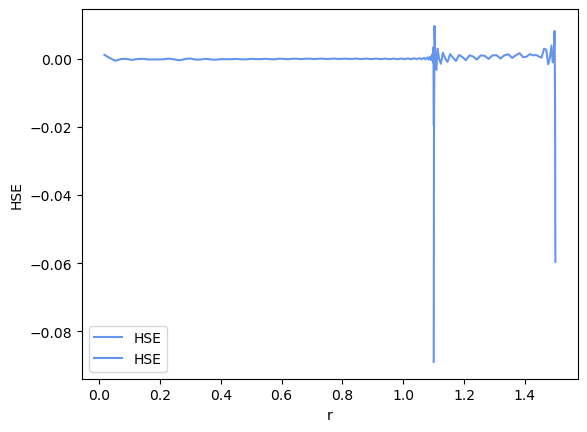

2024-12-02 11:16:29,959 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.9e-01/s
2024-12-02 11:16:29,964 __main__ 0/1 INFO :: Perturbation norm: 7.720e-03
2024-12-02 11:16:29,966 __main__ 0/1 INFO :: HSE in B:1.837e-05
2024-12-02 11:16:29,977 __main__ 0/1 INFO :: HSE in S1:1.387e-03


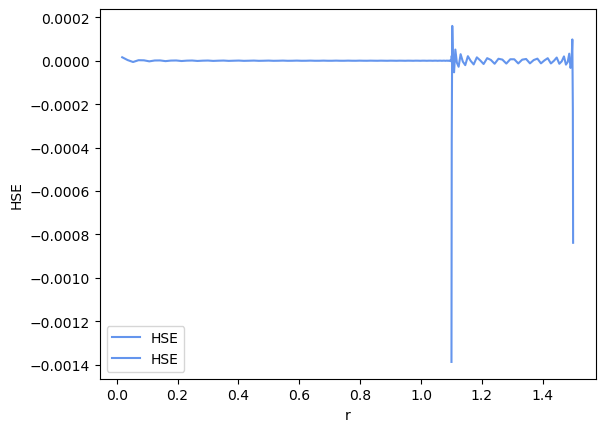

2024-12-02 11:16:31,377 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.9e-01/s
2024-12-02 11:16:31,381 __main__ 0/1 INFO :: Perturbation norm: 7.685e-05
2024-12-02 11:16:31,383 __main__ 0/1 INFO :: HSE in B:6.895e-07
2024-12-02 11:16:31,394 __main__ 0/1 INFO :: HSE in S1:2.016e-05


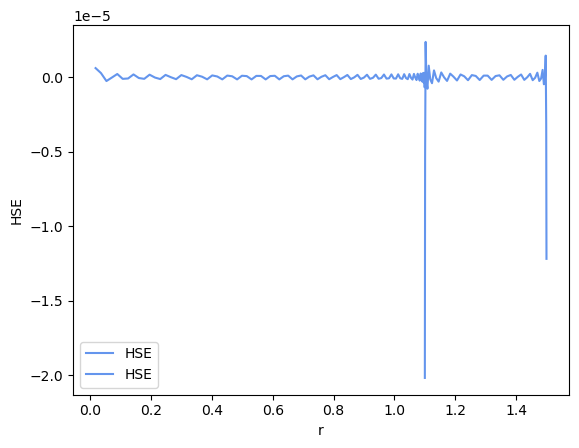

2024-12-02 11:16:32,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.1e-01/s
2024-12-02 11:16:32,744 __main__ 0/1 INFO :: Perturbation norm: 3.640e-06
2024-12-02 11:16:32,747 __main__ 0/1 INFO :: HSE in B:6.916e-07
2024-12-02 11:16:32,757 __main__ 0/1 INFO :: HSE in S1:2.881e-07


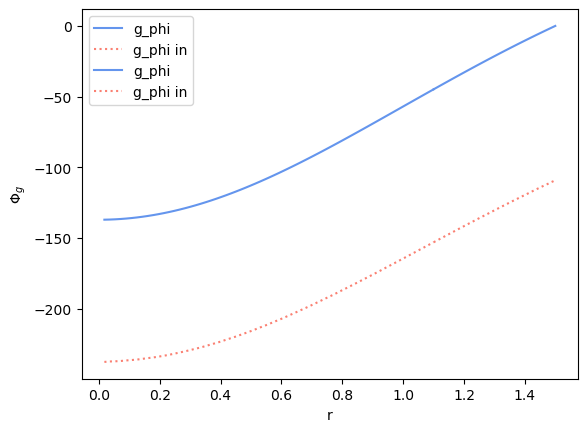

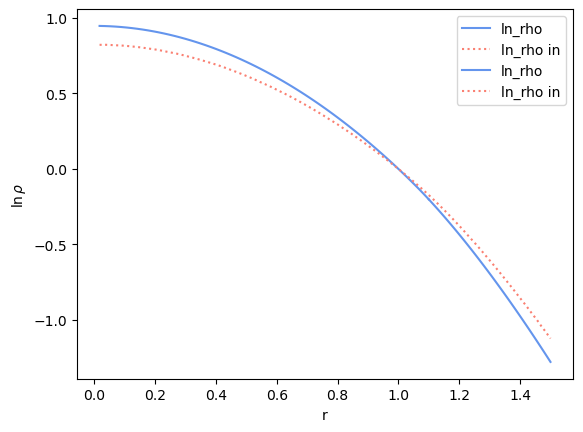

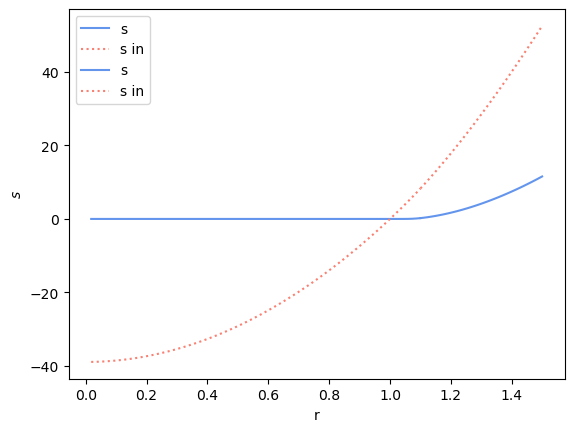

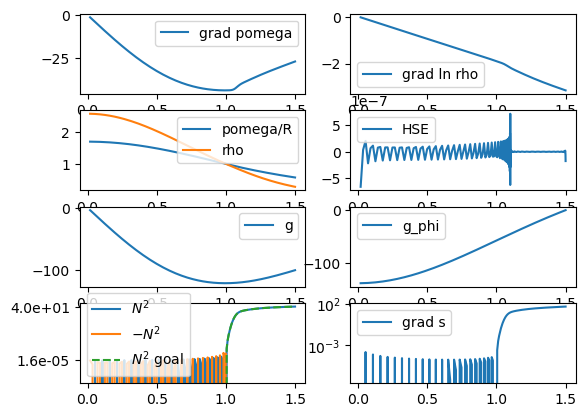

In [31]:
# print(nondim_G)
# Solve for hydrostatic equilibrium for background
N2_func = interp1d(r_nd, tau_nd**2 * smooth_N2, **interp_kwargs)
grad_ln_rho_func = interpolations['grad_ln_rho0']
ln_rho_func = interpolations['ln_rho0']
g_phi_func = interpolations['g_phi']
atmo_test=HSE_solve_test2(c, d, bases, g_phi_func, grad_ln_rho_func, ln_rho_func, N2_func, F_conv_func,
              r_outer=r_bound_nd[-1], r_stitch=stitch_radii, \
              R=nondim_R_gas, gamma=nondim_gamma1, G=nondim_G, nondim_radius=1,tolerance=1e-5, HSE_tolerance = 1e-4)

### Compare new HSE solve to old one

In [32]:
r_bounds[-1]/L_nd

<Quantity 1.5>

Text(0.5, 0, 'r')

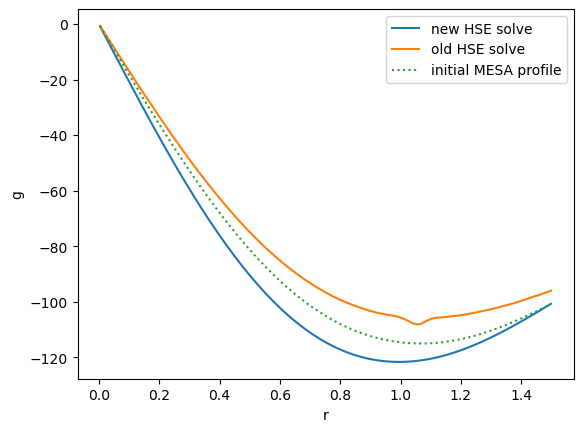

In [33]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='initial MESA profile',ls=':')
plt.legend()
plt.ylabel('g')
plt.xlabel('r')

Text(0, 0.5, '$\\Phi_g$')

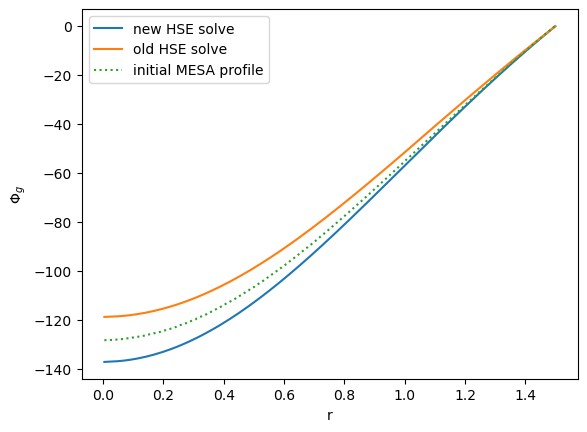

In [34]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])-interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])[-1],label='initial MESA profile',ls=':')
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\Phi_g$')

Text(0.5, 0, 'r')

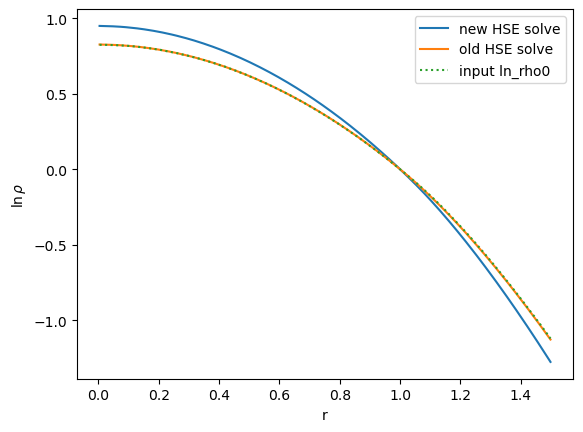

In [35]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['ln_rho0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='input ln_rho0',ls=':')
plt.legend()
plt.ylabel(r'$\ln \rho$')
plt.xlabel('r')

Text(0.5, 0, 'r')

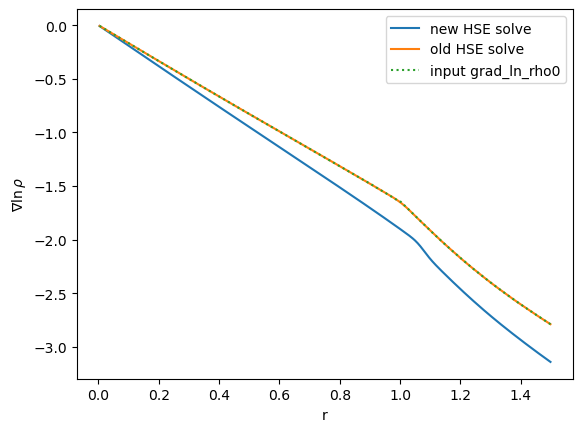

In [36]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['grad_ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['grad_ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.plot(r_nd[r_nd < 1.5],interpolations['grad_ln_rho0'](r_nd)[r_nd<1.5],label='input grad_ln_rho0',ls=':')
plt.legend()
plt.ylabel(r'$\nabla \ln \rho$')
plt.xlabel('r')

Text(0, 0.5, '$N^2$')

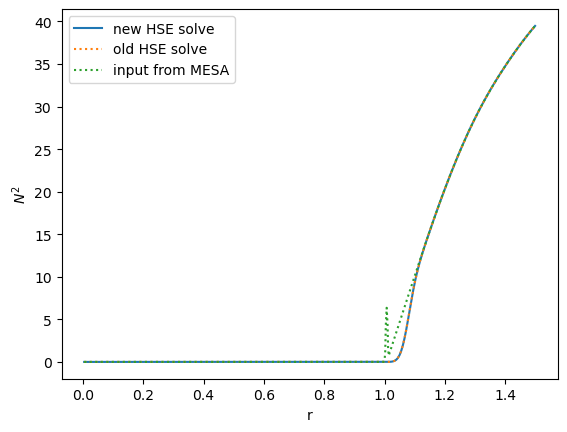

In [37]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['N2'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['N2'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve',ls=':')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],tau_nd**2*N2[r_nd<r_bounds[-1]/L_nd],label='input from MESA',ls=':')
plt.legend()
# plt.yscale('log')
plt.xlabel('r')
plt.ylabel(r'$N^2$')

In [38]:
interpolations

OrderedDict([('ln_rho0',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04b5d770>),
             ('ln_T0',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04b5d590>),
             ('grad_ln_rho0',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04ffe450>),
             ('grad_ln_T0',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04fffb80>),
             ('T0',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04fffa90>),
             ('nu_diff',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04fff7c0>),
             ('chi_rad',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04fff860>),
             ('grad_chi_rad',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04fffa40>),
             ('g',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04fffae0>),
             ('g_phi',
              <scipy.interpolate._interpolate.interp1d at 0x7f5e04ff

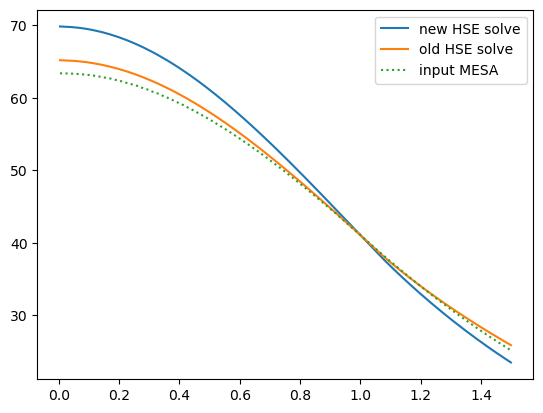

In [39]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],nondim_R_gas*interpolations['T0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='input MESA',ls=':')
plt.legend()

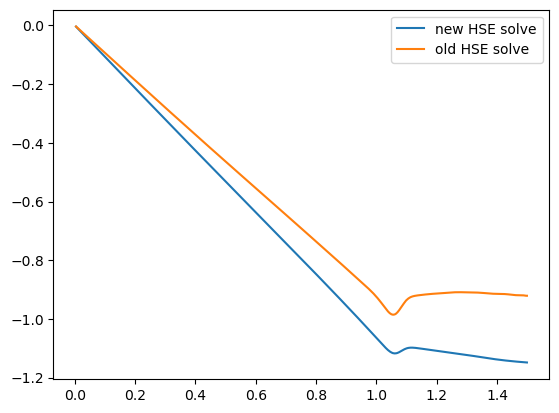

In [40]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['grad_ln_pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['grad_ln_pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.legend()

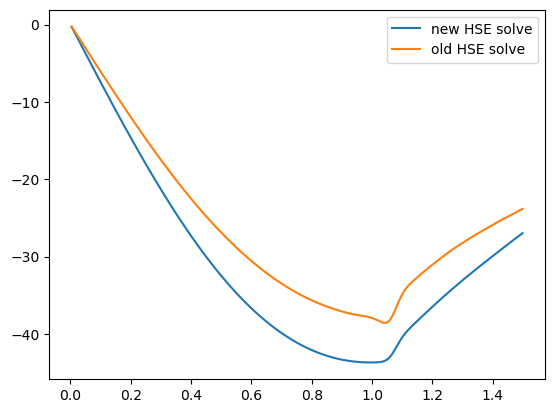

In [41]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['grad_pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['grad_pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.legend()

Text(0, 0.5, 's')

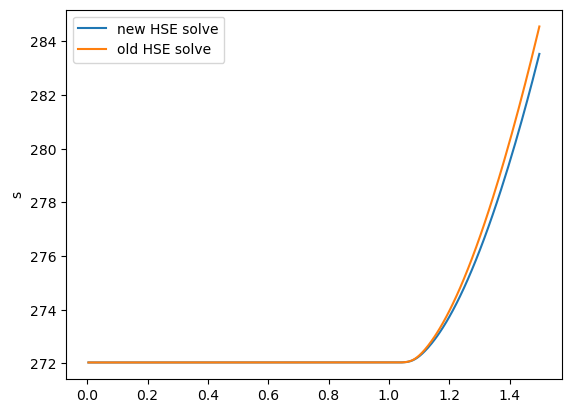

In [42]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['s0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['s0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.legend()
plt.ylabel('s')

Text(0, 0.5, 'grad_s')

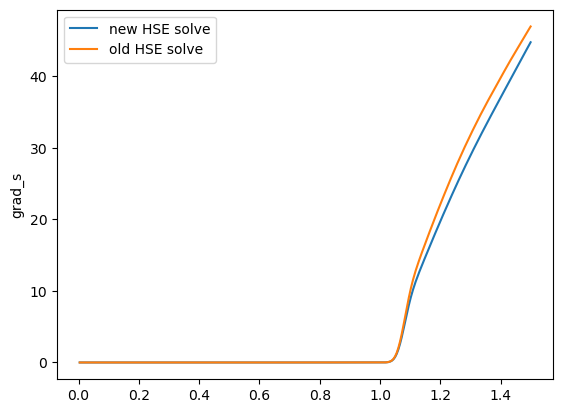

In [43]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['grad_s'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['grad_s'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve')
plt.legend()
# plt.yscale('log')
plt.ylabel('grad_s')

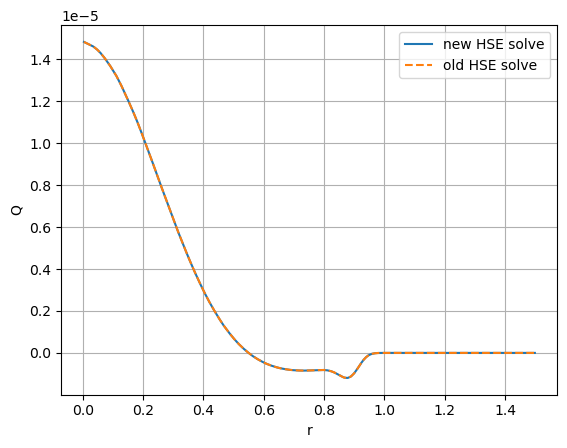

In [44]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['Q'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo['Q'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='old HSE solve',ls='--')
# plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['Q'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='initial MESA profile',ls=':')
plt.legend()
plt.ylabel('Q')
plt.xlabel('r')
plt.grid()

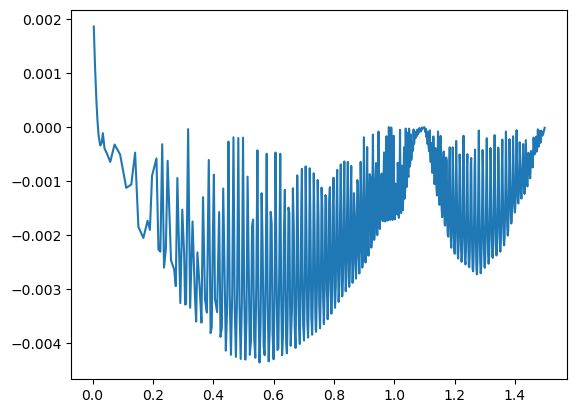

In [45]:
Cp=nondim_R_gas*nondim_gamma1/(nondim_gamma1-1)
HSE_test_arr = nondim_gamma1*atmo['pomega'](r_nd)*(atmo['grad_ln_rho'](r_nd) + atmo['grad_s'](r_nd)/Cp) - atmo['g'](r_nd)
plt.plot(r_nd[r_nd<1.5],HSE_test_arr[r_nd<1.5])

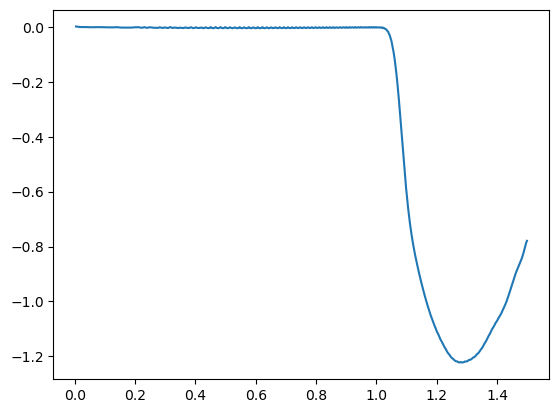

In [46]:
Cp=nondim_R_gas*nondim_gamma1/(nondim_gamma1-1)
# gamma*(s/Cp + ((gamma-1)/gamma)*ln_rho*ones)
# pomega_test = np.exp(nondim_gamma1*((atmo['s0'](r_nd)-atmo['s0'](0))/Cp + ((nondim_gamma1-1)/nondim_gamma1)*atmo_test['ln_rho'](r_nd)) + np.log(nondim_R_gas))
# plt.plot(r_nd[r_nd<1.5],pomega_test[r_nd<1.5])
# plt.plot(r_nd[r_nd<1.5],atmo['pomega'](r_nd)[r_nd<1.5])
HSE_test_arr2 = nondim_gamma1*atmo['pomega'](r_nd)*(atmo['grad_ln_rho'](r_nd) + atmo_test['grad_s'](r_nd)/Cp) - atmo['g'](r_nd)
plt.plot(r_nd[r_nd<1.5],HSE_test_arr2[r_nd<1.5])

try: Fix Q first 

calculate entropy gradient in rad zone, which depends on opacity, which depends on T,rho too \
in conv. zone, constant entropy so can just solve for the other profiles from [0,L_cz], then radiative zone has inner BC and solve for correct profiles for all the stuff there given HSE, thermal equilibrium, EOS, etc. \
actually the accelerated evolution method of Evan Anders does something similar where it solves for TE of rad zone given the state in the conv zone

## Try HSE solve with diff solver for rad zone including Temp gradient

In [47]:
#No N2func because N2=0 in CZ exactly. 

def HSE_solve_CZ(coords, dist, bases, g_phi_func, ln_rho_func,  Fconv_func, r_stitch=[], r_outer=1, low_nr=16, \
              R=1, gamma=5/3, G=1, nondim_radius=1, ncc_cutoff=1e-9, tolerance=1e-9, HSE_tolerance = 1e-4):
    """
    Solves for hydrostatic equilibrium in a calorically perfect ideal gas.
    The solution for density, entropy, and gravity is found given a specified function of N^2 and grad ln rho.
    The heating term associated with a convective luminosity is also found given a specified function of the convective flux, Fconv.

    Arguments
    ---------
    coords : Dedalus CoordinateSystem object
        The coordinate system in which the solution is found.
    dist : Dedalus Distributor object
        The distributor object associated with the bases; should NOT be in parallel.
    bases : dict
        A dictionary of Dedalus bases, with keys 'B', 'S1', 'S2', etc. for the Ball basis, first Shell basis, second Shell basis, etc.
    grad_ln_rho_func : function
        A function of radius that returns the gradient of the log of density. Input r should be nondimensionalized.
    Fconv_func : function
        A function of radius that returns the nondimensionalized convective flux. Input r should be nondimensionalized.
    r_stitch : list
        A list of radii at which to stitch together the solutions from different bases. 
        The first element should be the radius of the outer boundary of the BallBasis.
        If there is only one basis, r_stitch should be an empty list.
    r_outer : float
        The radius of the outer boundary of the simulation domain.
    low_nr : int
        The number of radial points in the low resolution domain; used to set up background fields for solve. #TODO: make this by-basis.
    R : float
        The nondimensional value of the gas constant divided by the mean molecular weight.
    gamma : float
        The adiabatic index of the gas.
    nondim_radius : float
        The radius where thermodynamics are nondimensionalized.
    ncc_cutoff : float
        The NCC floor for the solver. See Dedalus.core.solvers.SolverBase
    tolerance : float
        The tolerance for perturbation norm of the newton iteration.
    HSE_tolerance : float
        The tolerance for hydrostatic equilibrium of the BVP solve.
    
    Returns
    -------
    atmosphere : dict
        A dictionary of interpolated functions which return atmospheric quantities as a function of nondimensional radius.
    """
    # Parameters
    namespace = dict()
    namespace['G'] = G
    namespace['R'] = R
    namespace['Cp'] = Cp = R*gamma/(gamma-1)
    namespace['gamma'] = gamma
    namespace['log'] = np.log
    namespace['exp'] = np.exp

    #Loop over bases, set up fields and operators.
    for k, basis in bases.items():
        namespace['basis_{}'.format(k)] = basis
        namespace['S2_basis_{}'.format(k)] = S2_basis = basis.S2_basis()

        # Make problem variables and taus.
        namespace['g_phi_{}'.format(k)] = g_phi = dist.Field(name='g_phi', bases=basis)
        namespace['Q_{}'.format(k)] = Q = dist.Field(name='Q', bases=basis)
        namespace['s_{}'.format(k)] = s = dist.Field(name='s', bases=basis)
        namespace['g_{}'.format(k)] = g = dist.VectorField(coords, name='g', bases=basis)
        namespace['ln_rho_{}'.format(k)] = ln_rho = dist.Field(name='ln_rho', bases=basis)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = dist.VectorField(coords, name='grad_ln_rho', bases=basis)
        namespace['tau_s_{}'.format(k)] = tau_s = dist.Field(name='tau_s', bases=S2_basis)
        namespace['tau_rho_{}'.format(k)] = tau_rho = dist.Field(name='tau_rho', bases=S2_basis)
        namespace['tau_g_phi_{}'.format(k)] = tau_g_phi = dist.Field(name='tau_g_phi', bases=S2_basis)
        namespace['tau_g_phi_1_{}'.format(k)] = tau_g_phi_1 = dist.Field(name='tau_g_phi_1', bases=S2_basis)
        namespace['tau_g_phi_2_{}'.format(k)] = tau_g_phi_2 = dist.Field(name='tau_g_phi_2', bases=S2_basis)

        # Set up some fundamental grid data
        low_scales = low_nr/basis.radial_basis.radial_size 
        phi, theta, r = dist.local_grids(basis)
        phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
        phi_low, theta_low, r_low = dist.local_grids(basis, scales=(1,1,low_scales))
        namespace['r_de_{}'.format(k)] = r_de
        namespace['r_vec_{}'.format(k)] = r_vec = dist.VectorField(coords, bases=basis.radial_basis)
        r_vec['g'][2] = r
        namespace['r_squared_{}'.format(k)] = r_squared = dist.Field(bases=basis.radial_basis)
        r_squared['g'] = r**2       

        # Make lift operators for BCs
        if k == 'B':
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis, -1)
        else:
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis.derivative_basis(2), -1)
            namespace['lift2_{}'.format(k)] = lift2 = lambda A: d3.Lift(A, basis.derivative_basis(2), -2)

        # Make a field of ones for converting NCCs to full fields.
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1

        #make a field of 4piG*ones
        namespace['four_pi_G_{}'.format(k)] = four_pi_G = dist.Field(bases=basis, name='four_pi_G')
        four_pi_G['g'] = 4*np.pi*G*ones['g']

        #Make a field that smooths at the edge of the ball basis.
        namespace['edge_smoothing_{}'.format(k)] = edge_smooth = dist.Field(bases=basis, name='edge_smooth')
        edge_smooth['g'] = one_to_zero(r, 0.95*bases['B'].radius, width=0.03*bases['B'].radius)

        
        #Set grad ln rho.
        # grad_ln_rho.change_scales(low_scales)
        # grad_ln_rho['g'][2] = grad_ln_rho_func(r_low)
        # grad_ln_rho['g'][2] = grad_ln_rho_func(r)
            
            
        # Set ln rho initial guess.
        namespace['ln_rho_in_{}'.format(k)] = ln_rho_in = dist.Field(bases=basis, name='ln_rho_in')
        ln_rho_in['g'] = ln_rho_func(r)

        # Set the convective flux.
        namespace['Fconv_{}'.format(k)] = Fconv   = dist.VectorField(coords, name='Fconv', bases=basis)
        Fconv['g'][2] = Fconv_func(r)

        # set initial guess for g_phi
        namespace['g_phi_in_{}'.format(k)] = g_phi_in = dist.Field(bases=basis, name='g_phi_in')
        g_phi_in['g'] = g_phi_func(r)


        # Create important operations from the fields.
        namespace['ln_pomega_LHS_{}'.format(k)] = ln_pomega_LHS = gamma*(s/Cp + ((gamma-1)/gamma)*ln_rho*ones)
        namespace['ln_pomega_{}'.format(k)] = ln_pomega = ln_pomega_LHS + np.log(R)
        namespace['pomega_{}'.format(k)] = pomega = np.exp(ln_pomega)
        namespace['P_{}'.format(k)] = P = pomega*np.exp(ln_rho)
        namespace['HSE_{}'.format(k)] = HSE = gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) + d3.grad(g_phi)*ones
        #gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) - g*ones
        namespace['N2_op_{}'.format(k)] = N2_op = d3.grad(g_phi)@d3.grad(s)/Cp
        namespace['rho_{}'.format(k)] = rho = np.exp(ln_rho*ones)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = d3.grad(ln_rho)
        namespace['T_{}'.format(k)] = T = pomega/R
        namespace['ln_T_{}'.format(k)] = ln_T = ln_pomega - np.log(R)
        namespace['grad_pomega_{}'.format(k)] = d3.grad(pomega)
        namespace['grad_ln_pomega_{}'.format(k)] = d3.grad(ln_pomega)
        namespace['grad_s_{}'.format(k)] = grad_s = d3.grad(s)
        namespace['r_vec_g_{}'.format(k)] = r_vec@g
        namespace['g_op_{}'.format(k)] = gamma * pomega * grad_ln_rho #for grad_s=0 case in CZ
        # namespace['g_op_{}'.format(k)] = gamma * pomega * (grad_s/Cp + grad_ln_rho)
        namespace['s0_{}'.format(k)] = Cp * ((1/gamma)*(ln_pomega + ln_rho) - ln_rho) #s with an offset so s0 = cp * (1/gamma * lnP - ln_rho)

    namespace['pi'] = np.pi
    locals().update(namespace)
    


    # Solve for poisson equation given ln_rho.
    variables, taus = [], []
    for k, basis in bases.items():
        variables += [namespace['g_phi_{}'.format(k)],namespace['s_{}'.format(k)],namespace['ln_rho_{}'.format(k)],namespace['Q_{}'.format(k)], ]#,namespace['ln_rho_{}'.format(k)],]
        
        taus += [ namespace['tau_g_phi_1_{}'.format(k)],namespace['tau_s_{}'.format(k)], namespace['tau_g_phi_{}'.format(k)]] #namespace['tau_g_phi_{}'.format(k)],namespace['tau_s_{}'.format(k)],
        if k != 'B':
            taus += [namespace['tau_g_phi_2_{}'.format(k)],]
        # variables += [namespace['s_{}'.format(k)],]
        
        # taus += [namespace['tau_s_{}'.format(k)], ]

    print('variables',len(variables),'taus',len(taus))
    problem = d3.NLBVP(variables + taus, namespace=locals())
    count_eqn = 0
    for k, basis in bases.items():
    
        # Set a decent initial guess for s.
        # namespace['s_{}'.format(k)].change_scales(basis.dealias)
        # namespace['s_{}'.format(k)]['g'] = -(R*namespace['ln_rho_in_{}'.format(k)]).evaluate()['g']
        # Set a decent initial guess for ln_rho.
        namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_{}'.format(k)]['g'] = np.copy(namespace['ln_rho_in_{}'.format(k)]['g'])
       
        # set initial guess for g_phi
        namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_{}'.format(k)]['g'] = (namespace['g_phi_in_{}'.format(k)]).evaluate()['g']
        #Set the equations: poisson
        if k != 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0}) + lift_{0}(tau_g_phi_1_{0}) + lift2_{0}(tau_g_phi_2_{0}) = 0".format(k))
            count_eqn+=1
        elif k == 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0})  + lift_{0}(tau_g_phi_1_{0}) = 0".format(k))
            count_eqn+=1
        
        #Set the equations: hydrostatic equilibrium
        problem.add_equation("-grad(g_phi_{0}) + r_vec_{0}*lift_{0}(tau_g_phi_{0}) = g_op_{0} ".format(k))
        # problem.add_equation("grad(ln_rho_{0})@(grad(s_{0})/Cp) + lift_{0}(tau_s_{0}) = -N2_{0}/(gamma*pomega_{0}) - grad(s_{0})@grad(s_{0}) / Cp**2".format(k))
        problem.add_equation("grad(s_{0}) + r_vec_{0}*lift_{0}(tau_s_{0}) = 0".format(k))
        count_eqn+=2
        #Set equation for heating
        problem.add_equation("Q_{0} = edge_smoothing_{0}*div(Fconv_{0})".format(k))
        count_eqn+=1
    
    #Set the boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            problem.add_equation("ln_rho_{0}(r={2}) - ln_rho_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("s_{0}(r={2}) - s_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("g_phi_{0}(r={2}) - g_phi_{1}(r={2}) = 0".format(k, k_old, r_s))
            problem.add_equation("grad(g_phi_{0})(r={2}) - grad(g_phi_{1})(r={2}) = 0".format(k, k_old, r_s))
            count_eqn+=4
        iter += 1
        if iter == len(bases.items()):
            # problem.add_equation("g_phi_{0}(r=r_outer) = g_phi_in_{0}(r=r_outer)".format(k))
            problem.add_equation("g_phi_{0}(r=r_outer) = 0".format(k))
            count_eqn+=1
    
    problem.add_equation("ln_pomega_LHS_B(r=nondim_radius) = 0")
    problem.add_equation("ln_rho_B(r=nondim_radius) = 0")
    count_eqn+=2
    print('number of eqns',count_eqn)

    #Solve with tolerances on pert_norm and hydrostatic equilibrium.
    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance or HSE_err > HSE_tolerance:

        plt.figure()
        for k, basis in bases.items():
            plt.ylabel(r'HSE')
            plt.xlabel(r'r')
            plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['HSE_{}'.format(k)]['g'][2,0,0,:],label='HSE',c='cornflowerblue')
        plt.legend()
        plt.show()
        HSE_err = 0
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
        for k, basis in bases.items():
            this_HSE = np.max(np.abs(namespace['HSE_{}'.format(k)].evaluate()['g']))
            logger.info('HSE in {}:{:.3e}'.format(k, this_HSE))
            if this_HSE > HSE_err:
                HSE_err = this_HSE

    plt.figure()
    for k, basis in bases.items():
        namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_{}'.format(k)] = -d3.grad(namespace['g_phi_{}'.format(k)])
        plt.ylabel(r'$\Phi_g$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_{}'.format(k)]['g'][0,0,:],label='g_phi',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_in_{}'.format(k)]['g'][0,0,:],label='g_phi in',c='salmon',ls=':')
        plt.legend()
    plt.figure()
    for k, basis in bases.items():
        namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
        
        plt.ylabel(r'$\ln \rho$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_{}'.format(k)]['g'][0,0,:],label='ln_rho',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_in_{}'.format(k)]['g'][0,0,:],label='ln_rho in',c='salmon',ls=':')
        plt.legend()
    plt.figure()
    for k, basis in bases.items():
        plt.ylabel(r'$s$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['s_{}'.format(k)]['g'][0,0,:],label='s',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], -(R*namespace['ln_rho_{}'.format(k)]).evaluate()['g'][0,0,:],label='s in',c='salmon',ls=':')
    plt.legend()

    # Stitch together the fields for creation of interpolators that span the full simulation domain.
    #Need: grad_pom0, grad_ln_pom0, grad_ln_rho0, grad_s0, g, pom0, rho0, ln_rho0, g_phi
    stitch_fields = OrderedDict()
    fields = ['grad_pomega', 'grad_ln_pomega', 'grad_ln_rho', 'grad_s', 'g', 'pomega', 'rho', 'ln_rho', 'g_phi', 'r_vec', 'HSE', 'N2_op', 'Q', 's0']
    for f in fields:
        stitch_fields[f] = []
    
    for k, basis in bases.items():
        for f in fields:
            stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'])]

    if len(stitch_fields['r_vec']) == 1:
        for f in fields:
            stitch_fields[f] = stitch_fields[f][0]
    else:
        for f in fields:
            stitch_fields[f] = np.concatenate(stitch_fields[f], axis=-1)

    grad_pom = stitch_fields['grad_pomega'][2,:].ravel()
    grad_ln_pom = stitch_fields['grad_ln_pomega'][2,:].ravel()
    grad_ln_rho = stitch_fields['grad_ln_rho'][2,:].ravel()
    grad_s = stitch_fields['grad_s'][2,:].ravel()
    g = stitch_fields['g'][2,:].ravel()
    HSE = stitch_fields['HSE'][2,:].ravel()
    r = stitch_fields['r_vec'][2,:].ravel()

    pom = stitch_fields['pomega'].ravel()
    rho = stitch_fields['rho'].ravel()
    ln_rho = stitch_fields['ln_rho'].ravel()
    g_phi = stitch_fields['g_phi'].ravel()
    N2 = stitch_fields['N2_op'].ravel() #this should be zero given grad_s = 0 in CZ
    Q = stitch_fields['Q'].ravel()
    s0 = stitch_fields['s0'].ravel()


    #Plot the results.
    fig = plt.figure()
    ax1 = fig.add_subplot(4,2,1)
    ax2 = fig.add_subplot(4,2,2)
    ax3 = fig.add_subplot(4,2,3)
    ax4 = fig.add_subplot(4,2,4)
    ax5 = fig.add_subplot(4,2,5)
    ax6 = fig.add_subplot(4,2,6)
    ax7 = fig.add_subplot(4,2,7)
    ax8 = fig.add_subplot(4,2,8)
    ax1.plot(r, grad_pom, label='grad pomega')
    ax1.legend()
    ax2.plot(r, grad_ln_rho, label='grad ln rho')
    ax2.legend()
    ax3.plot(r, pom/R, label='pomega/R')
    ax3.plot(r, rho, label='rho')
    ax3.legend()
    ax4.plot(r, HSE, label='HSE')
    ax4.legend()
    ax5.plot(r, g, label='g')
    ax5.legend()
    ax6.plot(r, g_phi, label='g_phi')
    ax6.legend()
    ax7.plot(r, N2, label=r'$N^2$')
    ax7.plot(r, -N2, label=r'$-N^2$')
    # ax7.plot(r, (N2_func(r)), label=r'$N^2$ goal', ls='--')
    ax7.set_yscale('log')
    # yticks = (np.max(np.abs(N2.ravel()[r.ravel() < 0.5])), np.max(N2_func(r).ravel()))
    # ax7.set_yticks(yticks)
    # ax7.set_yticklabels(['{:.1e}'.format(n) for n in yticks])
    ax7.legend()
    ax8.plot(r, grad_s, label='grad s')
    ax8.set_yscale('log')
    ax8.legend()
    # fig.savefig('stratification.png', bbox_inches='tight', dpi=300)
    for k, basis in bases.items():
        this_HSE = np.max(np.abs(namespace['HSE_{}'.format(k)].evaluate()['g']))
        print('this HSE',this_HSE)
    

    #Create interpolators for the atmosphere.
    atmosphere = dict()
    atmosphere['grad_pomega'] = interp1d(r, grad_pom, **interp_kwargs)
    atmosphere['grad_ln_pomega'] = interp1d(r, grad_ln_pom, **interp_kwargs)
    atmosphere['grad_ln_rho'] = interp1d(r, grad_ln_rho, **interp_kwargs)
    atmosphere['grad_s'] = interp1d(r, grad_s, **interp_kwargs)
    atmosphere['g'] = interp1d(r, g, **interp_kwargs)
    atmosphere['pomega'] = interp1d(r, pom, **interp_kwargs)
    atmosphere['rho'] = interp1d(r, rho, **interp_kwargs)
    atmosphere['ln_rho'] = interp1d(r, ln_rho, **interp_kwargs)
    atmosphere['g_phi'] = interp1d(r, g_phi, **interp_kwargs)
    atmosphere['N2'] = interp1d(r, N2, **interp_kwargs)
    atmosphere['Q'] = interp1d(r, Q, **interp_kwargs)
    atmosphere['s0'] = interp1d(r, s0, **interp_kwargs)

    # Create dictionary to pass to RZ solve
    quantities_CZ = dict()
    quantities_CZ['Q'] = Q
    quantities_CZ['s0'] = s0
    quantities_CZ['grad_s'] = grad_s
    quantities_CZ['g_phi'] = g_phi
    quantities_CZ['g'] = g
    quantities_CZ['ln_rho'] = ln_rho
    quantities_CZ['grad_ln_rho'] = grad_ln_rho
    quantities_CZ['rho'] = rho
    quantities_CZ['pomega'] = pom
    quantities_CZ['grad_pomega'] = grad_pom
    quantities_CZ['grad_ln_pomega'] = grad_ln_pom
    quantities_CZ['r_de'] = r
    # for k, basis in bases.items():
    #     phi, theta, r_basis = dist.local_grids(basis)
    #     namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
    #     ones['g'] = 1
    #     # gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) + d3.grad(g_phi)*ones
    #     namespace['pomega_in_{}'.format(k)] = pomega_in = dist.Field(name='pomega_in', bases=basis)
    #     pomega_in['g']=atmosphere['pomega'](r_basis)
    #     namespace['ln_rho_in_{}'.format(k)] = ln_rho_in = dist.Field(name='ln_rho_in', bases=basis)
    #     ln_rho_in['g']=atmosphere['ln_rho'](r_basis)
    #     namespace['s_in_{}'.format(k)] = s_in = dist.Field(name='s_in', bases=basis)
    #     s_in['g']=0
    #     namespace['g_phi_in_{}'.format(k)] = g_phi_in = dist.Field(name='g_phi_in', bases=basis)
    #     g_phi_in['g']=atmosphere['g_phi'](r_basis)
    #     # print(pomega,ln_rho,s,g_phi)
    #     namespace['HSE_in_{}'.format(k)] = HSE_in = gamma*pomega_in*(d3.grad(ones*ln_rho_in) + d3.grad(s_in)/Cp) + d3.grad(g_phi_in)*ones
    #     namespace['HSE_out_{}'.format(k)] = HSE_out = gamma*pom*(grad_ln_rho + grad_s/Cp) - g
    #     this_HSE = np.max(np.abs(namespace['HSE_in_{}'.format(k)].evaluate()['g']))
    #     this_HSE2 = np.max(np.abs(namespace['HSE_out_{}'.format(k)]))
    #     print('this HSE',this_HSE,this_HSE2)
    # print('r_test_CZ',r)
    return atmosphere, quantities_CZ

variables 8 taus 7
number of eqns 15


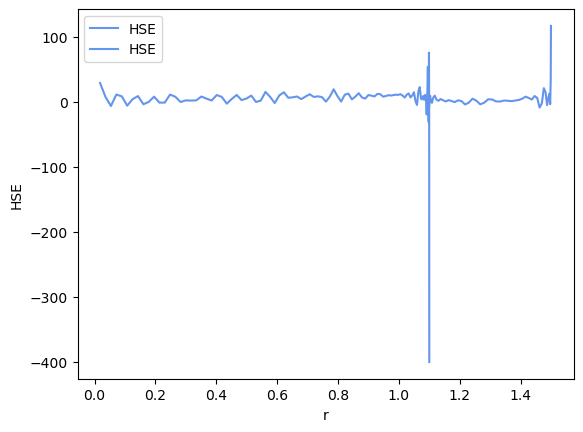

2024-12-02 11:16:37,198 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 8.9e-01/s
2024-12-02 11:16:37,201 __main__ 0/1 INFO :: Perturbation norm: 3.594e+02
2024-12-02 11:16:37,203 __main__ 0/1 INFO :: HSE in B:2.965e+00
2024-12-02 11:16:37,205 __main__ 0/1 INFO :: HSE in S1:9.982e-01


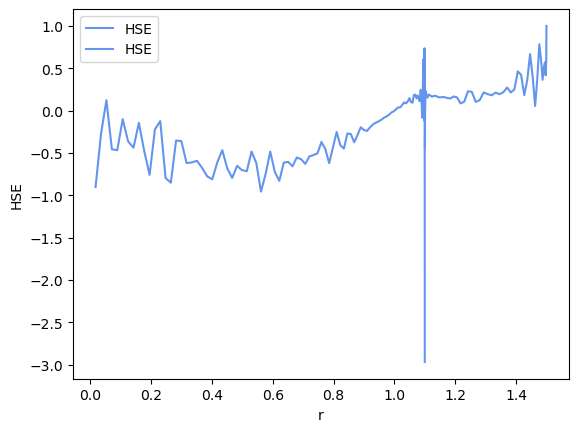

2024-12-02 11:16:38,504 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.1e-01/s
2024-12-02 11:16:38,507 __main__ 0/1 INFO :: Perturbation norm: 2.340e-01
2024-12-02 11:16:38,509 __main__ 0/1 INFO :: HSE in B:1.918e-02
2024-12-02 11:16:38,522 __main__ 0/1 INFO :: HSE in S1:1.694e-02


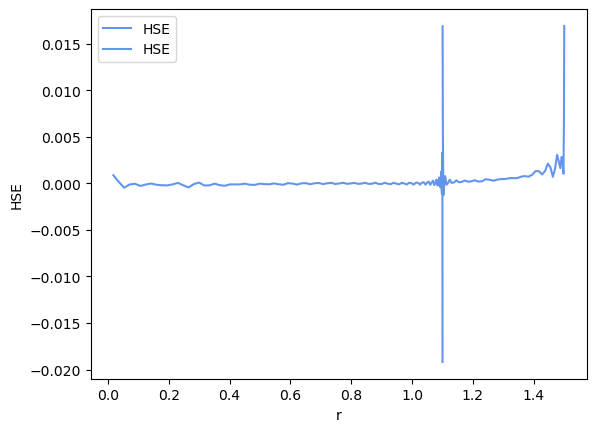

2024-12-02 11:16:39,724 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.2e-01/s
2024-12-02 11:16:39,727 __main__ 0/1 INFO :: Perturbation norm: 5.409e-04
2024-12-02 11:16:39,729 __main__ 0/1 INFO :: HSE in B:2.256e-05
2024-12-02 11:16:39,740 __main__ 0/1 INFO :: HSE in S1:4.420e-04


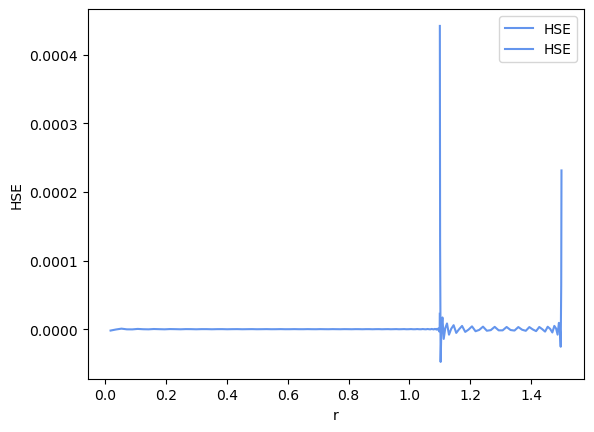

2024-12-02 11:16:40,866 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 9.9e-01/s
2024-12-02 11:16:40,868 __main__ 0/1 INFO :: Perturbation norm: 2.950e-06
2024-12-02 11:16:40,871 __main__ 0/1 INFO :: HSE in B:3.673e-09
2024-12-02 11:16:40,882 __main__ 0/1 INFO :: HSE in S1:6.320e-06
this HSE 2.0739847172990267e-08
this HSE 6.320386759739449e-06


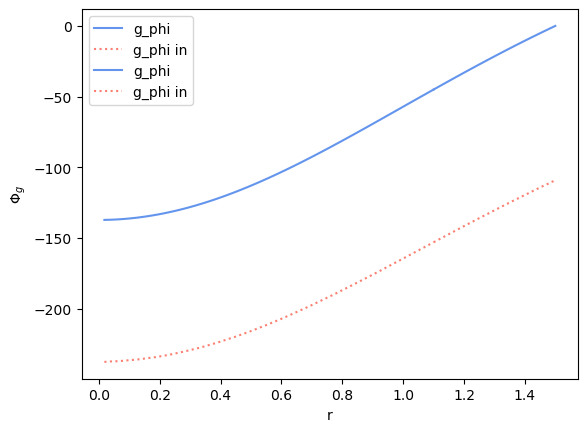

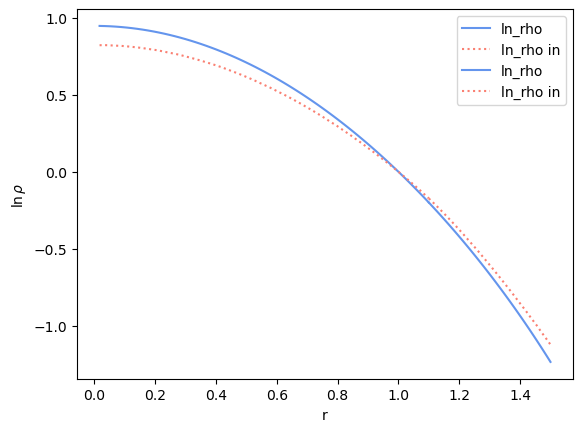

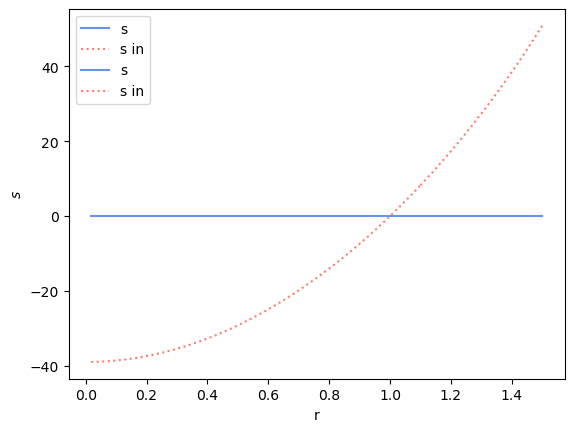

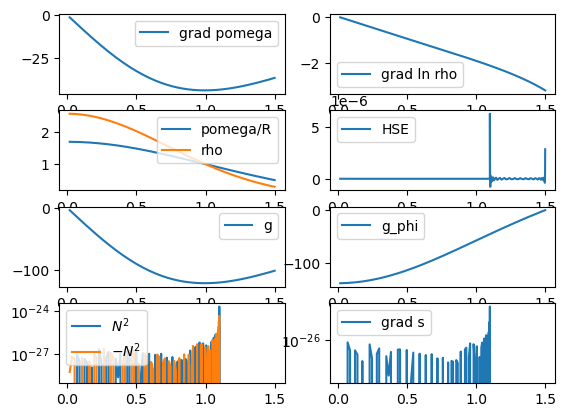

In [48]:
# grad_ln_rho_func = interpolations['grad_ln_rho0']
ln_rho_func = interpolations['ln_rho0']
g_phi_func = interpolations['g_phi']
atmo_test_CZ, quantities_CZ=HSE_solve_CZ(c, d, bases, g_phi_func,ln_rho_func, F_conv_func,
              r_outer=r_bound_nd[-1], r_stitch=stitch_radii, \
              R=nondim_R_gas, gamma=nondim_gamma1, G=nondim_G, nondim_radius=1,tolerance=1e-5, HSE_tolerance = 1e-4)

### Compare CZ HSE solve to New Hse solve_test2

In [49]:
r_bounds[-1]/L_nd

<Quantity 1.5>

In [50]:
quantities_CZ.keys()

dict_keys(['Q', 's0', 'grad_s', 'g_phi', 'g', 'ln_rho', 'grad_ln_rho', 'rho', 'pomega', 'grad_pomega', 'grad_ln_pomega', 'r_de'])

Text(0.5, 0, 'r')

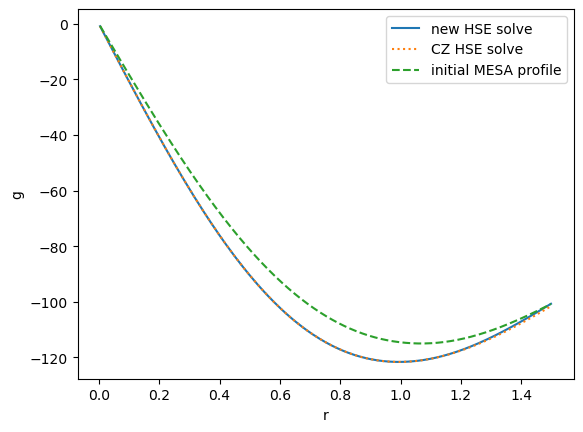

In [51]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_CZ['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='CZ HSE solve',ls=':')

# plt.plot(quantities_CZ['r'],quantities_CZ['g'],ls=':',color='black')

plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='initial MESA profile',ls='--')
plt.legend()
plt.ylabel('g')
plt.xlabel('r')

Text(0, 0.5, '$\\Phi_g$')

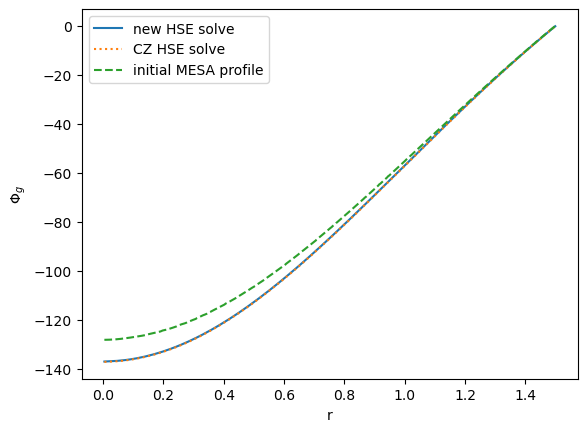

In [52]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_CZ['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='CZ HSE solve',ls=':')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])-interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])[-1],label='initial MESA profile',ls='--')
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\Phi_g$')

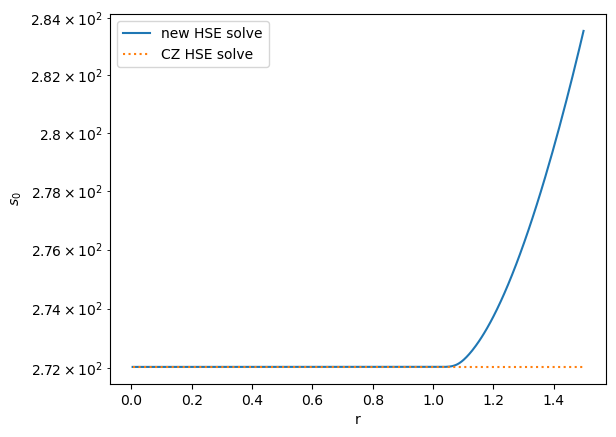

In [53]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['s0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_CZ['s0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='CZ HSE solve',ls=':')
# plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])-interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])[-1],label='initial MESA profile',ls='--')
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$s_0$')
plt.yscale('log')

Text(0, 0.5, '$\\varpi$')

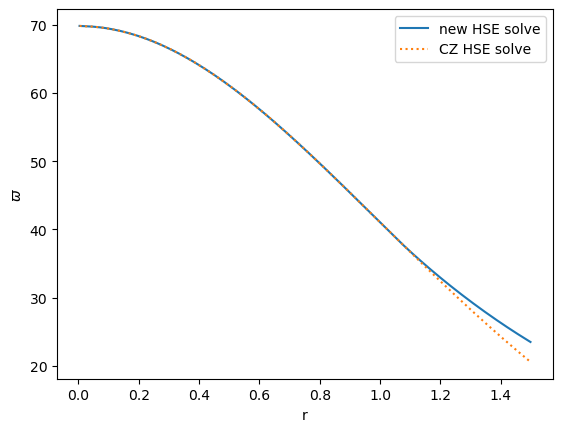

In [54]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_CZ['pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='CZ HSE solve',ls=':')
# plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])-interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])[-1],label='initial MESA profile',ls='--')
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\varpi$')
# plt.yscale('log')

Text(0.5, 0, 'r')

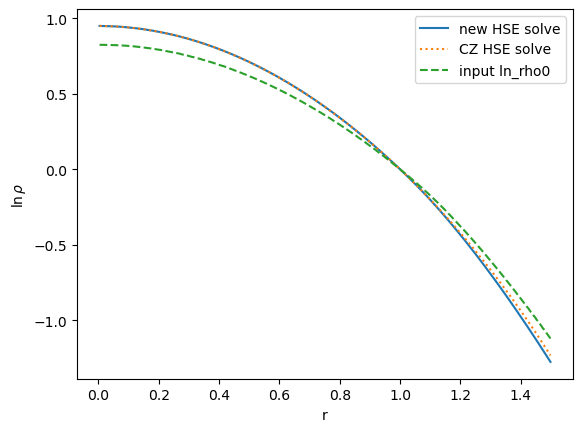

In [55]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_CZ['ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='CZ HSE solve',ls=':')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['ln_rho0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='input ln_rho0',ls='--')
plt.legend()
plt.ylabel(r'$\ln \rho$')
plt.xlabel('r')

Text(0.5, 0, 'r')

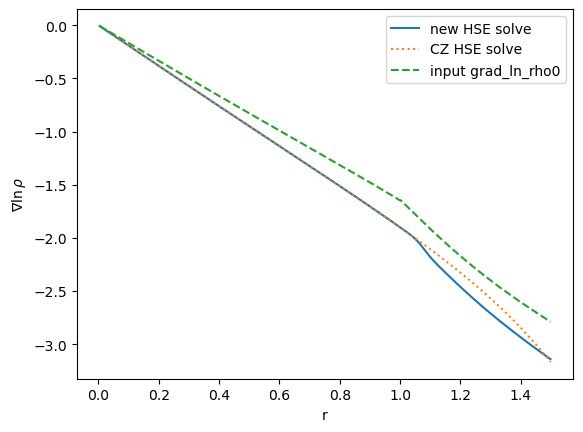

In [56]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['grad_ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_CZ['grad_ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='CZ HSE solve',ls=':')
plt.plot(r_nd[r_nd < 1.5],interpolations['grad_ln_rho0'](r_nd)[r_nd<1.5],label='input grad_ln_rho0',ls='--')
plt.legend()
plt.ylabel(r'$\nabla \ln \rho$')
plt.xlabel('r')

Text(0, 0.5, '$N^2$')

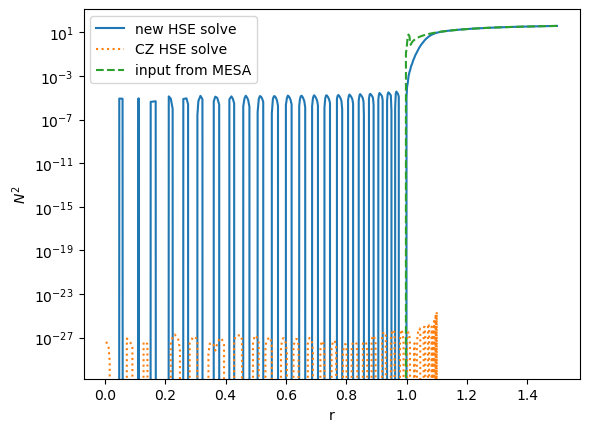

In [57]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['N2'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_CZ['N2'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='CZ HSE solve',ls=':')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],tau_nd**2*N2[r_nd<r_bounds[-1]/L_nd],label='input from MESA',ls='--')
plt.legend()
plt.yscale('log')
plt.xlabel('r')
plt.ylabel(r'$N^2$')

### Test solver in RZ now

In [58]:
atmo_test_CZ.keys()

dict_keys(['grad_pomega', 'grad_ln_pomega', 'grad_ln_rho', 'grad_s', 'g', 'pomega', 'rho', 'ln_rho', 'g_phi', 'N2', 'Q', 's0'])

In [59]:
L_rad_sim = dmr.Luminosity.cgs.value - (L_conv_sim*(r/L_nd)**2 * (4*np.pi)).cgs.value
L_rad_sim/= (r/L_nd)**2 * (4*np.pi)
F_rad_func = interp1d(r/L_nd, L_rad_sim/lum_nd, **interp_kwargs)

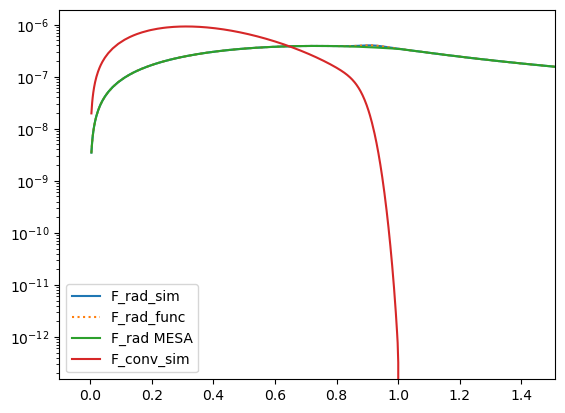

In [60]:
plt.plot(dmr.r/L_nd,L_rad_sim/lum_nd,label='F_rad_sim')
plt.plot(dmr.r/L_nd,F_rad_func(dmr.r/L_nd),label='F_rad_func',ls=':')
plt.plot(dmr.r/L_nd,(1-dmr.conv_L_div_L)*dmr.Luminosity.cgs.value/((r/L_nd)**2 * (4*np.pi))/lum_nd,label='F_rad MESA')

plt.plot(dmr.r/L_nd,L_conv_sim/lum_nd,label='F_conv_sim')
plt.legend()
plt.xlim(-0.1,1.51)
plt.yscale('log')

In [61]:
#given atmo from HSE

def HSE_solve_RZ_as_CZ(coords, dist, bases, quantities_CZ, r_transition, chi_rad_func, Frad_func, N2_func, r_stitch=[], r_outer=1, low_nr=16, \
              R=1, gamma=5/3, G=1, nondim_radius=1, ncc_cutoff=1e-9, tolerance=1e-9, HSE_tolerance = 1e-4):
    """
    Solves for hydrostatic equilibrium in a calorically perfect ideal gas.
    The solution for density, entropy, and gravity is found given a specified function of N^2 and grad ln rho.
    The heating term associated with a convective luminosity is also found given a specified function of the convective flux, Fconv.

    Arguments
    ---------
    coords : Dedalus CoordinateSystem object
        The coordinate system in which the solution is found.
    dist : Dedalus Distributor object
        The distributor object associated with the bases; should NOT be in parallel.
    bases : dict
        A dictionary of Dedalus bases, with keys 'B', 'S1', 'S2', etc. for the Ball basis, first Shell basis, second Shell basis, etc.
    grad_ln_rho_func : function
        A function of radius that returns the gradient of the log of density. Input r should be nondimensionalized.
    N2_func : function
        A function of radius that returns the nondimensionalized Brunt-Vaisala frequency squared. Input r should be nondimensionalized.
    atmo : dict
        A dictionary of Dedalus fields that represent the initial guess for the quantities and their values at fixed inner point r_transition.
    r_transition : float
        The radius at which to start integrating the radiative zone solution.
    r_stitch : list
        A list of radii at which to stitch together the solutions from different bases. 
        The first element should be the radius of the outer boundary of the BallBasis.
        If there is only one basis, r_stitch should be an empty list.
    r_outer : float
        The radius of the outer boundary of the simulation domain.
    low_nr : int
        The number of radial points in the low resolution domain; used to set up background fields for solve. #TODO: make this by-basis.
    R : float
        The nondimensional value of the gas constant divided by the mean molecular weight.
    gamma : float
        The adiabatic index of the gas.
    nondim_radius : float
        The radius where thermodynamics are nondimensionalized.
    ncc_cutoff : float
        The NCC floor for the solver. See Dedalus.core.solvers.SolverBase
    tolerance : float
        The tolerance for perturbation norm of the newton iteration.
    HSE_tolerance : float
        The tolerance for hydrostatic equilibrium of the BVP solve.
    
    Returns
    -------
    atmosphere : dict
        A dictionary of interpolated functions which return atmospheric quantities as a function of nondimensional radius.
    """
    # Parameters
    namespace = dict()
    namespace['G'] = G
    namespace['R'] = R
    namespace['Cp'] = Cp = R*gamma/(gamma-1)
    namespace['gamma'] = gamma
    namespace['log'] = np.log
    namespace['exp'] = np.exp

    # ln_rho_func = interp1d(quantities_CZ['r'], quantities_CZ['ln_rho'], **interp_kwargs)
    # g_phi_func = interp1d(quantities_CZ['r'], quantities_CZ['g_phi'], **interp_kwargs)
    # Q_func = interp1d(quantities_CZ['r'], quantities_CZ['Q'], **interp_kwargs)
    #Loop over bases, set up fields and operators.
    for k, basis in bases.items():
        namespace['basis_{}'.format(k)] = basis
        namespace['S2_basis_{}'.format(k)] = S2_basis = basis.S2_basis()

        # Make problem variables and taus.
        namespace['g_phi_{}'.format(k)] = g_phi = dist.Field(name='g_phi', bases=basis)
        namespace['Q_{}'.format(k)] = Q = dist.Field(name='Q', bases=basis)
        namespace['s_{}'.format(k)] = s = dist.Field(name='s', bases=basis)
        namespace['g_{}'.format(k)] = g = dist.VectorField(coords, name='g', bases=basis)
        namespace['ln_rho_{}'.format(k)] = ln_rho = dist.Field(name='ln_rho', bases=basis)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = dist.VectorField(coords, name='grad_ln_rho', bases=basis)
        namespace['tau_s_{}'.format(k)] = tau_s = dist.Field(name='tau_s', bases=S2_basis)
        namespace['tau_rho_{}'.format(k)] = tau_rho = dist.Field(name='tau_rho', bases=S2_basis)
        namespace['tau_g_phi_{}'.format(k)] = tau_g_phi = dist.Field(name='tau_g_phi', bases=S2_basis)
        namespace['tau_g_phi_1_{}'.format(k)] = tau_g_phi_1 = dist.Field(name='tau_g_phi_1', bases=S2_basis)
        namespace['tau_g_phi_2_{}'.format(k)] = tau_g_phi_2 = dist.Field(name='tau_g_phi_2', bases=S2_basis)

        # Set up some fundamental grid data
        low_scales = low_nr/basis.radial_basis.radial_size 
        phi, theta, r = dist.local_grids(basis)
        phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
        phi_low, theta_low, r_low = dist.local_grids(basis, scales=(1,1,low_scales))
        namespace['r_de_{}'.format(k)] = r_de
        namespace['r_vec_{}'.format(k)] = r_vec = dist.VectorField(coords, bases=basis.radial_basis)
        r_vec['g'][2] = r
        namespace['r_squared_{}'.format(k)] = r_squared = dist.Field(bases=basis.radial_basis)
        r_squared['g'] = r**2       

        # Make lift operators for BCs
        if k == 'B':
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis, -1)
        else:
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis.derivative_basis(2), -1)
            namespace['lift2_{}'.format(k)] = lift2 = lambda A: d3.Lift(A, basis.derivative_basis(2), -2)

        # Make a field of ones for converting NCCs to full fields.
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1

        #make a field of 4piG*ones
        namespace['four_pi_G_{}'.format(k)] = four_pi_G = dist.Field(bases=basis, name='four_pi_G')
        four_pi_G['g'] = 4*np.pi*G*ones['g']

        #Make a field that smooths at the edge of the ball basis.
        namespace['edge_smoothing_{}'.format(k)] = edge_smooth = dist.Field(bases=basis, name='edge_smooth')
        edge_smooth['g'] = one_to_zero(r, 0.95*bases['B'].radius, width=0.03*bases['B'].radius)

        # Get a high-resolution N^2 in the ball; low-resolution elsewhere where it transitions more gradually.
        namespace['N2_{}'.format(k)] = N2 = dist.Field(bases=basis, name='N2')
        if k == 'B':
            N2['g'] = N2_func(r)
        else:
            N2.change_scales(low_scales)
            N2['g'] = N2_func(r_low)
        # not used in the integration of equations, but keep N2_func for comparison at the end

        # Set the radiative flux.
        namespace['Frad_{}'.format(k)] = Frad   = dist.VectorField(coords, name='Frad', bases=basis)
        Frad['g'][2] = Frad_func(r)

        # Set chi_rad
        namespace['chi_rad_{}'.format(k)] = chi_rad   = dist.Field(name='chi_rad', bases=basis)
        chi_rad['g'] = chi_rad_func(r)

        # Set ln rho initial guess.
        namespace['ln_rho_in_{}'.format(k)] = ln_rho_in = dist.Field(bases=basis, name='ln_rho_in')
        ln_rho_in.change_scales(basis.dealias)
        
        if k == 'B':
            dealias_length = int(basis.shape[-1]*basis.dealias[-1])
            ln_rho_in['g'] = quantities_CZ['ln_rho'][:dealias_length]
        elif k == 'S1':
            ln_rho_in['g'] = quantities_CZ['ln_rho'][dealias_length:]
            namespace['ln_rho_r_transition'] = namespace['ln_rho_in_{}'.format(k)](r=r_transition)
        # ln_rho_in['g'] = ln_rho_func(r)

        # set initial guess for g_phi
        namespace['g_phi_in_{}'.format(k)] = g_phi_in = dist.Field(bases=basis, name='g_phi_in')
        g_phi_in.change_scales(basis.dealias)
        if k == 'B':
            g_phi_in['g'] = quantities_CZ['g_phi'][:dealias_length]
        elif k == 'S1':
            g_phi_in['g'] = quantities_CZ['g_phi'][dealias_length:]
            namespace['g_phi_r_transition'] = namespace['g_phi_in_{}'.format(k)](r=r_transition)

        # set initial value for g
        namespace['g_in_{}'.format(k)] = g_in = dist.VectorField(coords,bases=basis, name='g_in')
        g_in.change_scales(basis.dealias)
        if k == 'B':
            g_in['g'][2] = quantities_CZ['g'][:dealias_length]
        elif k == 'S1':
            g_in['g'][2] = quantities_CZ['g'][dealias_length:]
            namespace['g_r_transition'] = namespace['g_in_{}'.format(k)](r=r_transition)
        
        # set initial value for pomega
        namespace['pomega_in_{}'.format(k)] = pomega_in = dist.Field(bases=basis, name='pomega_in')
        pomega_in.change_scales(basis.dealias)
        if k == 'B':
            pomega_in['g'] = quantities_CZ['pomega'][:dealias_length]
        elif k == 'S1':
            pomega_in['g'] = quantities_CZ['pomega'][dealias_length:]
            namespace['pomega_r_transition'] = namespace['pomega_in_{}'.format(k)](r=r_transition)

        # set initial value for s0
        namespace['s0_in_{}'.format(k)] = s0_in = dist.Field(bases=basis, name='s0_in')
        s0_in.change_scales(basis.dealias)
        if k == 'B':
            s0_in['g'] = quantities_CZ['s0'][:dealias_length]
        elif k == 'S1':
            s0_in['g'] = quantities_CZ['s0'][dealias_length:]
            namespace['s0_r_transition'] = namespace['s0_in_{}'.format(k)](r=r_transition)

        # Set value of Q (just comes from before)
        Q.change_scales(basis.dealias)
        if k == 'B':
            Q['g'] = quantities_CZ['Q'][:dealias_length]
        elif k == 'S1':
            Q['g'] = quantities_CZ['Q'][dealias_length:]

        # Create important operations from the fields.
        namespace['ln_pomega_LHS_{}'.format(k)] = ln_pomega_LHS = gamma*(s/Cp + ((gamma-1)/gamma)*ln_rho*ones)
        namespace['ln_pomega_{}'.format(k)] = ln_pomega = ln_pomega_LHS + np.log(R)
        namespace['pomega_{}'.format(k)] = pomega = np.exp(ln_pomega)
        namespace['P_{}'.format(k)] = P = pomega*np.exp(ln_rho)
        namespace['HSE_{}'.format(k)] = HSE = gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) + d3.grad(g_phi)*ones
        #gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) - g*ones
        namespace['N2_op_{}'.format(k)] = N2_op = d3.grad(g_phi)@d3.grad(s)/Cp
        namespace['rho_{}'.format(k)] = rho = np.exp(ln_rho*ones)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = d3.grad(ln_rho)
        namespace['T_{}'.format(k)] = T = pomega/R
        namespace['ln_T_{}'.format(k)] = ln_T = ln_pomega - np.log(R)
        namespace['grad_pomega_{}'.format(k)] = grad_pomega = d3.grad(pomega)
        namespace['grad_ln_pomega_{}'.format(k)] = d3.grad(ln_pomega)
        namespace['grad_s_{}'.format(k)] = grad_s = d3.grad(s)
        namespace['r_vec_g_{}'.format(k)] = r_vec@g
        namespace['g_op_{}'.format(k)] = gamma * pomega * (grad_s/Cp + grad_ln_rho)
        namespace['s0_{}'.format(k)] = Cp * ((1/gamma)*(ln_pomega + ln_rho) - ln_rho) #s with an offset so s0 = cp * (1/gamma * lnP - ln_rho)
        namespace['Frad_op_{}'.format(k)] = rho * Cp * chi_rad * grad_pomega/R  # = - F_rad
    namespace['pi'] = np.pi
    
    locals().update(namespace)

    for k, basis in bases.items():
        phi, theta, r = dist.local_grids(basis)
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1
        
        namespace['HSE_in_{}'.format(k)] = HSE_in = gamma*namespace['pomega_in_{}'.format(k)]*(d3.grad(ones*namespace['ln_rho_in_{}'.format(k)]) + d3.grad(namespace['s0_in_{}'.format(k)])/Cp) + d3.grad(namespace['g_phi_in_{}'.format(k)])*ones
        this_HSE = np.max(np.abs(namespace['HSE_in_{}'.format(k)].evaluate()['g']))
        print('this HSE',this_HSE)

    print('values at r_transition',
          'pomega',namespace['pomega_r_transition'].evaluate()['g'],
          's0',namespace['s0_r_transition'].evaluate()['g'],
          'ln_rho',namespace['ln_rho_r_transition'].evaluate()['g'],
          'g_phi',namespace['g_phi_r_transition'].evaluate()['g'],
          'g',namespace['g_r_transition'].evaluate()['g'])
    
    # Solve for radiative temperature gradient, HSE, and EOS in rad zone only (e.g. only in S1)
    variables, taus = [], []
    for k, basis in bases.items():
        # set values of the fields up until the transition point
        if k == 'B':
            # phi, theta, r = dist.local_grids(basis)
            # phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
            namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
            namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
            namespace['s_{}'.format(k)].change_scales(basis.dealias)

            namespace['g_phi_{}'.format(k)]['g'] = namespace['g_phi_in_{}'.format(k)]['g']
            namespace['ln_rho_{}'.format(k)]['g']  = namespace['ln_rho_in_{}'.format(k)]['g']
            namespace['s_{}'.format(k)]['g'] = 0
            #ln pomega comes from these
            

        if k != 'B':
            variables += [namespace['g_phi_{}'.format(k)],namespace['s_{}'.format(k)],namespace['ln_rho_{}'.format(k)] ]
            
            taus += [ namespace['tau_g_phi_1_{}'.format(k)], namespace['tau_g_phi_{}'.format(k)]] #,namespace['tau_s_{}'.format(k)],
        #,namespace['tau_s_{}'.format(k)]
        # if k != 'B':
            taus += [namespace['tau_g_phi_2_{}'.format(k)],]
        # variables += [namespace['s_{}'.format(k)],]
        
        # taus += [namespace['tau_s_{}'.format(k)], ]

    print('variables',len(variables),'taus',len(taus))
    problem = d3.NLBVP(variables + taus, namespace=locals())
    count_eqn = 0
    for k, basis in bases.items():
        if k != 'B':
            # Set a decent initial guess for s.
            # namespace['s_{}'.format(k)].change_scales(basis.dealias)
            # namespace['s_{}'.format(k)]['g'] = -(R*namespace['ln_rho_in_{}'.format(k)]).evaluate()['g']
            # Set a decent initial guess for ln_rho.
            namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
            namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
            namespace['ln_rho_{}'.format(k)]['g'] = np.copy(namespace['ln_rho_in_{}'.format(k)]['g'])
        
            # set initial guess for g_phi
            namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
            namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
            namespace['g_phi_{}'.format(k)]['g'] = (namespace['g_phi_in_{}'.format(k)]).evaluate()['g']
            #Set the equations: poisson
            # if k != 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0}) + lift_{0}(tau_g_phi_1_{0}) + lift2_{0}(tau_g_phi_2_{0}) = 0".format(k))
            count_eqn+=1
            # elif k == 'B':
            #     problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0})  + lift_{0}(tau_g_phi_1_{0}) = 0".format(k))
            #     count_eqn+=1
            
            #Set the equations: hydrostatic equilibrium
            problem.add_equation("-grad(g_phi_{0}) + r_vec_{0}*lift_{0}(tau_g_phi_{0}) = g_op_{0} ".format(k))
            # this has grad_s in it
            #Set equation for radiative temperature gradient
            problem.add_equation("grad(s_{0}) + r_vec_{0}*lift_{0}(tau_s_{0}) = 0 ".format(k))
            # problem.add_equation("Frad_{0} = -Frad_op_{0}".format(k)) #this has rho, pomega (which is related to s and ln_rho)
            count_eqn+=2
        
        
        # problem.add_equation("Q_{0} = edge_smoothing_{0}*div(Fconv_{0})".format(k))
        # count_eqn+=1
    
    #Set the boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            # problem.add_equation("ln_rho_{0}(r={2}) - ln_rho_{1}(r={2}) = 0".format(k, k_old, r_s))
            # problem.add_equation("s_{0}(r={2}) - s_{1}(r={2}) = 0".format(k, k_old, r_s))
            # problem.add_equation("g_phi_{0}(r={2}) - g_phi_{1}(r={2}) = 0".format(k, k_old, r_s))
            # problem.add_equation("grad(g_phi_{0})(r={2}) - grad(g_phi_{1})(r={2}) = 0".format(k, k_old, r_s))
            # count_eqn+=4
        iter += 1
        # if iter == len(bases.items()):
            # problem.add_equation("g_phi_{0}(r=r_outer) = g_phi_in_{0}(r=r_outer)".format(k))
            # problem.add_equation("g_phi_{0}(r=r_outer) = 0".format(k))
            # count_eqn+=1
    #fix them to the values at the transition point 
    # problem.add_equation("pomega_S1(r=r_transition) = pomega_r_transition")
    problem.add_equation("ln_rho_S1(r=r_transition) = ln_rho_r_transition")
    problem.add_equation("g_phi_S1(r=r_transition) = g_phi_r_transition")
    problem.add_equation(" - grad(g_phi_S1)(r=r_transition) = g_r_transition")
    # count_eqn+=4
    print('number of eqns',count_eqn)

    #Solve with tolerances on pert_norm and hydrostatic equilibrium.
    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance or HSE_err > HSE_tolerance:

        plt.figure()
        for k, basis in bases.items():
            plt.ylabel(r'HSE')
            plt.xlabel(r'r')
            plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['HSE_{}'.format(k)]['g'][2,0,0,:],label='HSE',c='cornflowerblue')
        plt.legend()
        plt.show()
        HSE_err = 0
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
        for k, basis in bases.items():
            this_HSE = np.max(np.abs(namespace['HSE_{}'.format(k)].evaluate()['g']))
            logger.info('HSE in {}:{:.3e}'.format(k, this_HSE))
            if this_HSE > HSE_err:
                HSE_err = this_HSE


    # in S1, replace values up until r_transition with input atmo values
    for k, basis in bases.items():
        if k != 'B':
            print(k)
            phi, theta, r = dist.local_grids(basis)
            transition_index = np.where(r[0][0] == r_transition)[0][0]
            print(transition_index)
            print('transition', 'index', transition_index, 'radii' ,
                  r[0][0][:transition_index],'r_transition',r_transition)   
            namespace['g_phi_in_{}'.format(k)].change_scales(1)
            namespace['ln_rho_in_{}'.format(k)].change_scales(1)
            namespace['g_phi_{}'.format(k)].change_scales(1)
            namespace['ln_rho_{}'.format(k)].change_scales(1)
            namespace['g_phi_{}'.format(k)]['g'][0,0,:transition_index] = namespace['g_phi_in_{}'.format(k)]['g'][0,0,:transition_index]
            # namespace['pomega_{}'.format(k)]['g'][0,0,:transition_index] = atmo['pomega'](r[0,0,:transition_index])
            namespace['ln_rho_{}'.format(k)]['g'][0,0,:transition_index] = namespace['ln_rho_in_{}'.format(k)]['g'][0,0,:transition_index]

    plt.figure()
    for k, basis in bases.items():
        namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_{}'.format(k)] = -d3.grad(namespace['g_phi_{}'.format(k)])
        
        plt.ylabel(r'$\Phi_g$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_{}'.format(k)]['g'][0,0,:],label='g_phi',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_in_{}'.format(k)]['g'][0,0,:],label='g_phi in',c='salmon',ls=':')
        plt.legend()
    plt.figure()
    for k, basis in bases.items():
        namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
        
        plt.ylabel(r'$\ln \rho$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_{}'.format(k)]['g'][0,0,:],label='ln_rho',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_in_{}'.format(k)]['g'][0,0,:],label='ln_rho in',c='salmon',ls=':')
        plt.legend()
    plt.figure()
    for k, basis in bases.items():
        plt.ylabel(r'$s$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['s_{}'.format(k)]['g'][0,0,:],label='s',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], -(R*namespace['ln_rho_in_{}'.format(k)]).evaluate()['g'][0,0,:],label='s in',c='salmon',ls=':')
    plt.legend()

    # #now, when stitch together, make sure to combine the one for the CZ with the one for the RZ
    # # Stitch together the fields for creation of interpolators that span the full simulation domain.
    # #Need: grad_pom0, grad_ln_pom0, grad_ln_rho0, grad_s0, g, pom0, rho0, ln_rho0, g_phi
    stitch_fields = OrderedDict()
    fields = ['grad_pomega', 'grad_ln_pomega', 'grad_ln_rho', 'grad_s', 'g', 'pomega', 'rho', 'ln_rho', 'g_phi', 'r_vec', 'HSE', 'N2_op', 'Q', 's0']
    for f in fields:
        stitch_fields[f] = []
    
    for k, basis in bases.items():
        for f in fields:
            if f == 'r_vec':
                namespace['{}_{}'.format(f, k)].change_scales(basis.dealias)
                # stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'][2])]
            stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'])]

    if len(stitch_fields['r_vec']) == 1:
        for f in fields:
            stitch_fields[f] = stitch_fields[f][0]
    else:
        for f in fields:
            stitch_fields[f] = np.concatenate(stitch_fields[f], axis=-1)

    grad_pom = stitch_fields['grad_pomega'][2,:].ravel()
    grad_ln_pom = stitch_fields['grad_ln_pomega'][2,:].ravel()
    grad_ln_rho = stitch_fields['grad_ln_rho'][2,:].ravel()
    grad_s = stitch_fields['grad_s'][2,:].ravel()
    g = stitch_fields['g'][2,:].ravel()
    HSE = stitch_fields['HSE'][2,:].ravel()
    r = stitch_fields['r_vec'][2,:].ravel()

    pom = stitch_fields['pomega'].ravel()
    rho = stitch_fields['rho'].ravel()
    ln_rho = stitch_fields['ln_rho'].ravel()
    g_phi = stitch_fields['g_phi'].ravel()
    N2 = stitch_fields['N2_op'].ravel()
    Q = stitch_fields['Q'].ravel()
    s0 = stitch_fields['s0'].ravel()


    #Plot the results.
    fig = plt.figure()
    ax1 = fig.add_subplot(4,2,1)
    ax2 = fig.add_subplot(4,2,2)
    ax3 = fig.add_subplot(4,2,3)
    ax4 = fig.add_subplot(4,2,4)
    ax5 = fig.add_subplot(4,2,5)
    ax6 = fig.add_subplot(4,2,6)
    ax7 = fig.add_subplot(4,2,7)
    ax8 = fig.add_subplot(4,2,8)
    ax1.plot(r, grad_pom, label='grad pomega')
    ax1.legend()
    ax2.plot(r, grad_ln_rho, label='grad ln rho')
    ax2.legend()
    ax3.plot(r, pom/R, label='pomega/R')
    ax3.plot(r, rho, label='rho')
    ax3.legend()
    ax4.plot(r, HSE, label='HSE')
    ax4.legend()
    ax5.plot(r, g, label='g')
    ax5.legend()
    ax6.plot(r, g_phi, label='g_phi')
    ax6.legend()
    ax7.plot(r, N2, label=r'$N^2$')
    ax7.plot(r, -N2, label=r'$-N^2$')
    ax7.plot(r, (N2_func(r)), label=r'$N^2$ goal', ls='--')
    ax7.set_yscale('log')
    yticks = (np.max(np.abs(N2.ravel()[r.ravel() < 0.5])), np.max(N2_func(r).ravel()))
    ax7.set_yticks(yticks)
    ax7.set_yticklabels(['{:.1e}'.format(n) for n in yticks])
    ax7.legend()
    ax8.plot(r, grad_s, label='grad s')
    ax8.set_yscale('log')
    ax8.legend()
    # fig.savefig('stratification.png', bbox_inches='tight', dpi=300)

    #Create interpolators for the atmosphere.
    atmosphere = dict()
    atmosphere['grad_pomega'] = interp1d(r, grad_pom, **interp_kwargs)
    atmosphere['grad_ln_pomega'] = interp1d(r, grad_ln_pom, **interp_kwargs)
    atmosphere['grad_ln_rho'] = interp1d(r, grad_ln_rho, **interp_kwargs)
    atmosphere['grad_s'] = interp1d(r, grad_s, **interp_kwargs)
    atmosphere['g'] = interp1d(r, g, **interp_kwargs)
    atmosphere['pomega'] = interp1d(r, pom, **interp_kwargs)
    atmosphere['rho'] = interp1d(r, rho, **interp_kwargs)
    atmosphere['ln_rho'] = interp1d(r, ln_rho, **interp_kwargs)
    atmosphere['g_phi'] = interp1d(r, g_phi, **interp_kwargs)
    atmosphere['N2'] = interp1d(r, N2, **interp_kwargs)
    atmosphere['Q'] = interp1d(r, Q, **interp_kwargs)
    atmosphere['s0'] = interp1d(r, s0, **interp_kwargs)
    return atmosphere
    # return r

1.1971794511613556
S1
[10] [1.19717945]
this HSE 1.5841962408558175e-08
this HSE 6.320422883732135e-06
values at r_transition pomega [[[32.51836125]]] s0 [[[272.03487056]]] ln_rho [[[-0.41517539]]] g_phi [[[-33.41209045]]] g [[[[   0.        ]]]


 [[[   0.        ]]]


 [[[-117.71512415]]]]
variables 3 taus 3
number of eqns 3


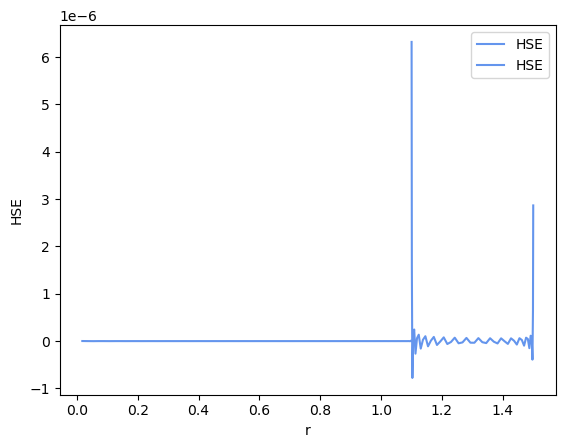

2024-12-02 11:16:44,295 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s
2024-12-02 11:16:44,297 __main__ 0/1 INFO :: Perturbation norm: 2.685e-09
2024-12-02 11:16:44,299 __main__ 0/1 INFO :: HSE in B:1.104e-08
2024-12-02 11:16:44,310 __main__ 0/1 INFO :: HSE in S1:1.268e-07
S1
10
transition index 10 radii [1.10024091 1.1021647  1.10599375 1.11169119 1.11920214 1.12845428
 1.13935849 1.15180977 1.16568821 1.18086014] r_transition 1.1971794511613556


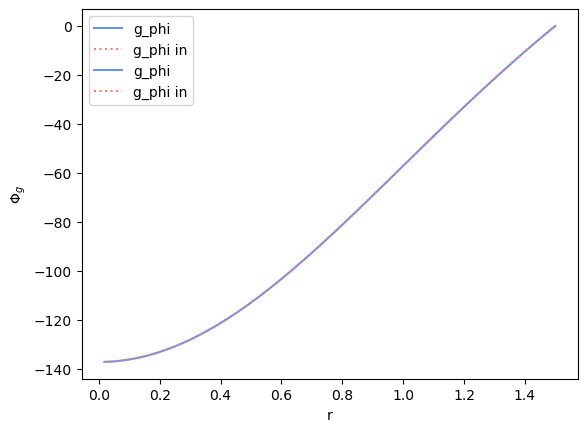

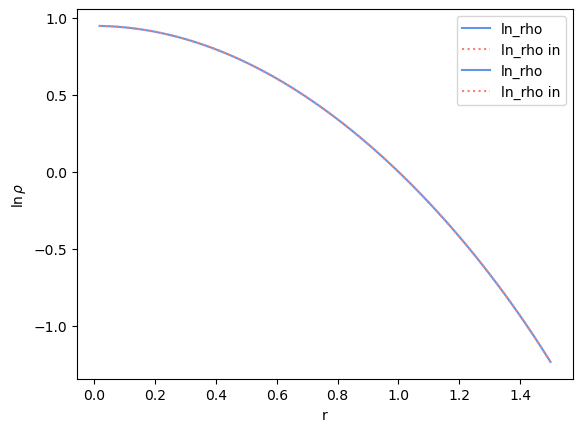

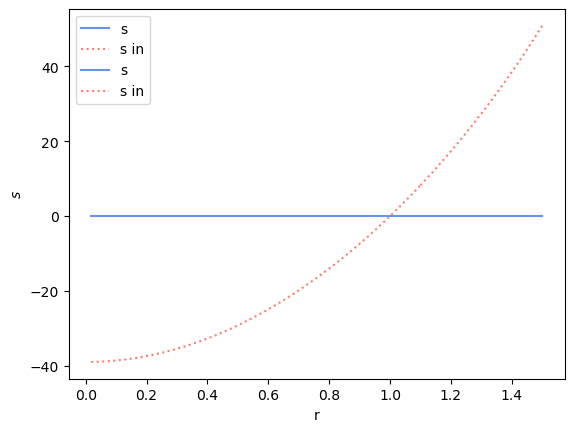

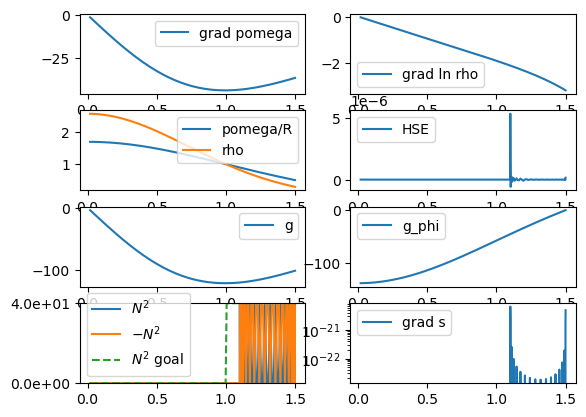

In [62]:
# grad_ln_rho_func = interpolations['grad_ln_rho0']
L_rad_sim = dmr.Luminosity.cgs.value - (L_conv_sim*(r/L_nd)**2 * (4*np.pi)).cgs.value
L_rad_sim/= (r/L_nd)**2 * (4*np.pi)
F_rad_func = interp1d(r/L_nd, L_rad_sim/lum_nd, **interp_kwargs)

chi_rad_func = interpolations['chi_rad']

for k, basis in bases.items():
    phi, theta, r_basis = d.local_grids(basis)
    # print(r)
    if r_basis[0][0][0] > 1.1:
        r_transition=r_basis[0][0][np.where((np.abs(r_basis[0][0]-1.2)/1.2 < 0.01))[0]][0]
print(r_transition)
for k, basis in bases.items():
    if k != 'B':
        print(k)
        phi, theta, r_basis = d.local_grids(basis)
        print(np.where(r_basis[0][0] == r_transition)[0], r_basis[0][0][np.where(r_basis[0][0] == r_transition)[0]])     

N2_func = interp1d(r_nd, tau_nd**2 * smooth_N2, **interp_kwargs)

# plt.plot(r_nd,chi_rad_func(r_nd))
# plt.yscale('log')
# atmo_test_RZ=
r_test_RZ=HSE_solve_RZ_as_CZ(c, d, bases, quantities_CZ, r_transition, chi_rad_func, F_rad_func, N2_func,
              r_outer=r_bound_nd[-1], r_stitch=stitch_radii, \
              R=nondim_R_gas, gamma=nondim_gamma1, G=nondim_G, nondim_radius=1,tolerance=1e-5, HSE_tolerance = 1e-4)

In [63]:
quantities_CZ.keys()

dict_keys(['Q', 's0', 'grad_s', 'g_phi', 'g', 'ln_rho', 'grad_ln_rho', 'rho', 'pomega', 'grad_pomega', 'grad_ln_pomega', 'r_de'])

In [90]:
#given atmo from HSE

def HSE_solve_RZ(coords, dist, bases, quantities_CZ, r_transition, chi_rad_func, Frad_func, N2_func, r_stitch=[], r_outer=1, low_nr=16, \
              R=1, gamma=5/3, G=1, nondim_radius=1, ncc_cutoff=1e-9, tolerance=1e-9, HSE_tolerance = 1e-4):
    """
    Solves for hydrostatic equilibrium in a calorically perfect ideal gas.
    The solution for density, entropy, and gravity is found given a specified function of N^2 and grad ln rho.
    The heating term associated with a convective luminosity is also found given a specified function of the convective flux, Fconv.

    Arguments
    ---------
    coords : Dedalus CoordinateSystem object
        The coordinate system in which the solution is found.
    dist : Dedalus Distributor object
        The distributor object associated with the bases; should NOT be in parallel.
    bases : dict
        A dictionary of Dedalus bases, with keys 'B', 'S1', 'S2', etc. for the Ball basis, first Shell basis, second Shell basis, etc.
    grad_ln_rho_func : function
        A function of radius that returns the gradient of the log of density. Input r should be nondimensionalized.
    N2_func : function
        A function of radius that returns the nondimensionalized Brunt-Vaisala frequency squared. Input r should be nondimensionalized.
    atmo : dict
        A dictionary of Dedalus fields that represent the initial guess for the quantities and their values at fixed inner point r_transition.
    r_transition : float
        The radius at which to start integrating the radiative zone solution.
    r_stitch : list
        A list of radii at which to stitch together the solutions from different bases. 
        The first element should be the radius of the outer boundary of the BallBasis.
        If there is only one basis, r_stitch should be an empty list.
    r_outer : float
        The radius of the outer boundary of the simulation domain.
    low_nr : int
        The number of radial points in the low resolution domain; used to set up background fields for solve. #TODO: make this by-basis.
    R : float
        The nondimensional value of the gas constant divided by the mean molecular weight.
    gamma : float
        The adiabatic index of the gas.
    nondim_radius : float
        The radius where thermodynamics are nondimensionalized.
    ncc_cutoff : float
        The NCC floor for the solver. See Dedalus.core.solvers.SolverBase
    tolerance : float
        The tolerance for perturbation norm of the newton iteration.
    HSE_tolerance : float
        The tolerance for hydrostatic equilibrium of the BVP solve.
    
    Returns
    -------
    atmosphere : dict
        A dictionary of interpolated functions which return atmospheric quantities as a function of nondimensional radius.
    """
    # Parameters
    namespace = dict()
    namespace['G'] = G
    namespace['R'] = R
    namespace['Cp'] = Cp = R*gamma/(gamma-1)
    namespace['gamma'] = gamma
    namespace['log'] = np.log
    namespace['exp'] = np.exp

    # ln_rho_func = interp1d(quantities_CZ['r'], quantities_CZ['ln_rho'], **interp_kwargs)
    # g_phi_func = interp1d(quantities_CZ['r'], quantities_CZ['g_phi'], **interp_kwargs)
    # Q_func = interp1d(quantities_CZ['r'], quantities_CZ['Q'], **interp_kwargs)
    #Loop over bases, set up fields and operators.
    for k, basis in bases.items():
        namespace['basis_{}'.format(k)] = basis
        namespace['S2_basis_{}'.format(k)] = S2_basis = basis.S2_basis()

        # Make problem variables and taus.
        namespace['g_phi_{}'.format(k)] = g_phi = dist.Field(name='g_phi', bases=basis)
        namespace['Q_{}'.format(k)] = Q = dist.Field(name='Q', bases=basis)
        namespace['s_{}'.format(k)] = s = dist.Field(name='s', bases=basis)
        namespace['g_{}'.format(k)] = g = dist.VectorField(coords, name='g', bases=basis)
        namespace['ln_rho_{}'.format(k)] = ln_rho = dist.Field(name='ln_rho', bases=basis)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = dist.VectorField(coords, name='grad_ln_rho', bases=basis)
        namespace['pomega_{}'.format(k)] = pomega = dist.Field(name='pomega', bases=basis)
        namespace['tau_s_{}'.format(k)] = tau_s = dist.Field(name='tau_s', bases=S2_basis)
        namespace['tau_rho_{}'.format(k)] = tau_rho = dist.Field(name='tau_rho', bases=S2_basis)
        namespace['tau_pomega_{}'.format(k)] = tau_rho = dist.Field(name='tau_rho', bases=S2_basis)
        namespace['tau_g_phi_{}'.format(k)] = tau_g_phi = dist.Field(name='tau_g_phi', bases=S2_basis)
        namespace['tau_g_phi_1_{}'.format(k)] = tau_g_phi_1 = dist.Field(name='tau_g_phi_1', bases=S2_basis)
        namespace['tau_g_phi_2_{}'.format(k)] = tau_g_phi_2 = dist.Field(name='tau_g_phi_2', bases=S2_basis)

        # Set up some fundamental grid data
        low_scales = low_nr/basis.radial_basis.radial_size 
        phi, theta, r = dist.local_grids(basis)
        phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
        phi_low, theta_low, r_low = dist.local_grids(basis, scales=(1,1,low_scales))
        namespace['r_de_{}'.format(k)] = r_de
        namespace['r_vec_{}'.format(k)] = r_vec = dist.VectorField(coords, bases=basis.radial_basis)
        r_vec['g'][2] = r
        namespace['r_squared_{}'.format(k)] = r_squared = dist.Field(bases=basis.radial_basis)
        r_squared['g'] = r**2       

        # Make lift operators for BCs
        if k == 'B':
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis, -1)
        else:
            namespace['lift_{}'.format(k)] = lift = lambda A: d3.Lift(A, basis.derivative_basis(2), -1)
            namespace['lift2_{}'.format(k)] = lift2 = lambda A: d3.Lift(A, basis.derivative_basis(2), -2)

        # Make a field of ones for converting NCCs to full fields.
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1

        #make a field of 4piG*ones
        namespace['four_pi_G_{}'.format(k)] = four_pi_G = dist.Field(bases=basis, name='four_pi_G')
        four_pi_G['g'] = 4*np.pi*G*ones['g']

        #Make a field that smooths at the edge of the ball basis.
        namespace['edge_smoothing_{}'.format(k)] = edge_smooth = dist.Field(bases=basis, name='edge_smooth')
        edge_smooth['g'] = one_to_zero(r, 0.95*bases['B'].radius, width=0.03*bases['B'].radius)

        # Get a high-resolution N^2 in the ball; low-resolution elsewhere where it transitions more gradually.
        namespace['N2_{}'.format(k)] = N2 = dist.Field(bases=basis, name='N2')
        if k == 'B':
            N2['g'] = N2_func(r)
        else:
            N2.change_scales(low_scales)
            N2['g'] = N2_func(r_low)
        # not used in the integration of equations, but keep N2_func for comparison at the end

        # Set the radiative flux.
        namespace['Frad_{}'.format(k)] = Frad = dist.VectorField(coords, name='Frad', bases=basis)
        Frad['g'][2] = Frad_func(r)

        # Set ln rho initial guess.
        namespace['ln_rho_in_{}'.format(k)] = ln_rho_in = dist.Field(bases=basis, name='ln_rho_in')
        namespace['grad_ln_rho_in_{}'.format(k)] = grad_ln_rho_in = dist.VectorField(coords,bases=basis, name='grad_ln_rho_in')
        ln_rho_in.change_scales(basis.dealias)
        grad_ln_rho_in.change_scales(basis.dealias)
        if k == 'B':
            dealias_length = int(basis.shape[-1]*basis.dealias[-1])
            ln_rho_in['g'] = quantities_CZ['ln_rho'][:dealias_length]
            grad_ln_rho_in['g'][2] = quantities_CZ['grad_ln_rho'][:dealias_length]
        elif k == 'S1':
            ln_rho_in['g'] = quantities_CZ['ln_rho'][dealias_length:]
            namespace['ln_rho_r_transition'] = namespace['ln_rho_in_{}'.format(k)](r=r_transition)
            grad_ln_rho_in['g'][2] = quantities_CZ['grad_ln_rho'][dealias_length:]
            namespace['grad_ln_rho_r_transition'] = namespace['grad_ln_rho_in_{}'.format(k)](r=r_transition)
        # ln_rho_in['g'] = ln_rho_func(r)

        # set initial guess for g_phi
        namespace['g_phi_in_{}'.format(k)] = g_phi_in = dist.Field(bases=basis, name='g_phi_in')
        g_phi_in.change_scales(basis.dealias)
        if k == 'B':
            g_phi_in['g'] = quantities_CZ['g_phi'][:dealias_length]
        elif k == 'S1':
            g_phi_in['g'] = quantities_CZ['g_phi'][dealias_length:]
            namespace['g_phi_r_transition'] = namespace['g_phi_in_{}'.format(k)](r=r_transition)

        # set initial value for g
        namespace['g_in_{}'.format(k)] = g_in = dist.VectorField(coords,bases=basis, name='g_in')
        g_in.change_scales(basis.dealias)
        if k == 'B':
            g_in['g'][2] = quantities_CZ['g'][:dealias_length]
        elif k == 'S1':
            g_in['g'][2] = quantities_CZ['g'][dealias_length:]
            namespace['g_r_transition'] = namespace['g_in_{}'.format(k)](r=r_transition)
        
        # set initial value for pomega
        namespace['pomega_in_{}'.format(k)] = pomega_in = dist.Field(bases=basis, name='pomega_in')
        namespace['grad_pomega_in_{}'.format(k)] = grad_pomega_in = dist.VectorField(coords,bases=basis, name='grad_pomega_in')
        pomega_in.change_scales(basis.dealias)
        grad_pomega_in.change_scales(basis.dealias)
        if k == 'B':
            pomega_in['g'] = quantities_CZ['pomega'][:dealias_length]
            grad_pomega_in['g'][2] = quantities_CZ['grad_pomega'][:dealias_length]
        elif k == 'S1':
            pomega_in['g'] = quantities_CZ['pomega'][dealias_length:]
            namespace['pomega_r_transition'] = namespace['pomega_in_{}'.format(k)](r=r_transition)
            grad_pomega_in['g'][2] = quantities_CZ['grad_pomega'][dealias_length:]
            namespace['grad_pomega_r_transition'] = namespace['grad_pomega_in_{}'.format(k)](r=r_transition)

        # set initial value for s0
        namespace['s0_in_{}'.format(k)] = s0_in = dist.Field(bases=basis, name='s0_in')
        s0_in.change_scales(basis.dealias)
        if k == 'B':
            s0_in['g'] = quantities_CZ['s0'][:dealias_length]
        elif k == 'S1':
            s0_in['g'] = quantities_CZ['s0'][dealias_length:]
            namespace['s0_r_transition'] = namespace['s0_in_{}'.format(k)](r=r_transition)

        # Set value of Q (just comes from before)
        Q.change_scales(basis.dealias)
        if k == 'B':
            Q['g'] = quantities_CZ['Q'][:dealias_length]
        elif k == 'S1':
            Q['g'] = quantities_CZ['Q'][dealias_length:]
        # Set chi_rad
        #first calculate what value should be at transition point
        # chi_rad_r_transition = - (F_rad_func(r_transition)*R/np.exp(ln_rho_in(r=r_transition))/Cp/(grad_pomega_in(r=r_transition))).evaluate()['g'][2]
        # namespace['chi_rad_{}'.format(k)] = chi_rad   = dist.Field(name='chi_rad', bases=basis)
        
        # chi_rad['g'] = chi_rad_func(r)
        # chi_rad_diff = chi_rad['g'][0][0][0]-chi_rad_r_transition
        # print(k,chi_rad_r_transition,chi_rad_diff)
        # chi_rad['g'] -= chi_rad_diff
            
        #### chi_rad_func should be a function of rho, T now, not a field. make sure it is implemented below
            

        # Create important operations from the fields.
        namespace['ln_pomega_LHS_{}'.format(k)] = ln_pomega_LHS = gamma*(s/Cp + ((gamma-1)/gamma)*ln_rho*ones)
        namespace['ln_pomega_{}'.format(k)] = ln_pomega = ln_pomega_LHS + np.log(R)
        # namespace['pomega_{}'.format(k)] = pomega = np.exp(ln_pomega) #this goes into the equations
        namespace['P_{}'.format(k)] = P = pomega*np.exp(ln_rho)
        namespace['HSE_{}'.format(k)] = HSE = gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) + d3.grad(g_phi)*ones
        #gamma*pomega*(d3.grad(ones*ln_rho) + d3.grad(s)/Cp) - g*ones
        namespace['N2_op_{}'.format(k)] = N2_op = d3.grad(g_phi)@d3.grad(s)/Cp
        namespace['rho_{}'.format(k)] = rho = np.exp(ln_rho*ones)
        namespace['grad_ln_rho_{}'.format(k)] = grad_ln_rho = d3.grad(ln_rho)
        namespace['T_{}'.format(k)] = T = pomega/R
        namespace['ln_T_{}'.format(k)] = ln_T = np.log(pomega) - np.log(R) # ln_pomega - np.log(R)
        namespace['grad_pomega_{}'.format(k)] = grad_pomega = d3.grad(pomega)
        namespace['grad_ln_pomega_{}'.format(k)] = d3.grad(np.log(pomega)) #d3.grad(ln_pomega)
        namespace['grad_s_{}'.format(k)] = grad_s = d3.grad(s)
        namespace['r_vec_g_{}'.format(k)] = r_vec@g
        namespace['g_op_{}'.format(k)] = gamma * pomega * (d3.grad(s)/Cp + d3.grad(ln_rho))
        namespace['s0_{}'.format(k)] = Cp * ((1/gamma)*(np.log(pomega) + ln_rho) - ln_rho) #s with an offset so s0 = cp * (1/gamma * lnP - ln_rho)
        # namespace['Frad_op_{}'.format(k)] = rho * Cp * chi_rad * grad_pomega/R  # = - F_rad
        namespace['chi_rad_{}'.format(k)] = chi_rad = chi_rad_func(np.exp(ln_rho), T)
        namespace['Frad_op_{}'.format(k)] = Frad_op = Frad*R/(rho * Cp * chi_rad) # = - grad (pomega)
        # print('Frad',Frad_op['g'][2])
    namespace['pi'] = np.pi
    
    locals().update(namespace)

    for k, basis in bases.items():
        phi, theta, r = dist.local_grids(basis)
        namespace['ones_{}'.format(k)] = ones = dist.Field(bases=basis, name='ones')
        ones['g'] = 1
        
        namespace['HSE_in_{}'.format(k)] = HSE_in = gamma*namespace['pomega_in_{}'.format(k)]*(d3.grad(ones*namespace['ln_rho_in_{}'.format(k)]) + d3.grad(namespace['s0_in_{}'.format(k)])/Cp) + d3.grad(namespace['g_phi_in_{}'.format(k)])*ones
        this_HSE = np.max(np.abs(namespace['HSE_in_{}'.format(k)].evaluate()['g']))
        print('this HSE',this_HSE)

    print('values at r_transition',
          'pomega',namespace['pomega_r_transition'].evaluate()['g'],
          'grad_pomega',namespace['grad_pomega_r_transition'].evaluate()['g'][2],
          's0',namespace['s0_r_transition'].evaluate()['g'],
          'ln_rho',namespace['ln_rho_r_transition'].evaluate()['g'],
          'grad_ln_rho',namespace['grad_ln_rho_r_transition'].evaluate()['g'][2],
          'g_phi',namespace['g_phi_r_transition'].evaluate()['g'],
          'g',namespace['g_r_transition'].evaluate()['g'][2])
    
    
    # Solve for radiative temperature gradient, HSE, and EOS in rad zone only (e.g. only in S1)
    variables, taus = [], []
    for k, basis in bases.items():
        # set values of the fields up until the transition point
        if k == 'B':
            # phi, theta, r = dist.local_grids(basis)
            # phi_de, theta_de, r_de = dist.local_grids(basis, scales=basis.dealias)
            namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
            namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
            namespace['s_{}'.format(k)].change_scales(basis.dealias)
            namespace['pomega_{}'.format(k)].change_scales(basis.dealias)

            namespace['g_phi_{}'.format(k)]['g'] = namespace['g_phi_in_{}'.format(k)]['g']
            namespace['ln_rho_{}'.format(k)]['g']  = namespace['ln_rho_in_{}'.format(k)]['g']
            namespace['pomega_{}'.format(k)]['g']  = namespace['pomega_in_{}'.format(k)]['g']
            namespace['s_{}'.format(k)]['g'] = 0
            #ln pomega comes from these
            

        if k != 'B':
            variables += [namespace['g_phi_{}'.format(k)],
                          namespace['s_{}'.format(k)],namespace['ln_rho_{}'.format(k)],
                          namespace['pomega_{}'.format(k)] ]
            
            taus += [ namespace['tau_g_phi_1_{}'.format(k)], 
                     namespace['tau_g_phi_{}'.format(k)], 
                     namespace['tau_pomega_{}'.format(k)]] #,namespace['tau_s_{}'.format(k)],
        #,namespace['tau_s_{}'.format(k)]
        # if k != 'B':
            taus += [namespace['tau_g_phi_2_{}'.format(k)],]
        # variables += [namespace['s_{}'.format(k)],]
        
        # taus += [namespace['tau_s_{}'.format(k)], ]

    print('variables',len(variables),'taus',len(taus))
    problem = d3.NLBVP(variables + taus, namespace=locals())
    count_eqn = 0
    for k, basis in bases.items():
        if k != 'B':
            # Set a decent initial guess for s.
            # namespace['s_{}'.format(k)].change_scales(basis.dealias)
            # namespace['s_{}'.format(k)]['g'] = -(R*namespace['ln_rho_in_{}'.format(k)]).evaluate()['g']
            # Set a decent initial guess for ln_rho.
            namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
            namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
            namespace['ln_rho_{}'.format(k)]['g'] = np.copy(namespace['ln_rho_in_{}'.format(k)]['g'])
        
            # set initial guess for g_phi
            namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
            namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
            namespace['g_phi_{}'.format(k)]['g'] = np.copy(namespace['g_phi_in_{}'.format(k)].evaluate()['g'])

            # set initial guess for pomega
            namespace['pomega_{}'.format(k)].change_scales(basis.dealias)
            namespace['pomega_in_{}'.format(k)].change_scales(basis.dealias)
            namespace['pomega_{}'.format(k)]['g'] = np.copy(namespace['pomega_in_{}'.format(k)].evaluate()['g'])
            #Set the equations: poisson
            # if k != 'B':
            problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0}) + lift_{0}(tau_g_phi_1_{0}) + lift2_{0}(tau_g_phi_2_{0}) = 0".format(k))
            count_eqn+=1
            # elif k == 'B':
            #     problem.add_equation("lap(g_phi_{0}) - four_pi_G_{0}*exp(ln_rho_{0}*ones_{0})  + lift_{0}(tau_g_phi_1_{0}) = 0".format(k))
            #     count_eqn+=1
            
            #Set the equations: hydrostatic equilibrium
            problem.add_equation("-grad(g_phi_{0}) + r_vec_{0}*lift_{0}(tau_g_phi_{0}) = g_op_{0} ".format(k))
            # this has grad_s in it
            #Set equation for radiative temperature gradient
            # problem.add_equation("grad(s_{0}) + r_vec_{0}*lift_{0}(tau_s_{0}) = 0 ".format(k))
            problem.add_equation(" -grad(pomega_{0}) + r_vec_{0}*lift_{0}(tau_pomega_{0}) = Frad_op_{0}".format(k))  #Frad_op_{0}
            problem.add_equation("pomega_{0} = exp(ln_pomega_{0})".format(k))
            count_eqn+=3
        
            
        # problem.add_equation("Q_{0} = edge_smoothing_{0}*div(Fconv_{0})".format(k))
        # count_eqn+=1
    
    #Set the boundary conditions.
    iter = 0
    for k, basis in bases.items():
        if k != 'B':
            k_old = list(bases.keys())[iter-1]
            r_s = r_stitch[iter-1]
            # problem.add_equation("ln_rho_{0}(r={2}) - ln_rho_{1}(r={2}) = 0".format(k, k_old, r_s))
            # problem.add_equation("s_{0}(r={2}) - s_{1}(r={2}) = 0".format(k, k_old, r_s))
            # problem.add_equation("g_phi_{0}(r={2}) - g_phi_{1}(r={2}) = 0".format(k, k_old, r_s))
            # problem.add_equation("grad(g_phi_{0})(r={2}) - grad(g_phi_{1})(r={2}) = 0".format(k, k_old, r_s))
            # count_eqn+=4
        iter += 1
        # if iter == len(bases.items()):
            # problem.add_equation("g_phi_{0}(r=r_outer) = g_phi_in_{0}(r=r_outer)".format(k))
            # problem.add_equation("g_phi_{0}(r=r_outer) = 0".format(k))
            # count_eqn+=1
    #fix them to the values at the transition point 
    # problem.add_equation("grad(pomega_S1)(r=r_transition) = grad_pomega_r_transition")
    problem.add_equation("pomega_S1(r=r_transition) = pomega_r_transition")
    problem.add_equation("ln_rho_S1(r=r_transition) = ln_rho_r_transition")
    # problem.add_equation("grad(ln_rho_S1)(r=r_transition) = grad_ln_rho_r_transition")
    problem.add_equation("g_phi_S1(r=r_transition) = g_phi_r_transition") 
    problem.add_equation(" - grad(g_phi_S1)(r=r_transition) = g_r_transition")
    # count_eqn+=4
    print('number of eqns',count_eqn)

    #Solve with tolerances on pert_norm and hydrostatic equilibrium.
    solver = problem.build_solver(ncc_cutoff=ncc_cutoff)
    pert_norm = np.inf
    while pert_norm > tolerance or HSE_err > HSE_tolerance:
        # print("Frad",#namespace['Frad_op_{}'.format(k)]['g'][0],
                  #namespace['Frad_op_{}'.format(k)]['g'][1],
                #   namespace['Frad_op_{}'.format(k)]['g'][2])
        # print("pomega",d3.grad(namespace['pomega_{}'.format(k)]).evaluate()['g'][0],
        #           d3.grad(namespace['pomega_{}'.format(k)]).evaluate()['g'][1],
        #           d3.grad(namespace['pomega_{}'.format(k)]).evaluate()['g'][2])
        plt.figure()
        for k, basis in bases.items():
            plt.ylabel(r'HSE')
            plt.xlabel(r'r')
            plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['HSE_{}'.format(k)]['g'][2,0,0,:],label='HSE',c='cornflowerblue')
        plt.legend()
        plt.show()
        HSE_err = 0
        solver.newton_iteration(damping=1)
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info(f'Perturbation norm: {pert_norm:.3e}')
        for k, basis in bases.items():
            this_HSE = np.max(np.abs(namespace['HSE_{}'.format(k)].evaluate()['g']))
            logger.info('HSE in {}:{:.3e}'.format(k, this_HSE))
            if this_HSE > HSE_err:
                HSE_err = this_HSE


    # in S1, replace values up until r_transition with input atmo values
    # for k, basis in bases.items():
    #     if k != 'B':
    #         print(k)
    #         phi, theta, r = dist.local_grids(basis)
    #         transition_index = np.where(r[0][0] == r_transition)[0][0]
    #         print(transition_index)
    #         print('transition', 'index', transition_index, 'radii' ,
    #               r[0][0][:transition_index],'r_transition',r_transition)   
    #         namespace['g_phi_in_{}'.format(k)].change_scales(1)
    #         namespace['ln_rho_in_{}'.format(k)].change_scales(1)
    #         namespace['g_phi_{}'.format(k)].change_scales(1)
    #         namespace['ln_rho_{}'.format(k)].change_scales(1)
    #         namespace['g_phi_{}'.format(k)]['g'][0,0,:transition_index] = namespace['g_phi_in_{}'.format(k)]['g'][0,0,:transition_index]
    #         namespace['pomega_{}'.format(k)]['g'][0,0,:transition_index] = namespace['pomega_in_{}'.format(k)]['g'][0,0,:transition_index]
    #         namespace['ln_rho_{}'.format(k)]['g'][0,0,:transition_index] = namespace['ln_rho_in_{}'.format(k)]['g'][0,0,:transition_index]
    #         namespace['s0_{}'.format(k)]['g'][0,0,:] += namespace['s0_in_{}'.format(k)]['g'][0,0,transition_index]

    plt.figure()
    for k, basis in bases.items():
        namespace['g_phi_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_phi_in_{}'.format(k)].change_scales(basis.dealias)
        namespace['g_{}'.format(k)] = -d3.grad(namespace['g_phi_{}'.format(k)])
        
        plt.ylabel(r'$\Phi_g$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_{}'.format(k)]['g'][0,0,:],label='g_phi',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['g_phi_in_{}'.format(k)]['g'][0,0,:],label='g_phi in',c='salmon',ls=':')
    plt.legend()
    plt.figure()
    for k, basis in bases.items():
        namespace['ln_rho_{}'.format(k)].change_scales(basis.dealias)
        namespace['ln_rho_in_{}'.format(k)].change_scales(basis.dealias)
        
        plt.ylabel(r'$\ln \rho$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_{}'.format(k)]['g'][0,0,:],label='ln_rho',c='cornflowerblue')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['ln_rho_in_{}'.format(k)]['g'][0,0,:],label='ln_rho in',c='salmon',ls=':')
    plt.legend()

    plt.figure()
    for k, basis in bases.items():
        plt.ylabel(r'$s$')
        plt.xlabel(r'r')
        plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['s0_{}'.format(k)]['g'][0,0,:],label='s0',c='cornflowerblue')
        # plt.plot(namespace['r_de_{}'.format(k)][0,0,:], namespace['s_{}'.format(k)]['g'][0,0,:],label='s',c='cornflowerblue')

        # plt.plot(namespace['r_de_{}'.format(k)][0,0,:], -(R*namespace['ln_rho_in_{}'.format(k)]).evaluate()['g'][0,0,:],label='s in',c='salmon',ls=':')
    plt.legend()
    

    # #now, when stitch together, make sure to combine the one for the CZ with the one for the RZ
    # # Stitch together the fields for creation of interpolators that span the full simulation domain.
    # #Need: grad_pom0, grad_ln_pom0, grad_ln_rho0, grad_s0, g, pom0, rho0, ln_rho0, g_phi
    stitch_fields = OrderedDict()
    fields = ['grad_pomega', 'grad_ln_pomega', 'grad_ln_rho', 'grad_s', 'g', 'pomega', 'rho', 'ln_rho', 'g_phi', 'r_vec', 'HSE', 'N2_op', 'Q', 's0']
    for f in fields:
        stitch_fields[f] = []
    
    for k, basis in bases.items():
        for f in fields:
            if f == 'r_vec':
                namespace['{}_{}'.format(f, k)].change_scales(basis.dealias)
                # stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'][2])]
            stitch_fields[f] += [np.copy(namespace['{}_{}'.format(f, k)].evaluate()['g'])]

    if len(stitch_fields['r_vec']) == 1:
        for f in fields:
            stitch_fields[f] = stitch_fields[f][0]
    else:
        for f in fields:
            stitch_fields[f] = np.concatenate(stitch_fields[f], axis=-1)

    grad_pom = stitch_fields['grad_pomega'][2,:].ravel()
    grad_ln_pom = stitch_fields['grad_ln_pomega'][2,:].ravel()
    grad_ln_rho = stitch_fields['grad_ln_rho'][2,:].ravel()
    grad_s = stitch_fields['grad_s'][2,:].ravel()
    g = stitch_fields['g'][2,:].ravel()
    HSE = stitch_fields['HSE'][2,:].ravel()
    r = stitch_fields['r_vec'][2,:].ravel()

    pom = stitch_fields['pomega'].ravel()
    rho = stitch_fields['rho'].ravel()
    ln_rho = stitch_fields['ln_rho'].ravel()
    g_phi = stitch_fields['g_phi'].ravel()
    N2 = stitch_fields['N2_op'].ravel()
    Q = stitch_fields['Q'].ravel()
    s0 = stitch_fields['s0'].ravel()


    #Plot the results.
    fig = plt.figure(figsize=(8,12))
    ax1 = fig.add_subplot(4,2,1)
    ax2 = fig.add_subplot(4,2,2)
    ax3 = fig.add_subplot(4,2,3)
    ax4 = fig.add_subplot(4,2,4)
    ax5 = fig.add_subplot(4,2,5)
    ax6 = fig.add_subplot(4,2,6)
    ax7 = fig.add_subplot(4,2,7)
    ax8 = fig.add_subplot(4,2,8)
    ax1.plot(r, grad_pom, label='grad pomega')
    ax1.legend()
    ax2.plot(r, grad_ln_rho, label='grad ln rho')
    ax2.legend()
    ax3.plot(r, pom/R, label='pomega/R')
    ax3.plot(r, rho, label='rho')
    ax3.legend()
    ax4.plot(r, HSE, label='HSE')
    ax4.legend()
    ax5.plot(r, g, label='g')
    ax5.legend()
    ax6.plot(r, g_phi, label='g_phi')
    ax6.legend()
    ax7.plot(r, N2, label=r'$N^2$')
    ax7.plot(r, -N2, label=r'$-N^2$')
    ax7.plot(r, (N2_func(r)), label=r'$N^2$ goal', ls='--')
    
    yticks = (np.max(np.abs(N2.ravel()[r.ravel() < 0.5])), np.max(N2_func(r).ravel()))
    print(yticks)
    ax7.set_yticks(yticks)
    ax7.set_yticklabels(['{:.1e}'.format(n) for n in yticks])
    ax7.set_yscale('log')
    ax7.legend()
    ax8.plot(r, grad_s, label='grad s')
    ax8.set_yscale('log')
    ax8.legend()
    # fig.savefig('stratification.png', bbox_inches='tight', dpi=300)
    plt.subplots_adjust(hspace=0.25,wspace=0.25)
    #Create interpolators for the atmosphere.
    atmosphere = dict()
    atmosphere['grad_pomega'] = interp1d(r, grad_pom, **interp_kwargs)
    atmosphere['grad_ln_pomega'] = interp1d(r, grad_ln_pom, **interp_kwargs)
    atmosphere['grad_ln_rho'] = interp1d(r, grad_ln_rho, **interp_kwargs)
    atmosphere['grad_s'] = interp1d(r, grad_s, **interp_kwargs)
    atmosphere['g'] = interp1d(r, g, **interp_kwargs)
    atmosphere['pomega'] = interp1d(r, pom, **interp_kwargs)
    atmosphere['rho'] = interp1d(r, rho, **interp_kwargs)
    atmosphere['ln_rho'] = interp1d(r, ln_rho, **interp_kwargs)
    atmosphere['g_phi'] = interp1d(r, g_phi, **interp_kwargs)
    atmosphere['N2'] = interp1d(r, N2, **interp_kwargs)
    atmosphere['Q'] = interp1d(r, Q, **interp_kwargs)
    atmosphere['s0'] = interp1d(r, s0, **interp_kwargs)
    return atmosphere
    return r

1.1002409087589655
S1
[0] [1.10024091]
B [[[2.92268917e-09]]] [[[-1.48150429e-09]]]
S1 [[[2.9226893e-09]]] [[[-3.55208565e-10]]]
this HSE 1.4068575637793401e-08
this HSE 6.320400999015874e-06
values at r_transition pomega [[[36.66969925]]] grad_pomega [[[-43.28589897]]] s0 [[[272.03487056]]] ln_rho [[[-0.20074553]]] grad_ln_rho [[[-2.10676178]]] g_phi [[[-44.97251102]]] g [[[-120.5402252]]]
variables 4 taus 4


/home/swu/miniconda3/envs/dedalus3/lib/python3.9/site-packages/dedalus/core/operators.py:384: RuntimeWarning: divide by zero encountered in power
  np.power(arg0.data, arg1, out.data)


number of eqns 4


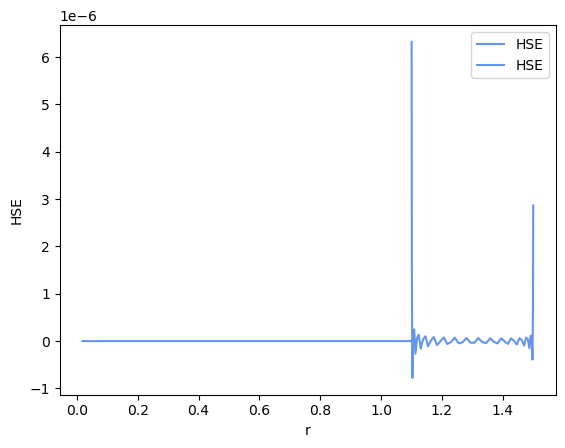

2024-12-02 11:21:20,505 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2024-12-02 11:21:20,508 __main__ 0/1 INFO :: Perturbation norm: 4.619e+00
2024-12-02 11:21:20,509 __main__ 0/1 INFO :: HSE in B:1.281e-08
2024-12-02 11:21:20,511 __main__ 0/1 INFO :: HSE in S1:9.252e-02


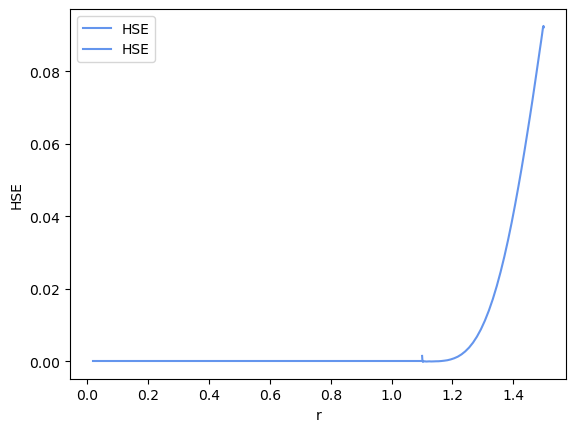

2024-12-02 11:21:21,188 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2024-12-02 11:21:21,191 __main__ 0/1 INFO :: Perturbation norm: 3.047e-02
2024-12-02 11:21:21,193 __main__ 0/1 INFO :: HSE in B:1.281e-08
2024-12-02 11:21:21,194 __main__ 0/1 INFO :: HSE in S1:1.638e-03


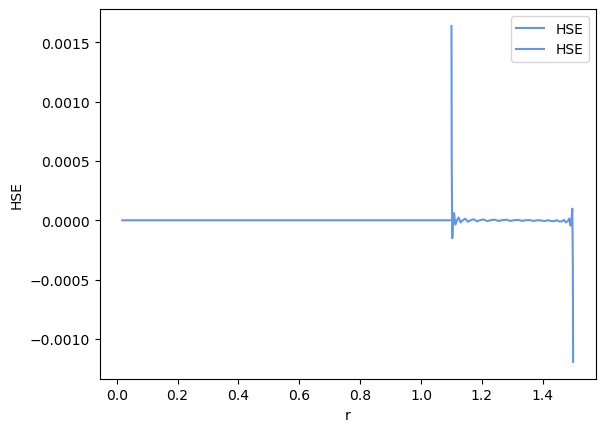

2024-12-02 11:21:21,886 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2024-12-02 11:21:21,889 __main__ 0/1 INFO :: Perturbation norm: 1.523e-05
2024-12-02 11:21:21,891 __main__ 0/1 INFO :: HSE in B:1.281e-08
2024-12-02 11:21:21,893 __main__ 0/1 INFO :: HSE in S1:1.621e-03


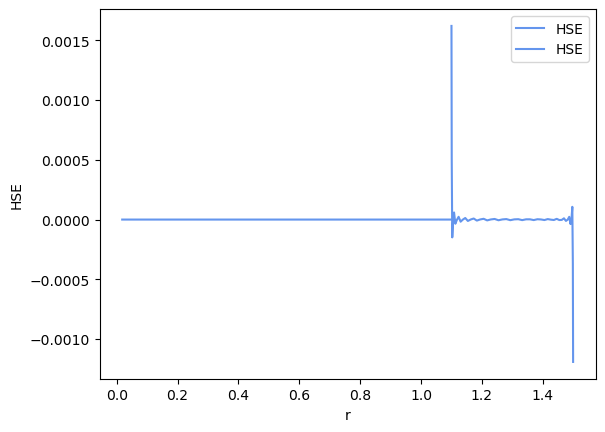

2024-12-02 11:21:22,592 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2024-12-02 11:21:22,595 __main__ 0/1 INFO :: Perturbation norm: 3.555e-08
2024-12-02 11:21:22,596 __main__ 0/1 INFO :: HSE in B:1.281e-08
2024-12-02 11:21:22,598 __main__ 0/1 INFO :: HSE in S1:1.621e-03
(0.0, 39.523557008553695)


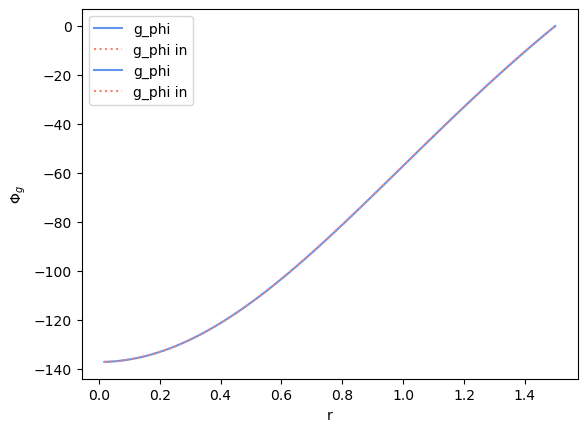

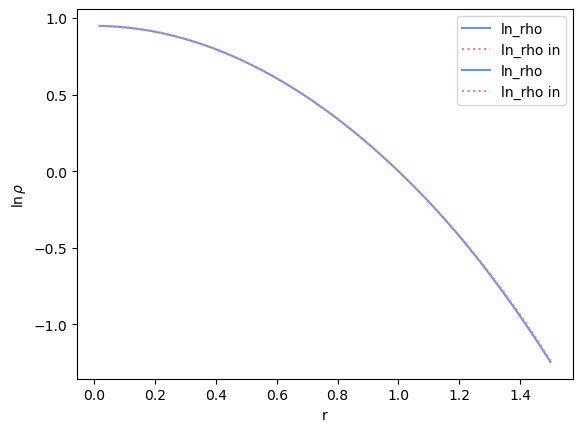

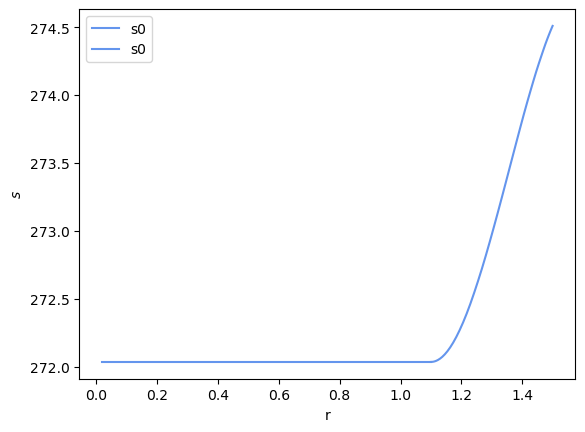

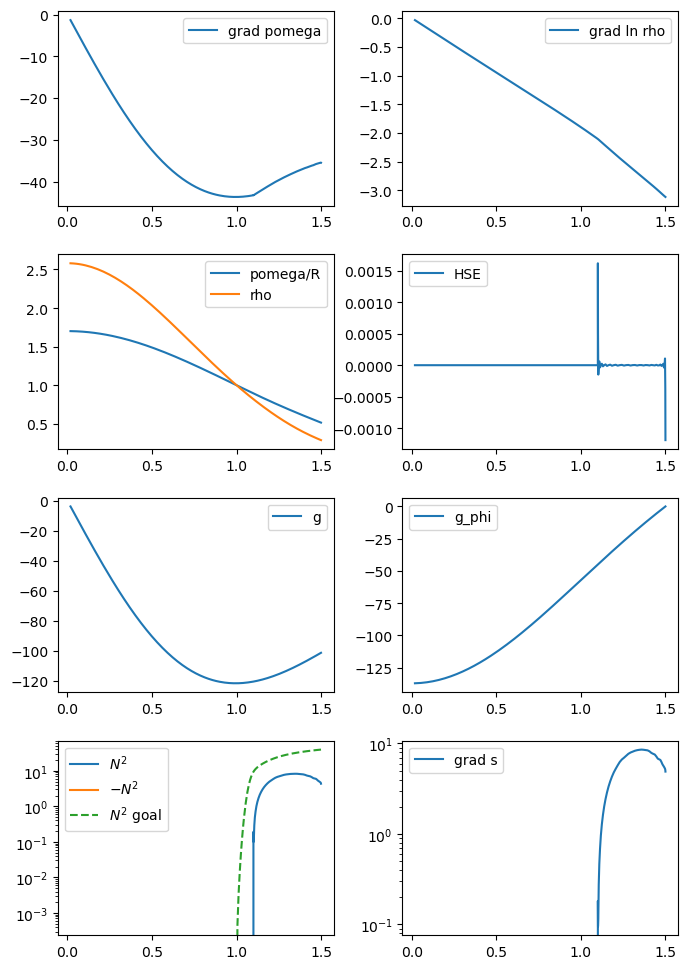

In [91]:
# grad_ln_rho_func = interpolations['grad_ln_rho0']
L_rad_sim = dmr.Luminosity.cgs.value - (L_conv_sim*(r/L_nd)**2 * (4*np.pi)).cgs.value
L_rad_sim/= (r/L_nd)**2 * (4*np.pi)
F_rad_func = interp1d(r/L_nd, L_rad_sim/lum_nd, **interp_kwargs)

# chi_rad_func = interpolations['chi_rad']
# chi_rad_func = interp1d(r_nd, rad_diff_nd, **interp_kwargs)
# opacity_info_arr = [gff_out, z_frac_out, x_frac_out,ye_out]
opacity_func_in = lambda rho, T: opacity_func(rho*rho_nd,T*T_nd,gff=gff_out,z_frac=z_frac_out,x_frac=x_frac_out,ye=ye_out)
#assuming rho, T are nondimensionalized inputs, but opacity_func returns a dimensionalized opacity 
chi_rad_func = lambda rho,T: (16 * constants.sigma_sb.cgs * (T*T_nd)**3 / (3 * (rho*rho_nd)**2 * cp * opacity_func_in(rho,T))) * (tau_nd / L_nd**2)
#assuming rho, T are nondimensionalized inputs, but will return dimensionalized rad_diff so must non-dimensionalize

value_to_use = 1.1 #1.2
for k, basis in bases.items():
    phi, theta, r_basis = d.local_grids(basis)
    # print(r)
    if r_basis[0][0][0] > 1.1:
        r_transition=r_basis[0][0][np.where((np.abs(r_basis[0][0]-value_to_use)/value_to_use < 0.01))[0]][0]
print(r_transition)
for k, basis in bases.items():
    if k != 'B':
        print(k)
        phi, theta, r_basis = d.local_grids(basis)
        print(np.where(r_basis[0][0] == r_transition)[0], r_basis[0][0][np.where(r_basis[0][0] == r_transition)[0]])     

N2_func = interp1d(r_nd, tau_nd**2 * smooth_N2, **interp_kwargs)

# plt.plot(r_nd,chi_rad_func(r_nd))
# plt.yscale('log')
# atmo_test_RZ=
atmo_test_RZ=HSE_solve_RZ(c, d, bases, quantities_CZ, r_transition, chi_rad_func, F_rad_func, N2_func,
              r_outer=r_bound_nd[-1], r_stitch=stitch_radii, \
              R=nondim_R_gas, gamma=nondim_gamma1, G=nondim_G, nondim_radius=1,tolerance=1e-5, HSE_tolerance = 2e-3)

### check RZ solver

Text(0.5, 0, 'r')

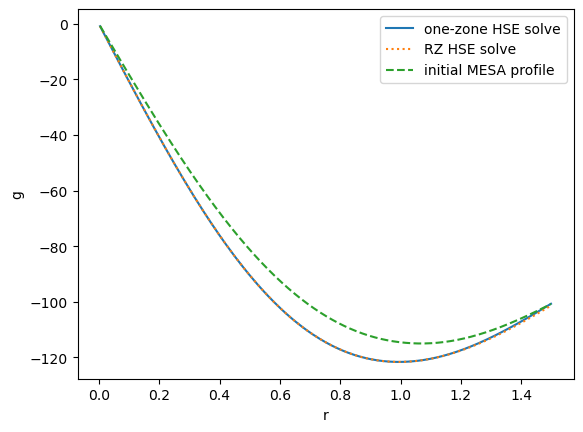

In [98]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='one-zone HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_RZ['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='RZ HSE solve',ls=':')

# plt.plot(quantities_CZ['r'],quantities_CZ['g'],ls=':',color='black')

plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='initial MESA profile',ls='--')
plt.legend()
plt.ylabel('g')
plt.xlabel('r')

Text(0, 0.5, '$\\Phi_g$')

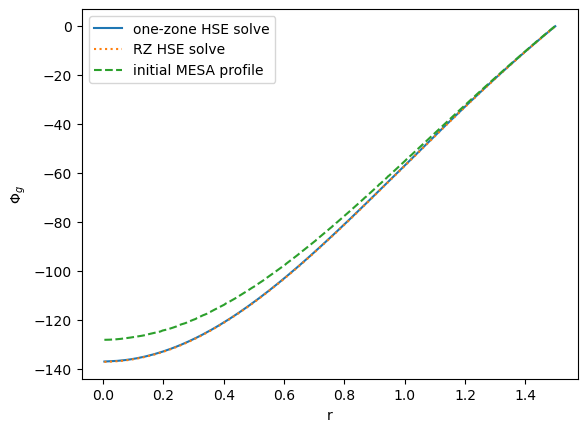

In [99]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='one-zone HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_RZ['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='RZ HSE solve',ls=':')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])-interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])[-1],label='initial MESA profile',ls='--')
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\Phi_g$')

Text(0, 0.5, '$s_0$')

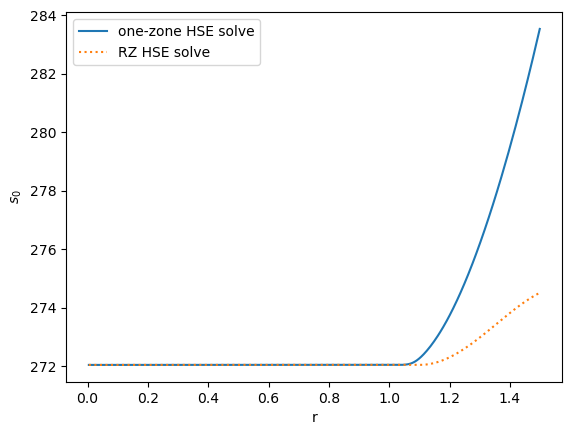

In [101]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['s0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='one-zone HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_RZ['s0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='RZ HSE solve',ls=':')
# plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])-interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])[-1],label='initial MESA profile',ls='--')
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$s_0$')
# plt.yscale('log')

Text(0, 0.5, '$\\varpi$')

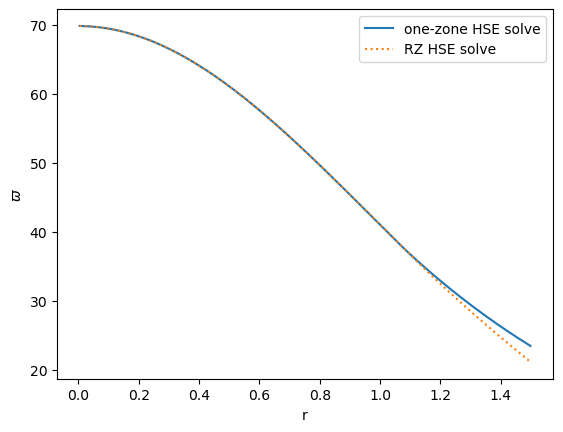

In [102]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='one-zone HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_RZ['pomega'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='RZ HSE solve',ls=':')
# plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])-interpolations['g_phi'](r_nd[r_nd<r_bounds[-1]/L_nd])[-1],label='initial MESA profile',ls='--')
plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\varpi$')
# plt.yscale('log')

Text(0.5, 0, 'r')

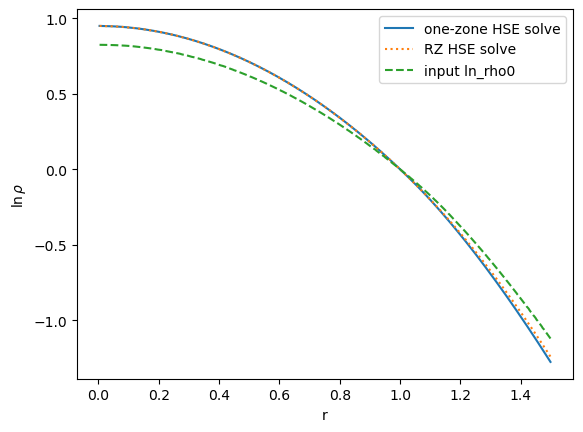

In [103]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='one-zone HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_RZ['ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='RZ HSE solve',ls=':')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],interpolations['ln_rho0'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='input ln_rho0',ls='--')
plt.legend()
plt.ylabel(r'$\ln \rho$')
plt.xlabel('r')

Text(0.5, 0, 'r')

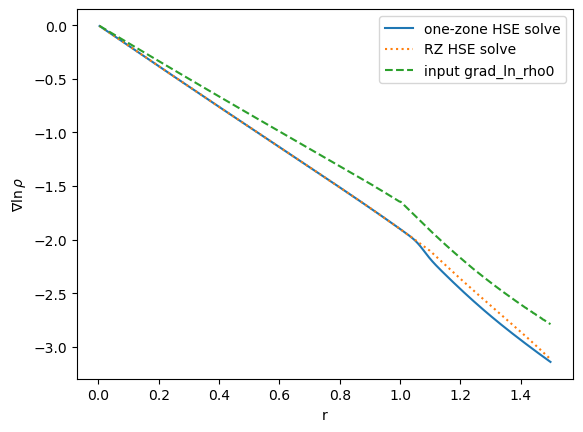

In [104]:
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['grad_ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='one-zone HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_RZ['grad_ln_rho'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='RZ HSE solve',ls=':')
plt.plot(r_nd[r_nd < 1.5],interpolations['grad_ln_rho0'](r_nd)[r_nd<1.5],label='input grad_ln_rho0',ls='--')
plt.legend()
plt.ylabel(r'$\nabla \ln \rho$')
plt.xlabel('r')

Text(0, 0.5, '$N^2$')

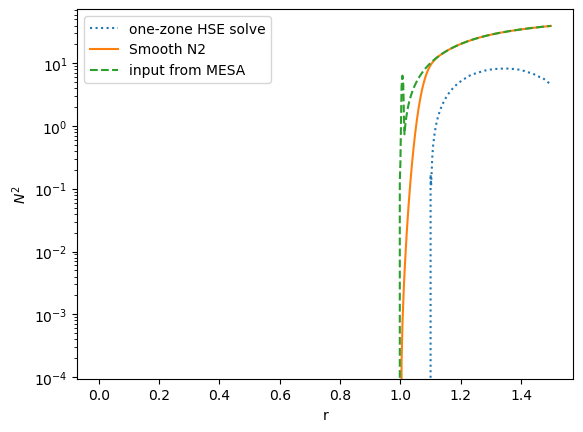

In [105]:
# plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test['N2'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='new HSE solve')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],atmo_test_RZ['N2'](r_nd[r_nd<r_bounds[-1]/L_nd]),label='one-zone HSE solve',ls=':')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],N2_func(r_nd[r_nd<r_bounds[-1]/L_nd]),label='Smooth N2',ls='-')
plt.plot(r_nd[r_nd<r_bounds[-1]/L_nd],tau_nd**2*N2[r_nd<r_bounds[-1]/L_nd],label='input from MESA',ls='--')
plt.legend()
plt.yscale('log')
plt.xlabel('r')
plt.ylabel(r'$N^2$')